In [57]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [58]:
set.seed(1234)
options(digits=2)
stats <- c()

In [59]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [60]:
if(!exists("papermill_run")) {
    prj_name = "Screen1"
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
    de_testing = "NEIGHBORHOOD"
    filter_low_cas9 = "NO"
}

In [61]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as vector_positive, all others as target_negative

In [62]:
# mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
#     all_cells = Cells(seurat_obj)
#     perturbed_cells = c()
#     dummy_perturbed = c()
    
#     for(guide in guides) {
#         dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
#         perturbed_cells = union(perturbed_cells, dummy_perturbed)
#         #cat(guide," ", length(perturbed_cells), "\n")
#     }

#     unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
#     Idents(seurat_obj) <- "target_negative"
#     seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "vector_positive") 

#     if(print_counts) {
#         n_gplus   = length(perturbed_cells)
#         n_gminus = length(unperturbed_cells)    
#         cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
#     }
    
#     seurat_obj
# }

### Load guide df

In [63]:
if(prj_name == "Screen1") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")
} else if(prj_name == "Screen2") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/neighbors_list.rds")
}

sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label,diffexed_gene
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE,CCNB1
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE,
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE,
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE,
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE,
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE,PLIN3


### Load Seurat file

In [64]:
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


In [65]:
table(seurat_combined@meta.data$n_guides)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
6381 1786 6121 1705 3264 1317 1697  854  873  599  480  332  291  221  195  141 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 102   79   81   75   64   49   47   39   38   31   28   18   15   15   22   12 
  32   33   34   35   36   37   38   39   40   41   42   43   45   46   47   48 
  21   17    8   12   11   14    5    4    4   10    6    6    2    5    5    1 
  49   50   51   52   53   54   55   56   57   58   59   60   62   64   65   69 
   2    6    4    4    1    4    1    3    2    2    1    2    3    1    1    1 
  77 
   1 

In [66]:
if(filter_low_cas9 == "YES") {
    seurat_combined$sct_cas9 = seurat_combined[['SCT']]@data['dCas9',]
    seurat_combined = subset(seurat_combined, subset=sct_cas9 > 2)
}


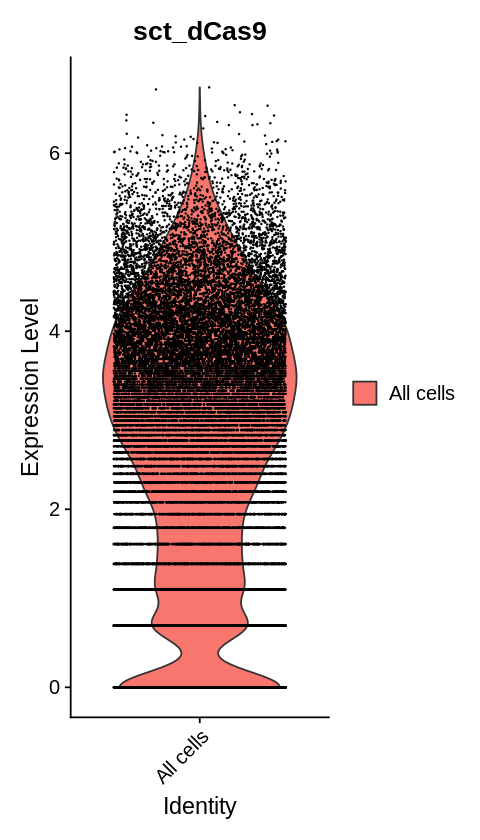

In [67]:
options(repr.plot.width = 4, repr.plot.height = 7)
Idents(seurat_combined) <- "All cells"
VlnPlot(seurat_combined, assay = 'SCT', features = "sct_dCas9")

Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [68]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [69]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [70]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [71]:
THRESHOLD_MULTIPLIER = 1
cat(red("Using ", THRESHOLD_MULTIPLIER, "x threshold"))

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using  1 x threshold

In [72]:
length(perturbed_cells_by_guide[[3]])

[1] 796

In [73]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

In [74]:
head(seurat_rna)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,status,donor,dCas9,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,25185,5887,3237,19,24864,5840,Screen1_66guides,Lib_1,6.7,singlet,3,20,1,1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGCTTAAGA-1_1,43958,7411,2844,31,25774,6580,Screen1_66guides,Lib_1,9.0,singlet,0,55,2,2,CD13-1a|CD13-1b|DE3-2a|DE3-2b,CD13-1|DE3-2,4,2
AAACCCAAGGCTGTAG-1_1,73018,9094,1908,22,24680,5745,Screen1_66guides,Lib_1,14.0,singlet,0,181,2,2,TKT-1a|TKT-1b,TKT-1,2,1
AAACCCAAGGTTTACC-1_1,63652,8614,2088,20,25085,5994,Screen1_66guides,Lib_1,6.2,singlet,2,58,0,0,DE9-1a|DE9-1b|DE11-1a,DE9-1|DE11-1,3,2
AAACCCAAGTGATCGG-1_1,34135,6635,7,7,25531,6506,Screen1_66guides,Lib_1,15.5,singlet,2,1,6,6,NA,NA,0,0
AAACGAACAATTGCTG-1_1,39723,7312,1343,17,25647,6815,Screen1_66guides,Lib_1,5.5,singlet,1,100,2,2,CD55-1a|CD55-1b|TKT-2a|TKT-2b,CD55-1|TKT-2,4,2
AAACGAACAGGTGAGT-1_1,41606,7788,15272,77,25724,7144,Screen1_66guides,Lib_1,5.2,singlet,1,275,4,4,CD13-1a|CD13-1b|CD55-1a|FUBP1-1a|FUBP1-1b|MAFF-1a|MAFF-1b|TKT-1b|CSTB-1a|CSTB-1b|CTSB-2a|DE8-1a|DE11-1a|DE17-2b|NTCE3-1a|CCCE2-1a|CCCE2-1b,CD13-1|CD55-1|FUBP1-1|MAFF-1|TKT-1|CSTB-1|CTSB-2|DE8-1|DE11-1|DE17-2|NTCE3-1|CCCE2-1,17,12
AAACGAACATGGCTGC-1_1,34297,7322,1328,14,25795,7184,Screen1_66guides,Lib_1,3.6,singlet,1,4,5,5,DE7-1a|DE7-1b,DE7-1,2,1
AAACGAAGTAAGACCG-1_1,85992,10086,6496,35,25234,6617,Screen1_66guides,Lib_1,7.6,singlet,2,37,5,5,FUBP1-1a|FUBP1-1b|CSTB-2a|CSTB-2b|DE12-1a|DE12-1b,FUBP1-1|CSTB-2|DE12-1,6,3


# Check DE for genes near SNPs

In [75]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

## Load neighbors list

# Run diffex on pseudobulked samples using EdgeR

This version ran DE testing on all genes. If you want to include only the neighbors, use: markers <- qlf$table[neighbors, ] %>% arrange(PValue)

In [76]:
library(edgeR)

In [77]:
sample_n(df_guide, 5)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label,diffexed_gene
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs4669722,DE10-1a,DE10-1b,DE10,ckd_de,targeting,rs4669722,CKD DE,
CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS,ANPEP
rs34861762,DE7-2a,DE7-2b,DE7,ckd_de,targeting,rs34861762,CKD DE,STC1
GDOC3,GDOC3-1a,GDOC3-1b,GDOC3,gdoc,nt_ctrl,GDOC3,gdoc,
rs7642977,DE2-1a,DE2-1b,DE2,ckd_de,targeting,rs7642977,CKD DE,


### This is the loop before refactoring

In [78]:
# source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
# df_targets = unique(filter(df_guide, subclass=='ckd_de'))
# df_targets = unique(filter(df_guide, class=='targeting'))
# #df_targets = unique(filter(df_guide, alias=='PLIN3'))

# df_neighbor_de = NULL
# df_cell_counts = NULL
# test_use = "LR" #"MAST"  #"wilcox" "LR"
# guides_to_skip = c()  #c("DE6", "DE15")  
# logfc_threshold = 0.01

# for(i in 1:nrow(df_targets)) {
#     is_de = FALSE
#     target          = df_targets[i,'alias']
#     target_subclass = df_targets[i, 'subclass']
#     label           = df_targets[i, 'label']
#     vector_id       = gsub("a", "", df_targets[i, 'guide1'])
#     snp_id_or_gene_name = df_targets[i,'gene']
    
#     if(!str_detect(target, regex("^DE\\d+$"))) {
#         is_de = FALSE
#         neighbors = neighbors_list[[target]]
#     } else {
#         is_de = TRUE
#         neighbors = neighbors_list[[snp_id_or_gene_name]]
#     }

#     if((target %in% guides_to_skip) | length(neighbors) == 0 ){
#         cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
#         next
#     }
#     guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
#     guides_on_plasmid = unlist(as.list(t(df_targets[i, c('guide1', 'guide2')])))
#     cat(blue(target,":"), paste(guides_on_plasmid, collapse=","),"\n")

#     seurat_dummy <- mark_vector_pos_target_neg(
#         seurat_rna,        
#         perturbed_cells_by_guide, 
#         guides_on_plasmid,
#         guides_4_target,
#         print_counts = T,
#         pos_label = "vector_positive",
#         neg_label = "target_negative"
#     )    
#     if("vector_positive" %in% levels((Idents(seurat_dummy)))) {
#         seurat_dummy$perturbation_status = Idents(seurat_dummy)
#         #seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$donor, "_", seurat_dummy$perturbation_status)
#         #Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id
#         seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
#         print(table(filter(seurat_dummy@meta.data, perturbation_status == 'vector_positive')$donor) )


#         # Use each donor as a replicate
#         cluster_list = as.character(seurat_dummy$perturbation_status)
#         cluster_list[cluster_list == "target_negative"] = 1
#         cluster_list[cluster_list == "vector_positive"] = 0
#         seurat_dummy$cluster = as.factor(cluster_list)
#         y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

#         # Add target+/- counts to df_cell_counts
#         if(!is_de) {
#             df_dummy = as.data.frame(y$counts[target,])
#             colnames(df_dummy) = "count"
#             df_dummy$target <- target
#             df_dummy$label = rownames(df_dummy)
#             df_dummy$vector = vector_id
#             df_samples = y$samples
#             df_dummy = merge(df_dummy, df_samples, by = 0)
#             df_cell_counts = rbind(df_cell_counts, df_dummy)
#         }

#         # Filter out small samples, lowly expressed genes.
#         keep.samples <- y$samples$lib.size > 5e4
#         table(keep.samples)
#         y <- y[, keep.samples]
#         keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
#         table(keep.genes)
#         y <- normLibSizes(y)

#         # Create design matrix
#         donor <- factor(y$samples$sample)
#         cluster <- as.factor(y$samples$cluster)
#         design <- model.matrix(~ cluster + donor)
#         colnames(design) <- gsub("donor", "", colnames(design))
#         colnames(design)[1] <- "Int"

#         ncls <- nlevels(cluster)
#         contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
#         diag(contr) <- 1
#         contr[1,] <- 0
#         rownames(contr) <- colnames(design)
#         colnames(contr) <- paste0("cluster", levels(cluster))
        
#         # Estimate dispersion
#         y <- estimateDisp(y, design, robust=TRUE)
#         y$common.dispersion

#         # Fit
#         fit <- glmQLFit(y, design, robust=TRUE)
#         qlf <- glmQLFTest(fit, contrast=contr[,1])
        
#         if(de_testing == "NEIGHBORHOOD") {
#             markers <- qlf$table[neighbors, ] %>% arrange(PValue)
#         } else { 
#             # Test all genes
#             markers <- qlf$table %>% arrange(PValue)
#         }

#         if(nrow(markers) == 0) {
#             cat(red("No DE genes", target,  "\n"))
#             next
#         } 
      
#         markers$de_gene = rownames(markers)
#         markers$target = target
#         markers$subclass = target_subclass
#         markers$label = label
#         markers$plasmid = vector_id #gsub("a", "", guides_on_plasmid[[1]])
#         rownames(markers) <- NULL
#         df_neighbor_de = rbind(df_neighbor_de, markers)
#         print(head(markers))
#         cat("-------------------------------------------------------\n\n")
#     } else {
#         cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
#     }
# }


### After refactoring

In [79]:
# Helper function to prepare design matrix and contrast matrix
prepare_design_and_contrast <- function(y) {
    donor <- factor(y$samples$sample)
    cluster <- as.factor(y$samples$cluster)  # Convert cluster to a factor (if not already)
    
    design <- model.matrix(~ cluster + donor)
    colnames(design) <- gsub("donor", "", colnames(design))
    colnames(design)[1] <- "Int"

    ncls <- nlevels(cluster)
    contr <- rbind(matrix(1 / (1 - ncls), ncls, ncls), matrix(0, ncol(design) - ncls, ncls))
    diag(contr) <- 1
    contr[1, ] <- 0
    rownames(contr) <- colnames(design)
    colnames(contr) <- paste0("cluster", levels(cluster))

    return(list(design = design, contrast = contr))
}

# Helper function to perform differential expression analysis
perform_de_analysis <- function(y, design, contrast, neighbors, target, de_testing) {
    y <- estimateDisp(y, design, robust = TRUE)
    print(y$common.dispersion)

    fit <- glmQLFit(y, design, robust = TRUE)
    qlf <- glmQLFTest(fit, contrast = contrast[, 1])
    plotQLDisp(fit)

    if (de_testing == "NEIGHBORHOOD") {
        markers <- qlf$table[neighbors, ] %>% arrange(PValue)
    } else {
        # Test all genes
        markers <- qlf$table %>% arrange(PValue)
    }

    return(markers)
}

# Helper function to process cells with the given target and perturbation status
process_target_cells <- function(
    seurat_dummy, target, vector_id, is_de, neighbors, diffex_gene,
    perturbed_cells_by_guide, guides_on_plasmid, guides_4_target, 
    df_cell_counts, df_neighbor_de, pos_label, neg_label, target_subclass
) {
    # Filter out the vector_neg_target_pos cells, bc they mess up the design matrix
    seurat_dummy = subset(seurat_dummy, ident=c(pos_label, neg_label))
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'vector_positive')$donor))

    cluster_list <- as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "target_negative"] <- 1
    cluster_list[cluster_list == "vector_positive"] <- 0
    seurat_dummy$cluster <- as.factor(cluster_list)
    y <- Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

    # Add target+/- counts to df_cell_counts
    #if (!is_de | diffex_gene != "") {
    if (diffex_gene != "") {
        # df_dummy <- as.data.frame(y$counts[target, ])
        # colnames(df_dummy) <- "count"
        # df_dummy$target <- target
        # df_dummy$label = rownames(df_dummy)
        # df_dummy$vector = vector_id
        # df_dummy$subclass = target_subclass
        # df_samples = y$samples
        # df_dummy = merge(df_dummy, df_samples, by = 0)
        # df_cell_counts <- rbind(df_cell_counts, df_dummy)

        df_dummy = as.data.frame(cpm(y)[diffex_gene,])
        colnames(df_dummy) = "cpm"
        df_dummy$target <- diffex_gene
        df_dummy$vector <- vector_id
        df_dummy$label = rownames(df_dummy)
        df_dummy$subclass = target_subclass
        df_samples = y$samples
        df_dummy = merge(df_dummy, df_samples, by = 0)
        df_cell_counts = rbind(df_cell_counts, df_dummy)
    }

    # Filter out small samples, lowly expressed genes.
    keep.samples <- y$samples$lib.size > 5e4
    y <- y[, keep.samples]
    keep.genes <- filterByExpr(y, group = y$samples$cluster, min.count = 10, min.total.count = 20)
    y <- normLibSizes(y)

    design_and_contrast <- prepare_design_and_contrast(y)
    markers <- perform_de_analysis(
        y, 
        design_and_contrast$design, 
        design_and_contrast$contrast, 
        neighbors, 
        target, 
        de_testing
    )

    if (nrow(markers) == 0) {
        cat(red("No DE genes", target, "\n"))
    } else {
        markers$de_gene <- rownames(markers)
        markers$target <- target
        markers$subclass <- target_subclass
        markers$label <- label
        markers$plasmid <- vector_id
        rownames(markers) <- NULL
        df_neighbor_de <- rbind(df_neighbor_de, markers)
        print(head(markers))
        cat("-------------------------------------------------------\n\n")
    }

    if(de_testing == "NEIGHBORHOOD") {
        n_tests_performed = length(neighbors)
    } else {
        n_tests_performed = nrow(y)
    }

    return(list(df_cell_counts = df_cell_counts, df_neighbor_de = df_neighbor_de, n_tests_performed = n_tests_performed))
}

ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   889 
[1] "CD13-1a" "CD13-1b"
[1] "CD13-1a" "CD13-1b"
Vector+ = 1161 ; Target- = 25981 ; All = 27142 

donor0 donor1 donor2 donor3 
   270    233    385    273 
[1] 0.0014
  logFC logCPM    F   PValue de_gene target subclass       label plasmid
1 -1.32    6.9 1122 2.6e-207   ANPEP  ANPEP      tss Control TSS  CD13-1
2 -0.33    6.7   76  2.5e-18    IDH2  ANPEP      tss Control TSS  CD13-1
3 -0.20    6.7   27  1.8e-07  SEMA4B  ANPEP      tss Control TSS  CD13-1
4  0.23    5.4   23  1.5e-06   AP3S2  ANPEP      tss Control TSS  CD13-1
5  0.21    5.4   19  1.5e-05   MFGE8  ANPEP      tss Control TSS  CD13-1
6 -0.36    3.5   15  1.2e-04   FANCI  ANPEP      tss Control TSS  CD13-1
-------------------------------------------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   848 
[1] "CD55-1a" "CD55-1b"
[1] "CD55-1a" "CD55-1b"
Vector+ = 1081 ; Target- = 26061 ; All = 27142 

donor0 donor1 donor2 donor3 
   253    220    319    289 
[1

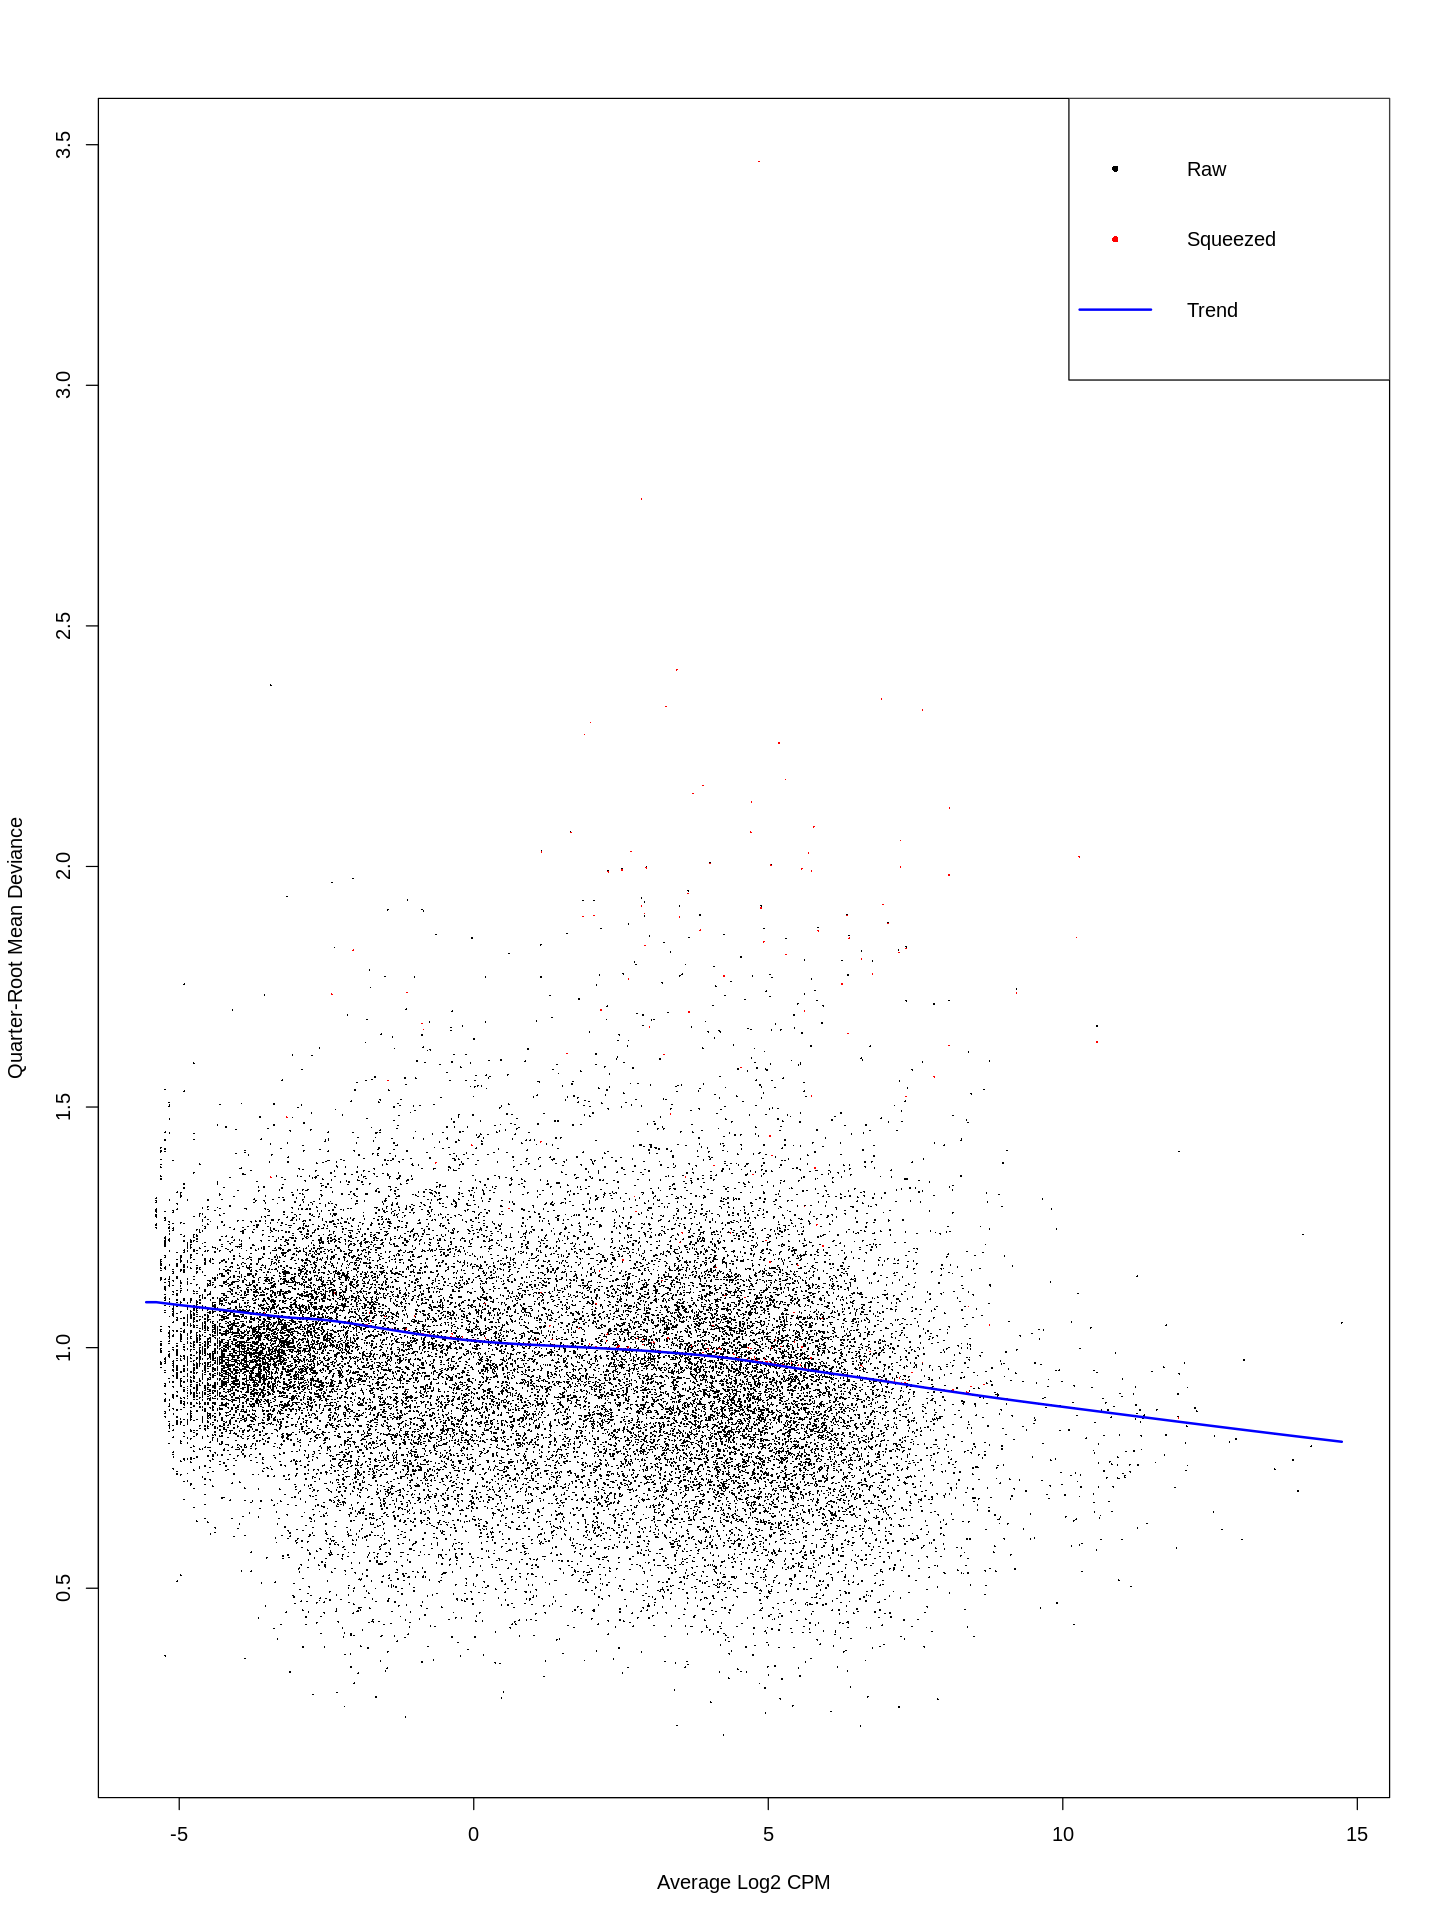

  logFC logCPM     F  PValue  de_gene target subclass       label plasmid
1 -2.20    4.1 432.1 8.8e-96     CD55   CD55      tss Control TSS  CD55-1
2 -0.32    2.6   6.2 1.3e-02 C1orf116   CD55      tss Control TSS  CD55-1
3 -0.28    2.9   5.9 1.5e-02    IKBKE   CD55      tss Control TSS  CD55-1
4 -0.18    4.0   5.3 2.1e-02    EIF2D   CD55      tss Control TSS  CD55-1
5  1.86   -3.9   3.7 5.4e-02      CR2   CD55      tss Control TSS  CD55-1
6  0.18    3.1   3.3 6.9e-02    DYRK3   CD55      tss Control TSS  CD55-1
-------------------------------------------------------

NT5E : CD73-1a,CD73-1b 
CD73-1a   757 
CD73-1b   769 
[1] "CD73-1a" "CD73-1b"
[1] "CD73-1a" "CD73-1b"
Vector+ = 1020 ; Target- = 26122 ; All = 27142 

donor0 donor1 donor2 donor3 
   231    215    337    237 
[1] 0.002


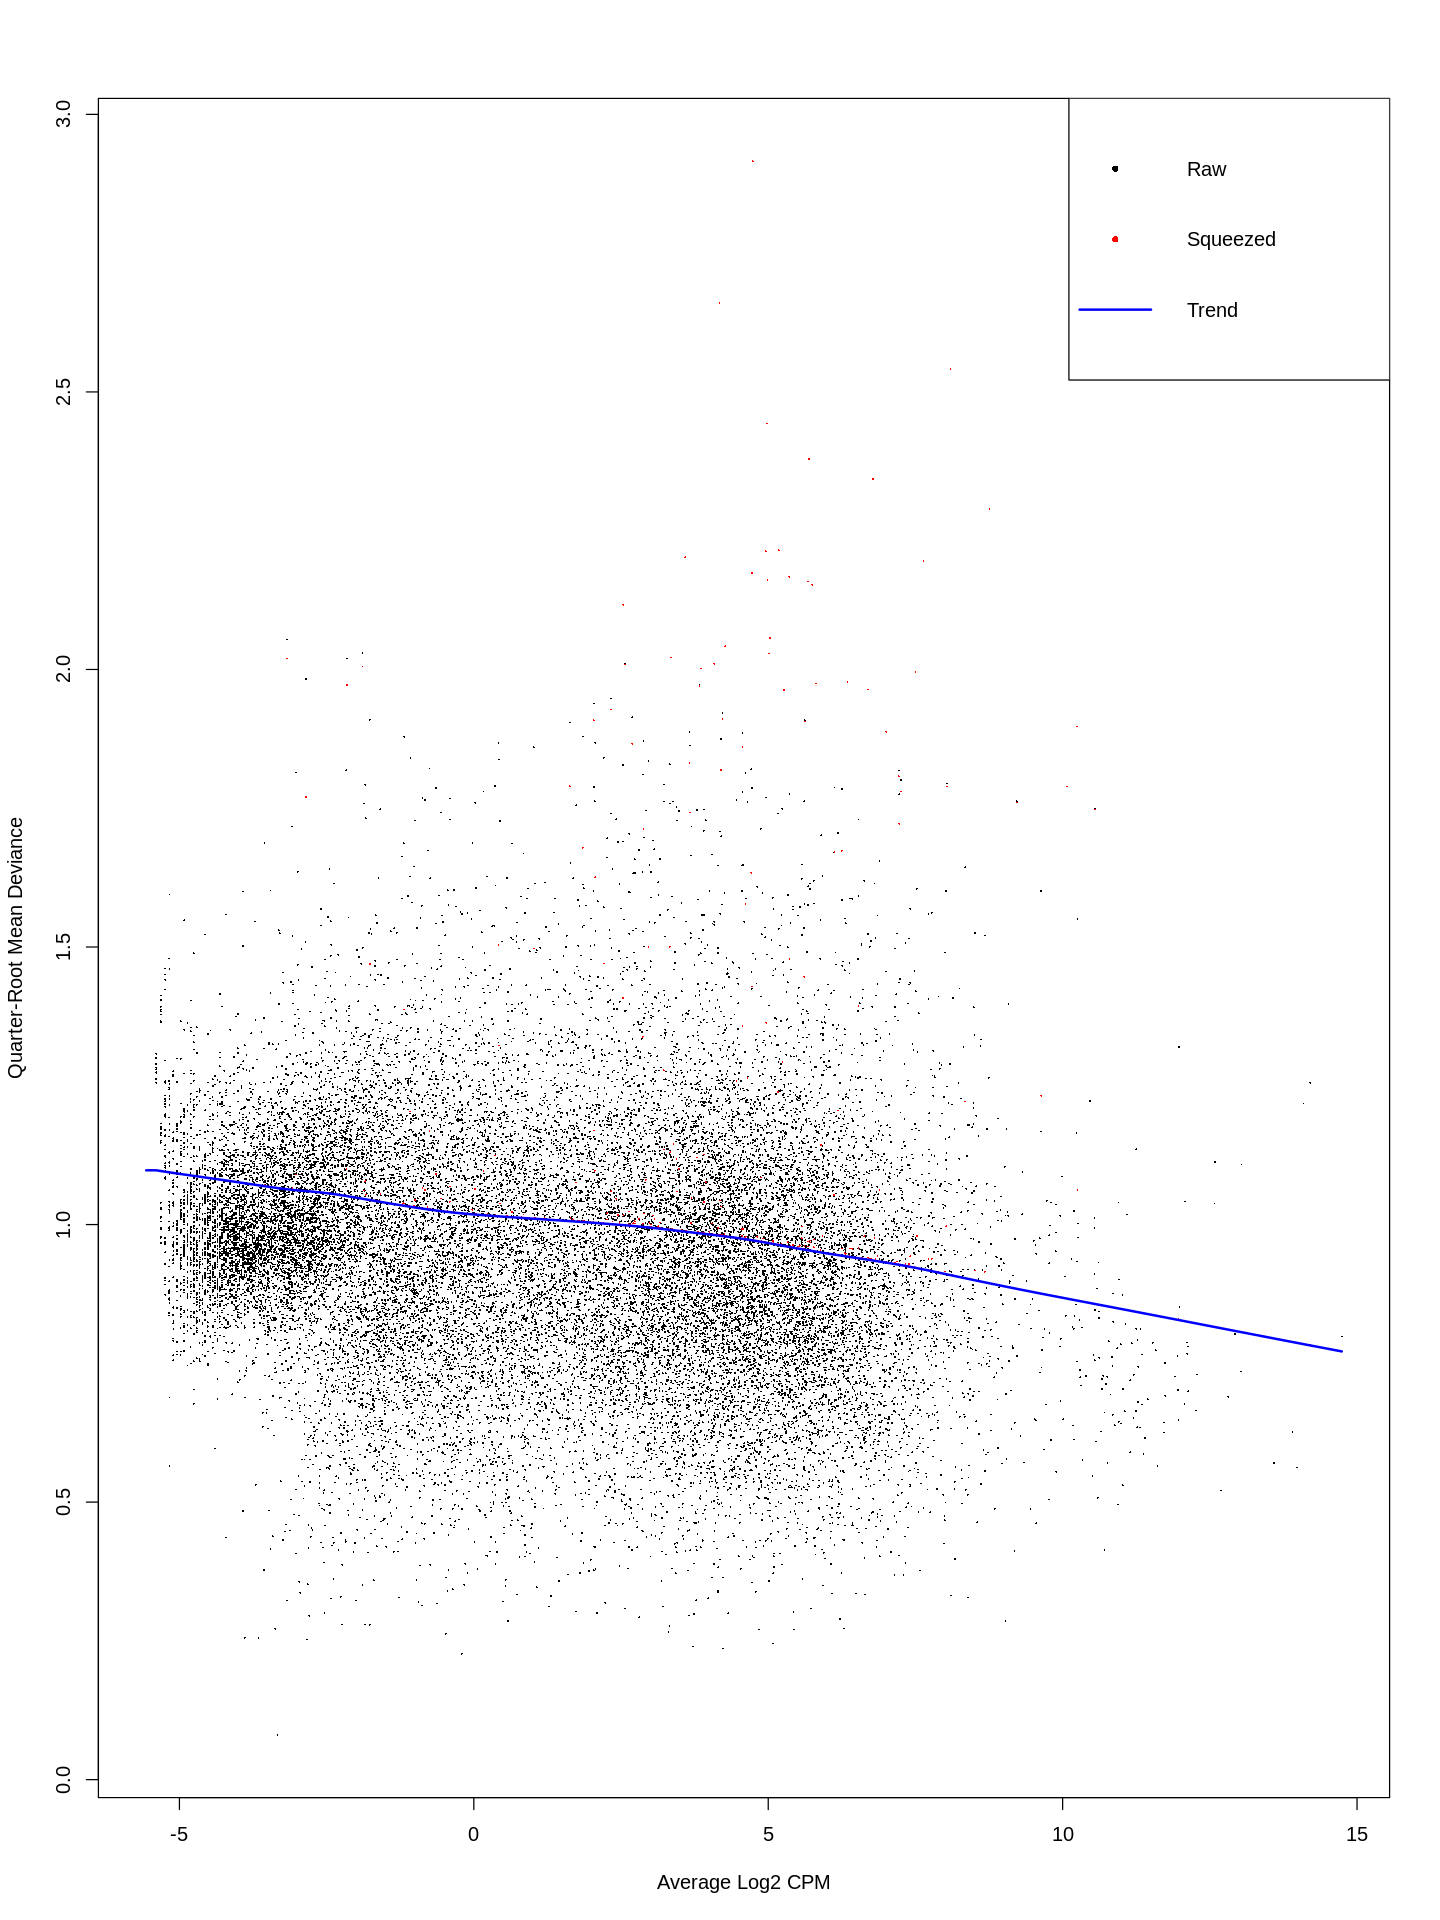

   logFC logCPM       F   PValue   de_gene target subclass       label plasmid
1 -1.848    6.4 1290.77 6.0e-165      NT5E   NT5E      tss Control TSS  CD73-1
2  0.081    6.1    3.25  7.2e-02 LINC01611   NT5E      tss Control TSS  CD73-1
3 -0.371    0.5    1.70  1.9e-01 LINC02535   NT5E      tss Control TSS  CD73-1
4  0.032    8.4    0.97  3.3e-01     SNHG5   NT5E      tss Control TSS  CD73-1
5  0.076    2.1    0.25  6.2e-01     TBX18   NT5E      tss Control TSS  CD73-1
6 -0.016    6.2    0.13  7.2e-01     SNX14   NT5E      tss Control TSS  CD73-1
-------------------------------------------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   708 
FUBP1-1b   702 
[1] "FUBP1-1a" "FUBP1-1b"
[1] "FUBP1-1a" "FUBP1-1b"
Vector+ = 925 ; Target- = 26217 ; All = 27142 

donor0 donor1 donor2 donor3 
   229    166    282    248 
[1] 0.0016


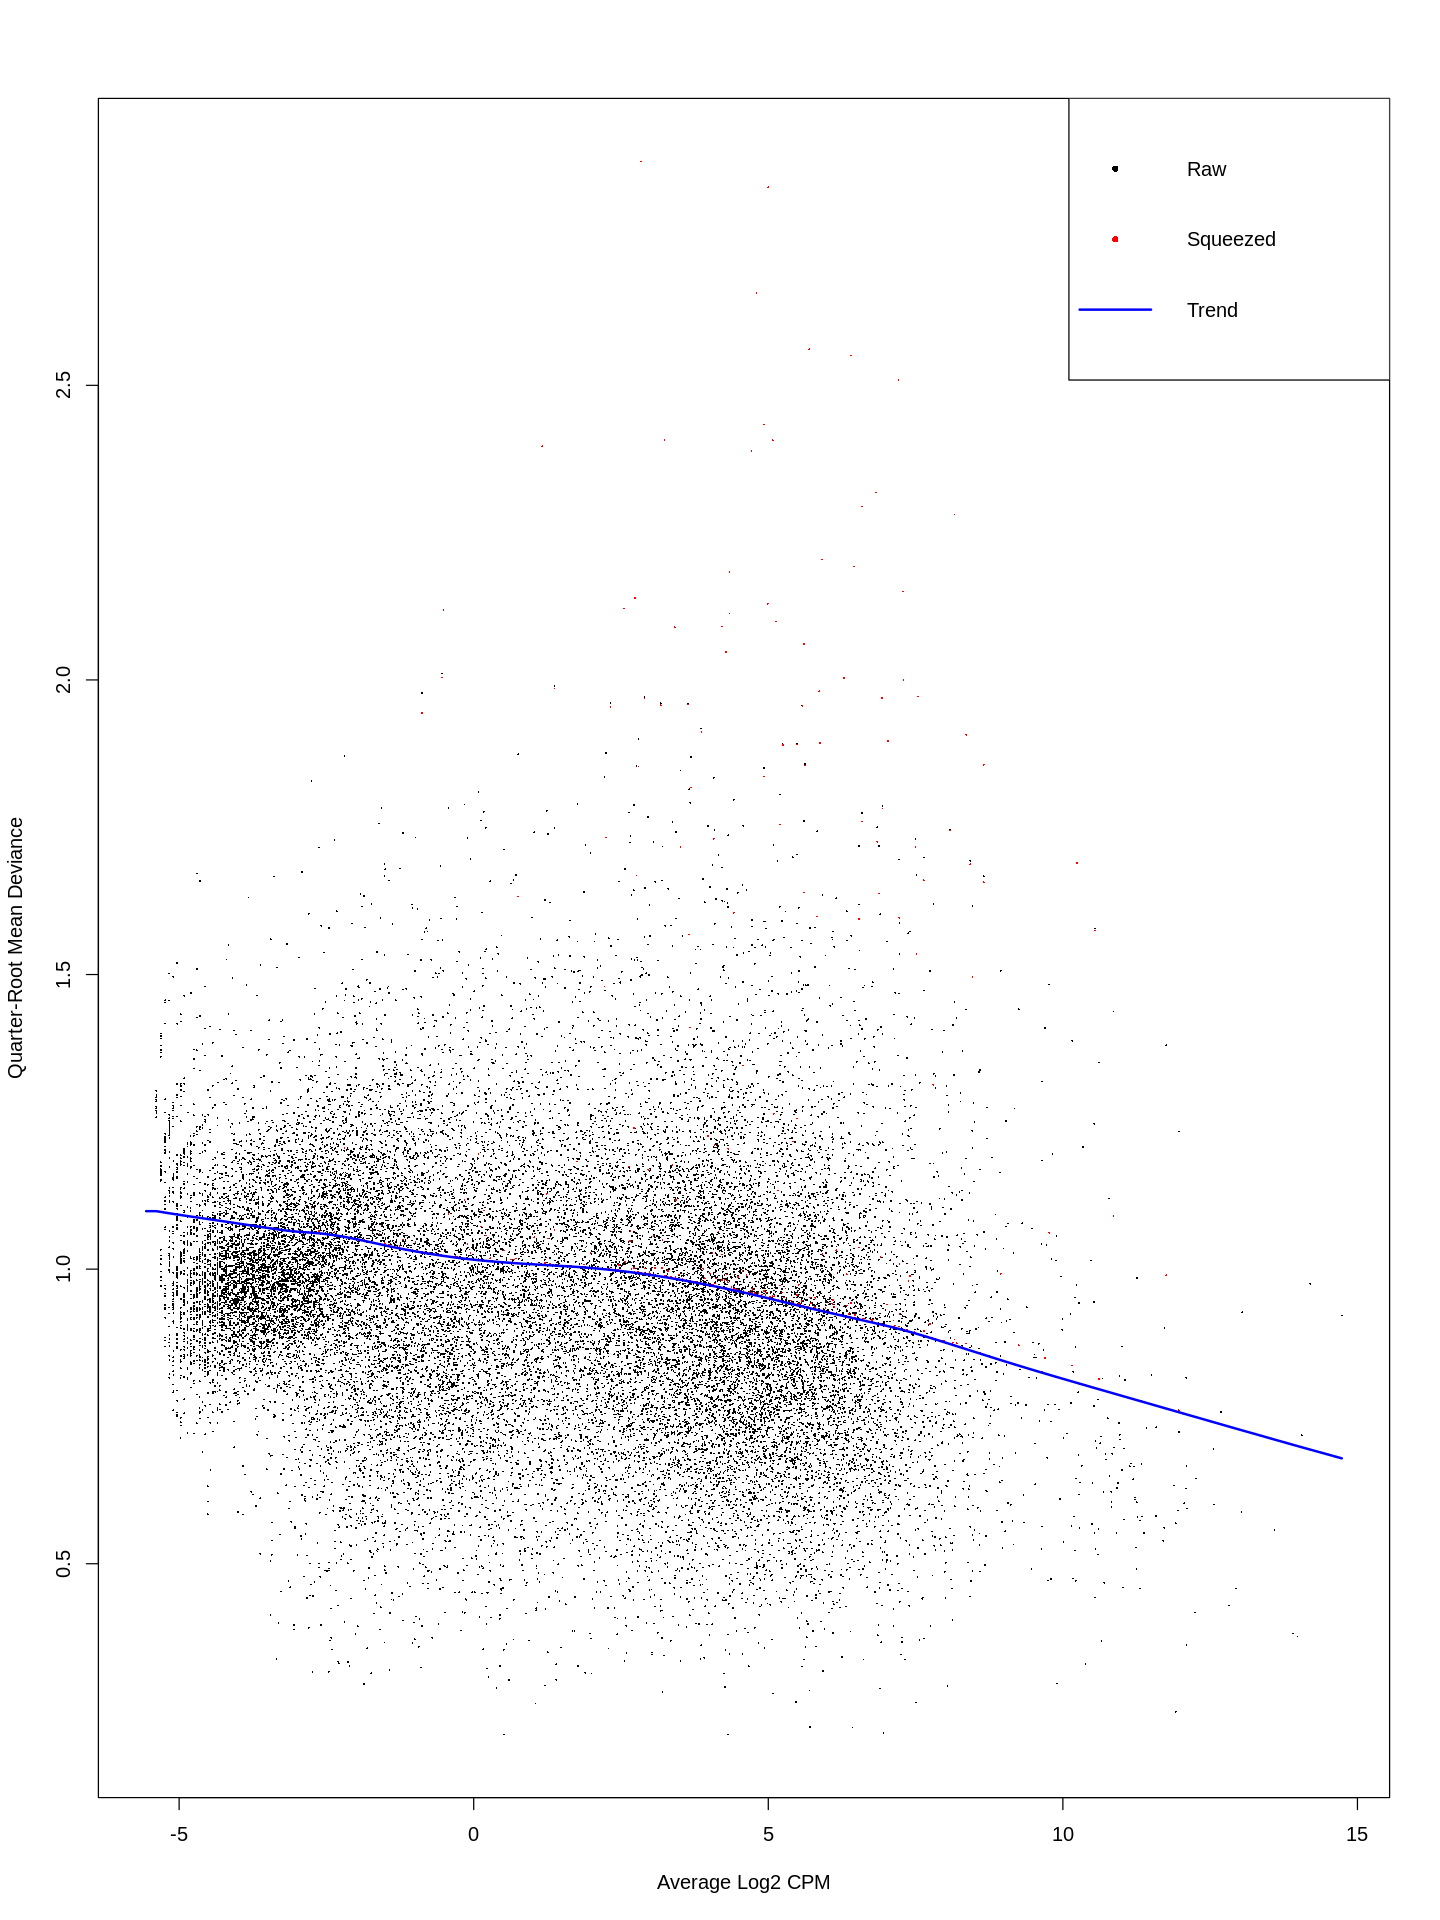

  logFC logCPM     F  PValue de_gene target subclass       label plasmid
1 -0.86    5.6 246.5 5.1e-55   FUBP1  FUBP1      tss Control TSS FUBP1-1
2 -0.18    7.4  25.2 5.1e-07     AK5  FUBP1      tss Control TSS FUBP1-1
3 -0.56    2.5  14.6 1.3e-04   PTGFR  FUBP1      tss Control TSS FUBP1-1
4 -0.21    4.6   9.1 2.5e-03  ADGRL4  FUBP1      tss Control TSS FUBP1-1
5  0.31    3.0   8.5 3.6e-03  DNAJB4  FUBP1      tss Control TSS FUBP1-1
6 -0.13    6.0   7.8 5.1e-03   USP33  FUBP1      tss Control TSS FUBP1-1
-------------------------------------------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   822 
C15orf40-1b   819 
[1] "C15orf40-1a" "C15orf40-1b"
[1] "C15orf40-1a" "C15orf40-1b"
Vector+ = 1076 ; Target- = 26066 ; All = 27142 

donor0 donor1 donor2 donor3 
   274    210    323    269 
[1] 0.0018


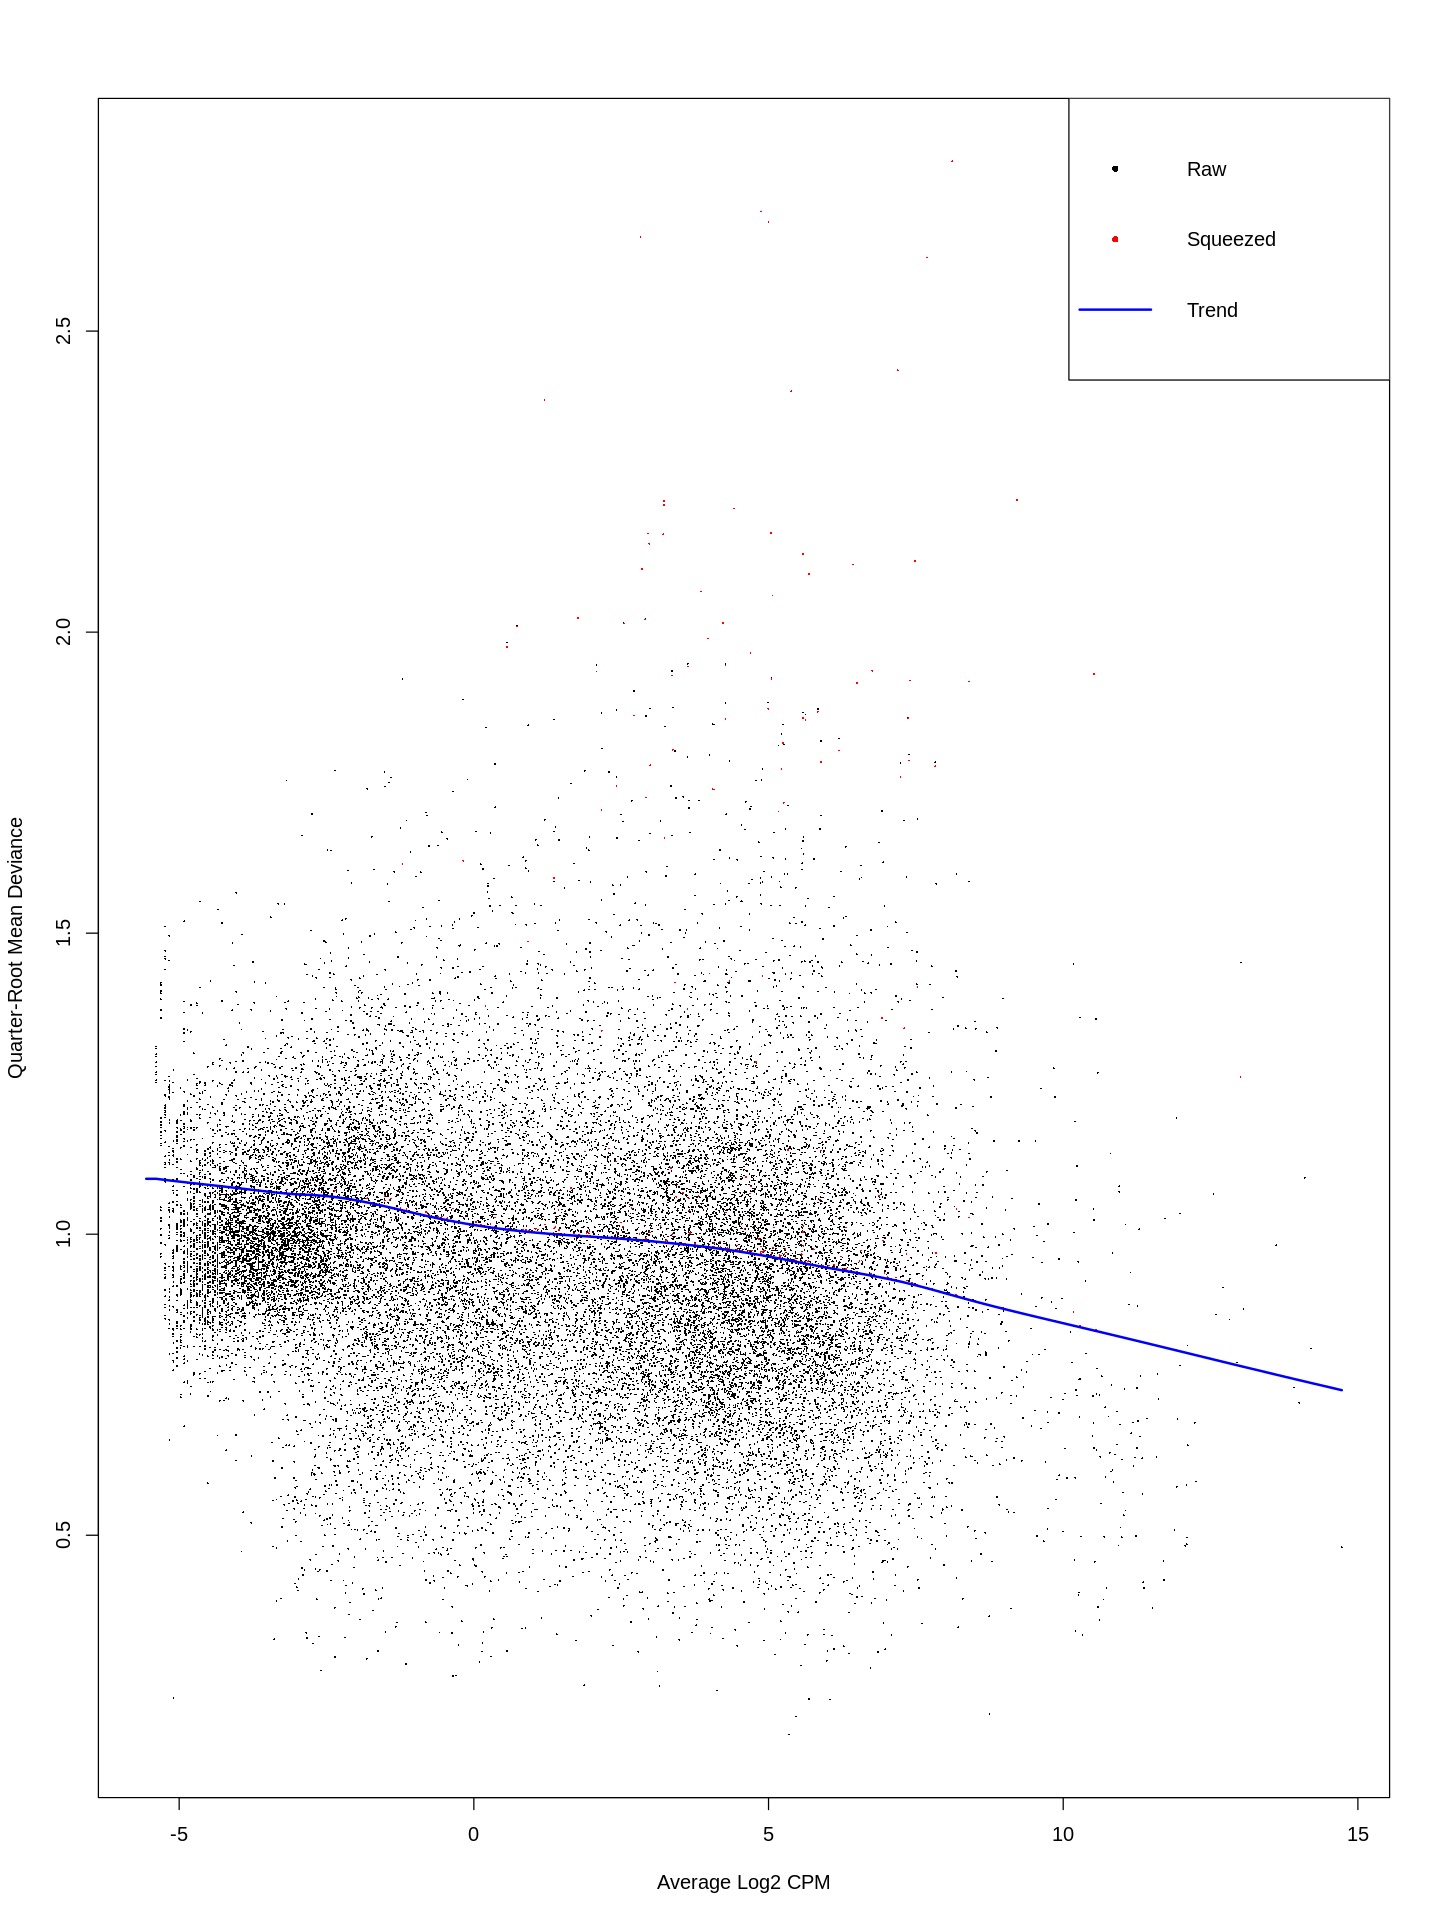

   logFC logCPM     F   PValue  de_gene   target subclass       label
1 -2.135    4.9 790.1 3.1e-173 C15orf40 C15orf40      tss Control TSS
2 -0.416    3.0  13.2  2.8e-04 ADAMTSL3 C15orf40      tss Control TSS
3  0.427    1.6   6.8  9.2e-03    CPEB1 C15orf40      tss Control TSS
4 -0.425    1.8   6.0  1.5e-02   SNHG21 C15orf40      tss Control TSS
5 -0.121    4.6   3.5  6.3e-02   HDGFL3 C15orf40      tss Control TSS
6  0.035   10.7   2.1  1.4e-01    RPS17 C15orf40      tss Control TSS
     plasmid
1 C15orf40-1
2 C15orf40-1
3 C15orf40-1
4 C15orf40-1
5 C15orf40-1
6 C15orf40-1
-------------------------------------------------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   664 
MAFF-1b   653 
[1] "MAFF-1a" "MAFF-1b"
[1] "MAFF-1a" "MAFF-1b"
Vector+ = 869 ; Target- = 26273 ; All = 27142 

donor0 donor1 donor2 donor3 
   219    185    256    209 
[1] 0.0021


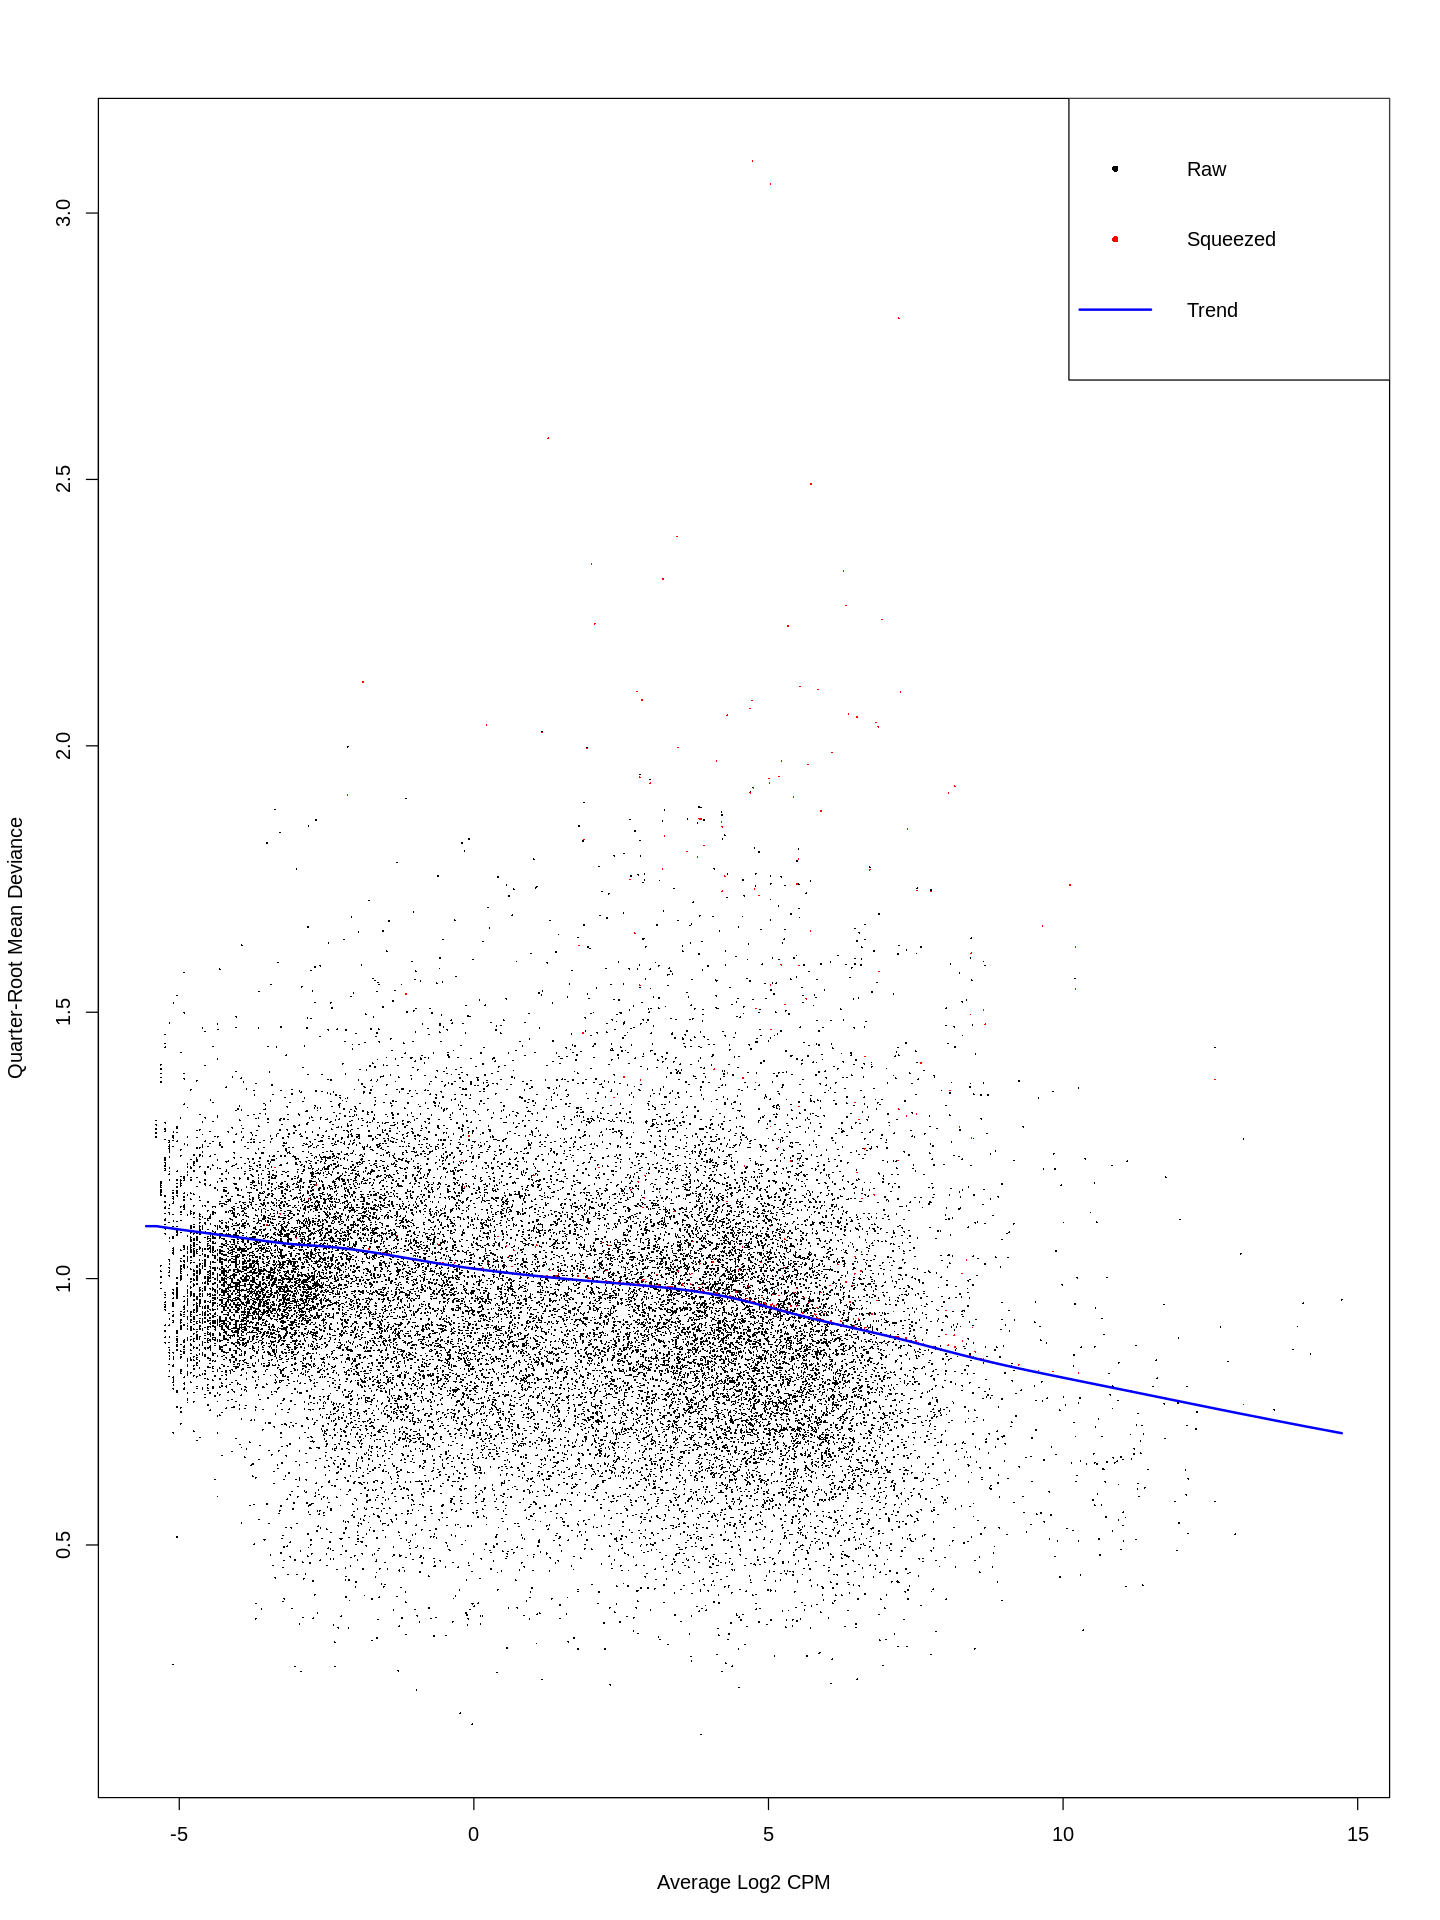

  logFC logCPM   F  PValue de_gene target subclass       label plasmid
1 -1.82   3.37 167 3.5e-38    MAFF   MAFF      tss Control TSS  MAFF-1
2 -0.19  10.47  58 2.7e-14  LGALS1   MAFF      tss Control TSS  MAFF-1
3 -1.33   1.15  21 3.8e-06  LGALS2   MAFF      tss Control TSS  MAFF-1
4 -0.46   3.67  20 6.1e-06    GCAT   MAFF      tss Control TSS  MAFF-1
5 -0.18   6.22  14 1.5e-04   EIF3L   MAFF      tss Control TSS  MAFF-1
6 -1.50   0.22  13 2.6e-04    DMC1   MAFF      tss Control TSS  MAFF-1
-------------------------------------------------------

FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   625 
FTH1-1b   598 
[1] "FTH1-1a" "FTH1-1b"
[1] "FTH1-1a" "FTH1-2a" "FTH1-1b" "FTH1-2b"
Vector+ = 841 ; Target- = 23640 ; All = 27142 

donor0 donor1 donor2 donor3 
   182    188    255    216 
[1] 0.002


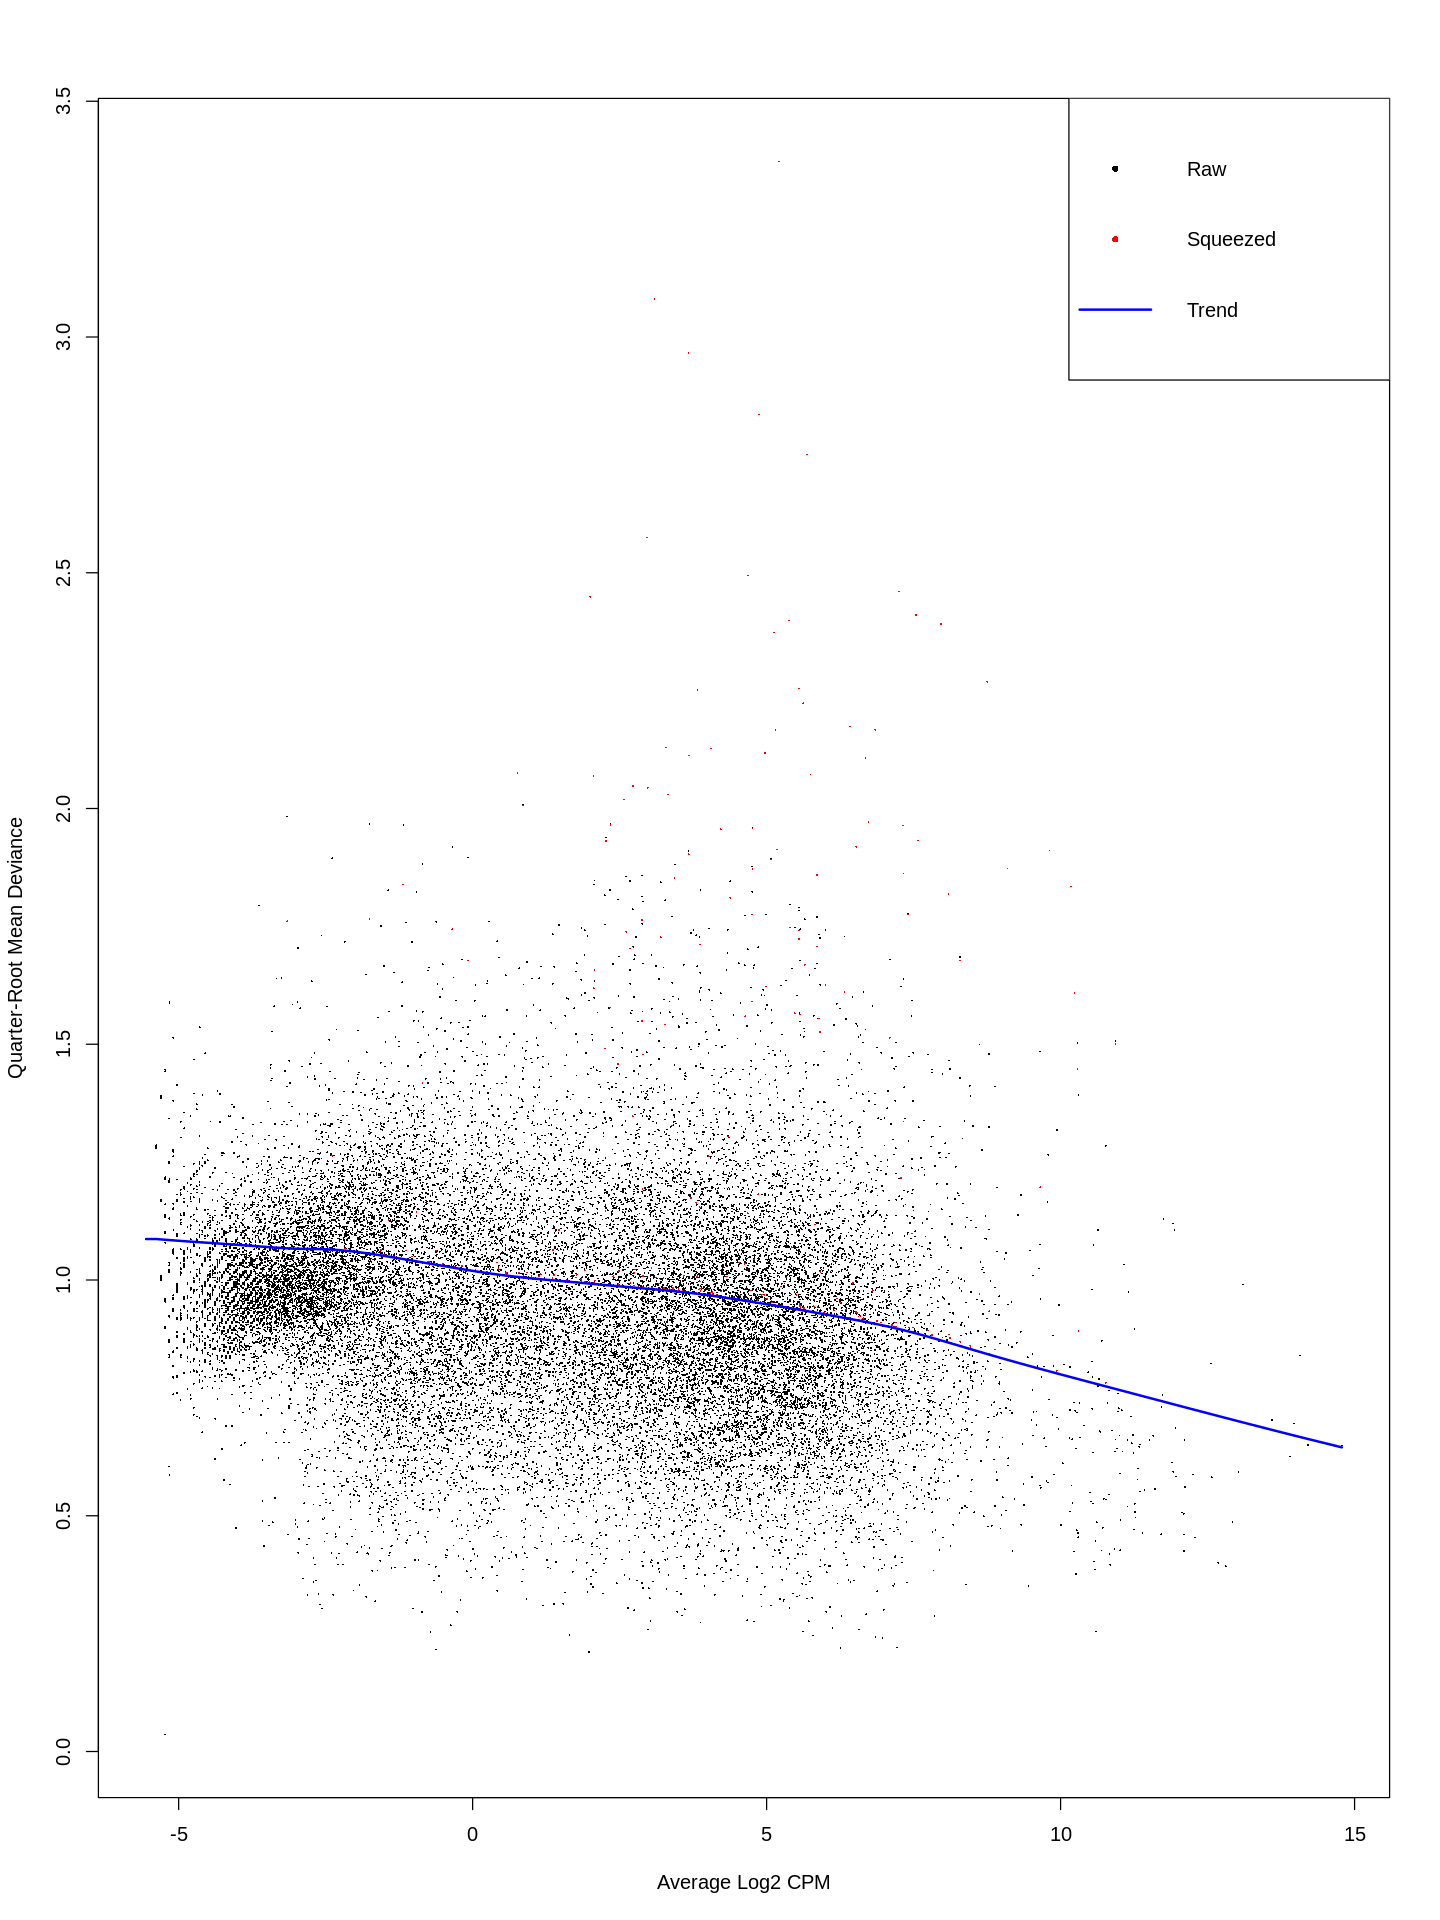

  logFC logCPM    F  PValue de_gene target   subclass      label plasmid
1 -1.67   13.6 4162 0.0e+00    FTH1   FTH1 de_control Control DE  FTH1-1
2 -1.31    3.5  109 2.1e-25   BEST1   FTH1 de_control Control DE  FTH1-1
3 -0.44    5.2   47 5.8e-12   FADS3   FTH1 de_control Control DE  FTH1-1
4 -0.46    4.8   40 2.6e-10   FADS2   FTH1 de_control Control DE  FTH1-1
5 -0.21    8.3   35 3.2e-09   AHNAK   FTH1 de_control Control DE  FTH1-1
6 -0.30    6.0   35 3.6e-09  ASRGL1   FTH1 de_control Control DE  FTH1-1
-------------------------------------------------------

FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   2836 
FTH1-2b   0 
[1] "FTH1-2a" "FTH1-2b"
[1] "FTH1-1a" "FTH1-2a" "FTH1-1b" "FTH1-2b"
Vector+ = 2836 ; Target- = 23640 ; All = 27142 

donor0 donor1 donor2 donor3 
   694    643    837    662 
[1] 0.00081


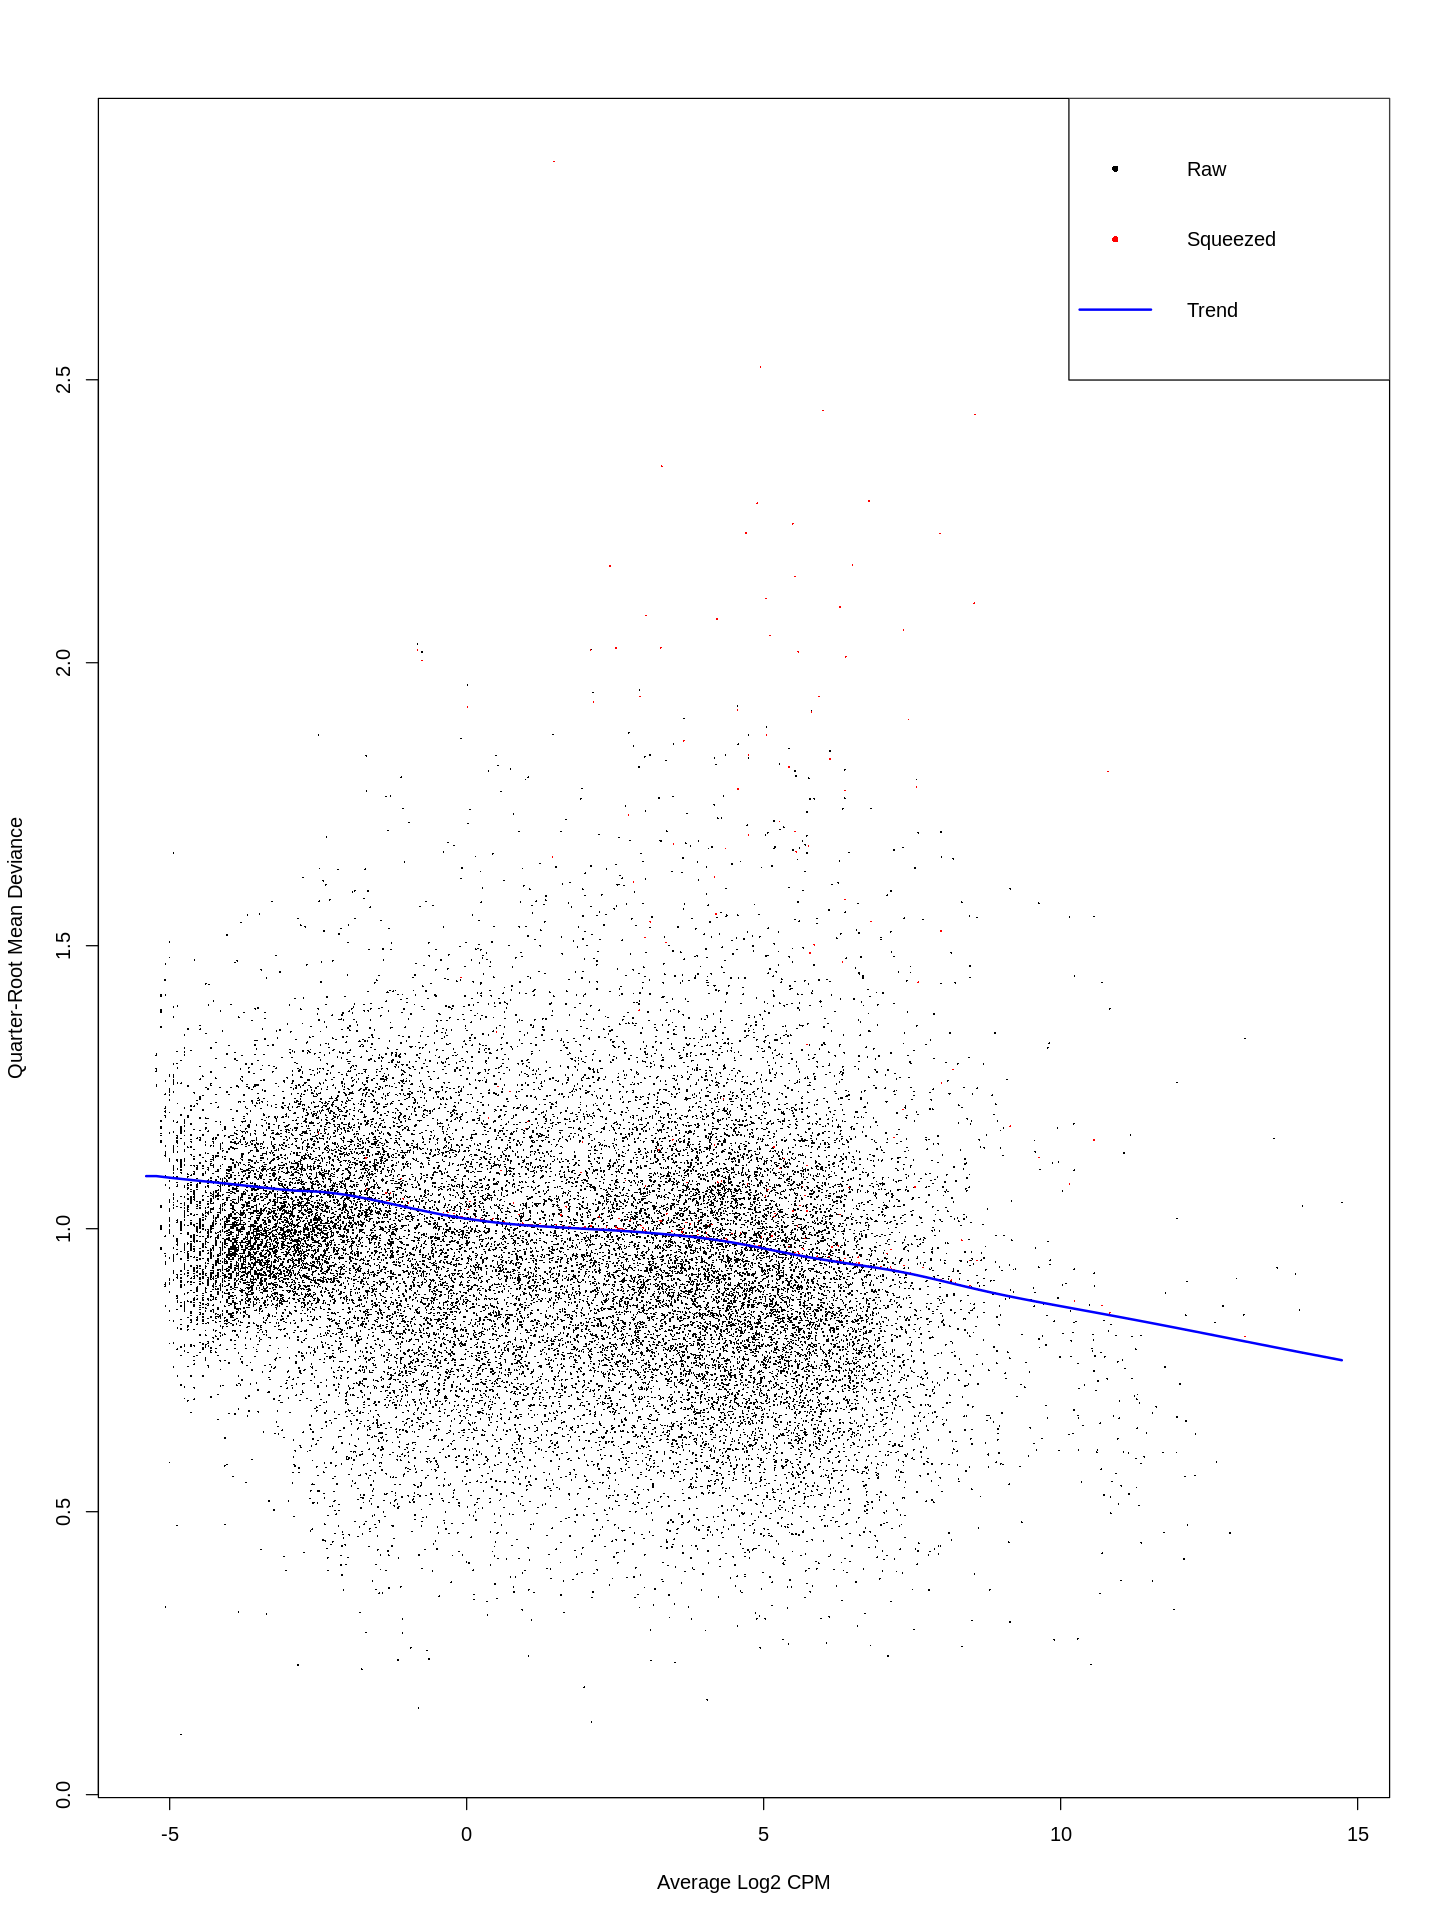

  logFC logCPM  F  PValue de_gene target   subclass      label plasmid
1 -0.42    4.7 98 3.8e-23   FADS2   FTH1 de_control Control DE  FTH1-2
2 -0.22    8.3 93 4.3e-22   AHNAK   FTH1 de_control Control DE  FTH1-2
3  0.24    6.5 76 3.3e-18  SLC3A2   FTH1 de_control Control DE  FTH1-2
4 -0.26    6.0 73 1.5e-17  ASRGL1   FTH1 de_control Control DE  FTH1-2
5 -0.20    5.9 42 7.7e-11   FADS1   FTH1 de_control Control DE  FTH1-2
6 -0.38    3.5 39 3.6e-10   BEST1   FTH1 de_control Control DE  FTH1-2
-------------------------------------------------------

PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   863 
PLIN3-1b   850 
[1] "PLIN3-1a" "PLIN3-1b"
[1] "PLIN3-1a" "PLIN3-2a" "PLIN3-1b" "PLIN3-2b"
Vector+ = 1114 ; Target- = 25086 ; All = 27142 

donor0 donor1 donor2 donor3 
   246    244    338    286 
[1] 0.0013


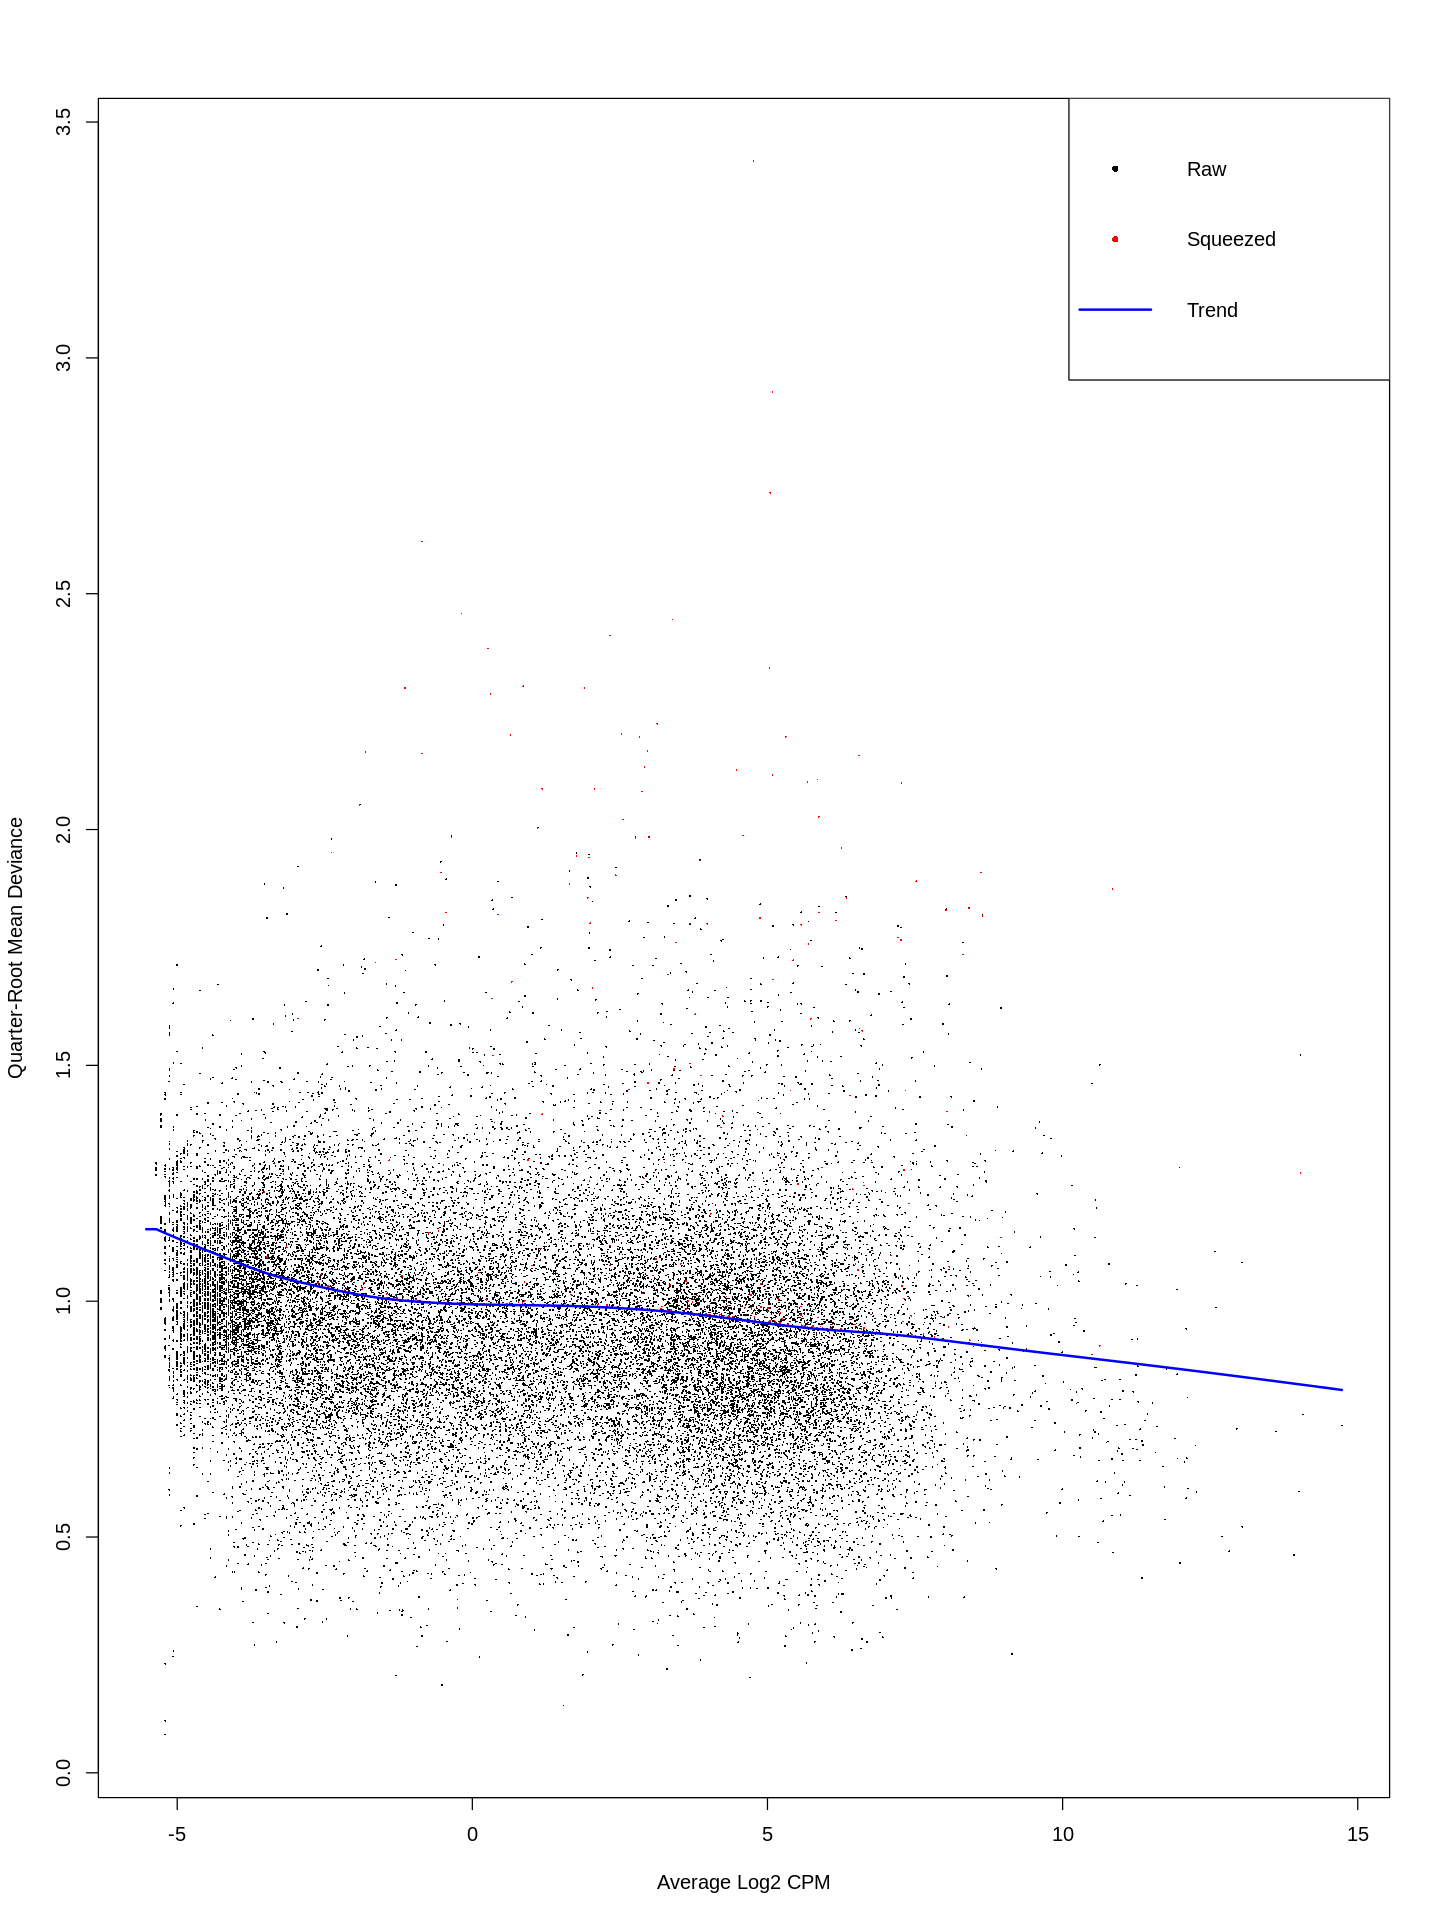

  logFC logCPM   F   PValue de_gene target   subclass      label plasmid
1 -0.96    6.3 528 1.2e-116   PLIN3  PLIN3 de_control Control DE PLIN3-1
2 -0.88    2.3  33  1.0e-08   UHRF1  PLIN3 de_control Control DE PLIN3-1
3  0.13   11.2  31  2.9e-08   RPL36  PLIN3 de_control Control DE PLIN3-1
4 -0.40    3.4  17  3.4e-05  CHAF1A  PLIN3 de_control Control DE PLIN3-1
5  0.21    4.6  12  4.5e-04    DPP9  PLIN3 de_control Control DE PLIN3-1
6  0.63    0.7   9  2.6e-03 ANKRD24  PLIN3 de_control Control DE PLIN3-1
-------------------------------------------------------

PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   781 
PLIN3-2b   797 
[1] "PLIN3-2a" "PLIN3-2b"
[1] "PLIN3-1a" "PLIN3-2a" "PLIN3-1b" "PLIN3-2b"
Vector+ = 1049 ; Target- = 25086 ; All = 27142 

donor0 donor1 donor2 donor3 
   251    209    345    244 
[1] 0.0018


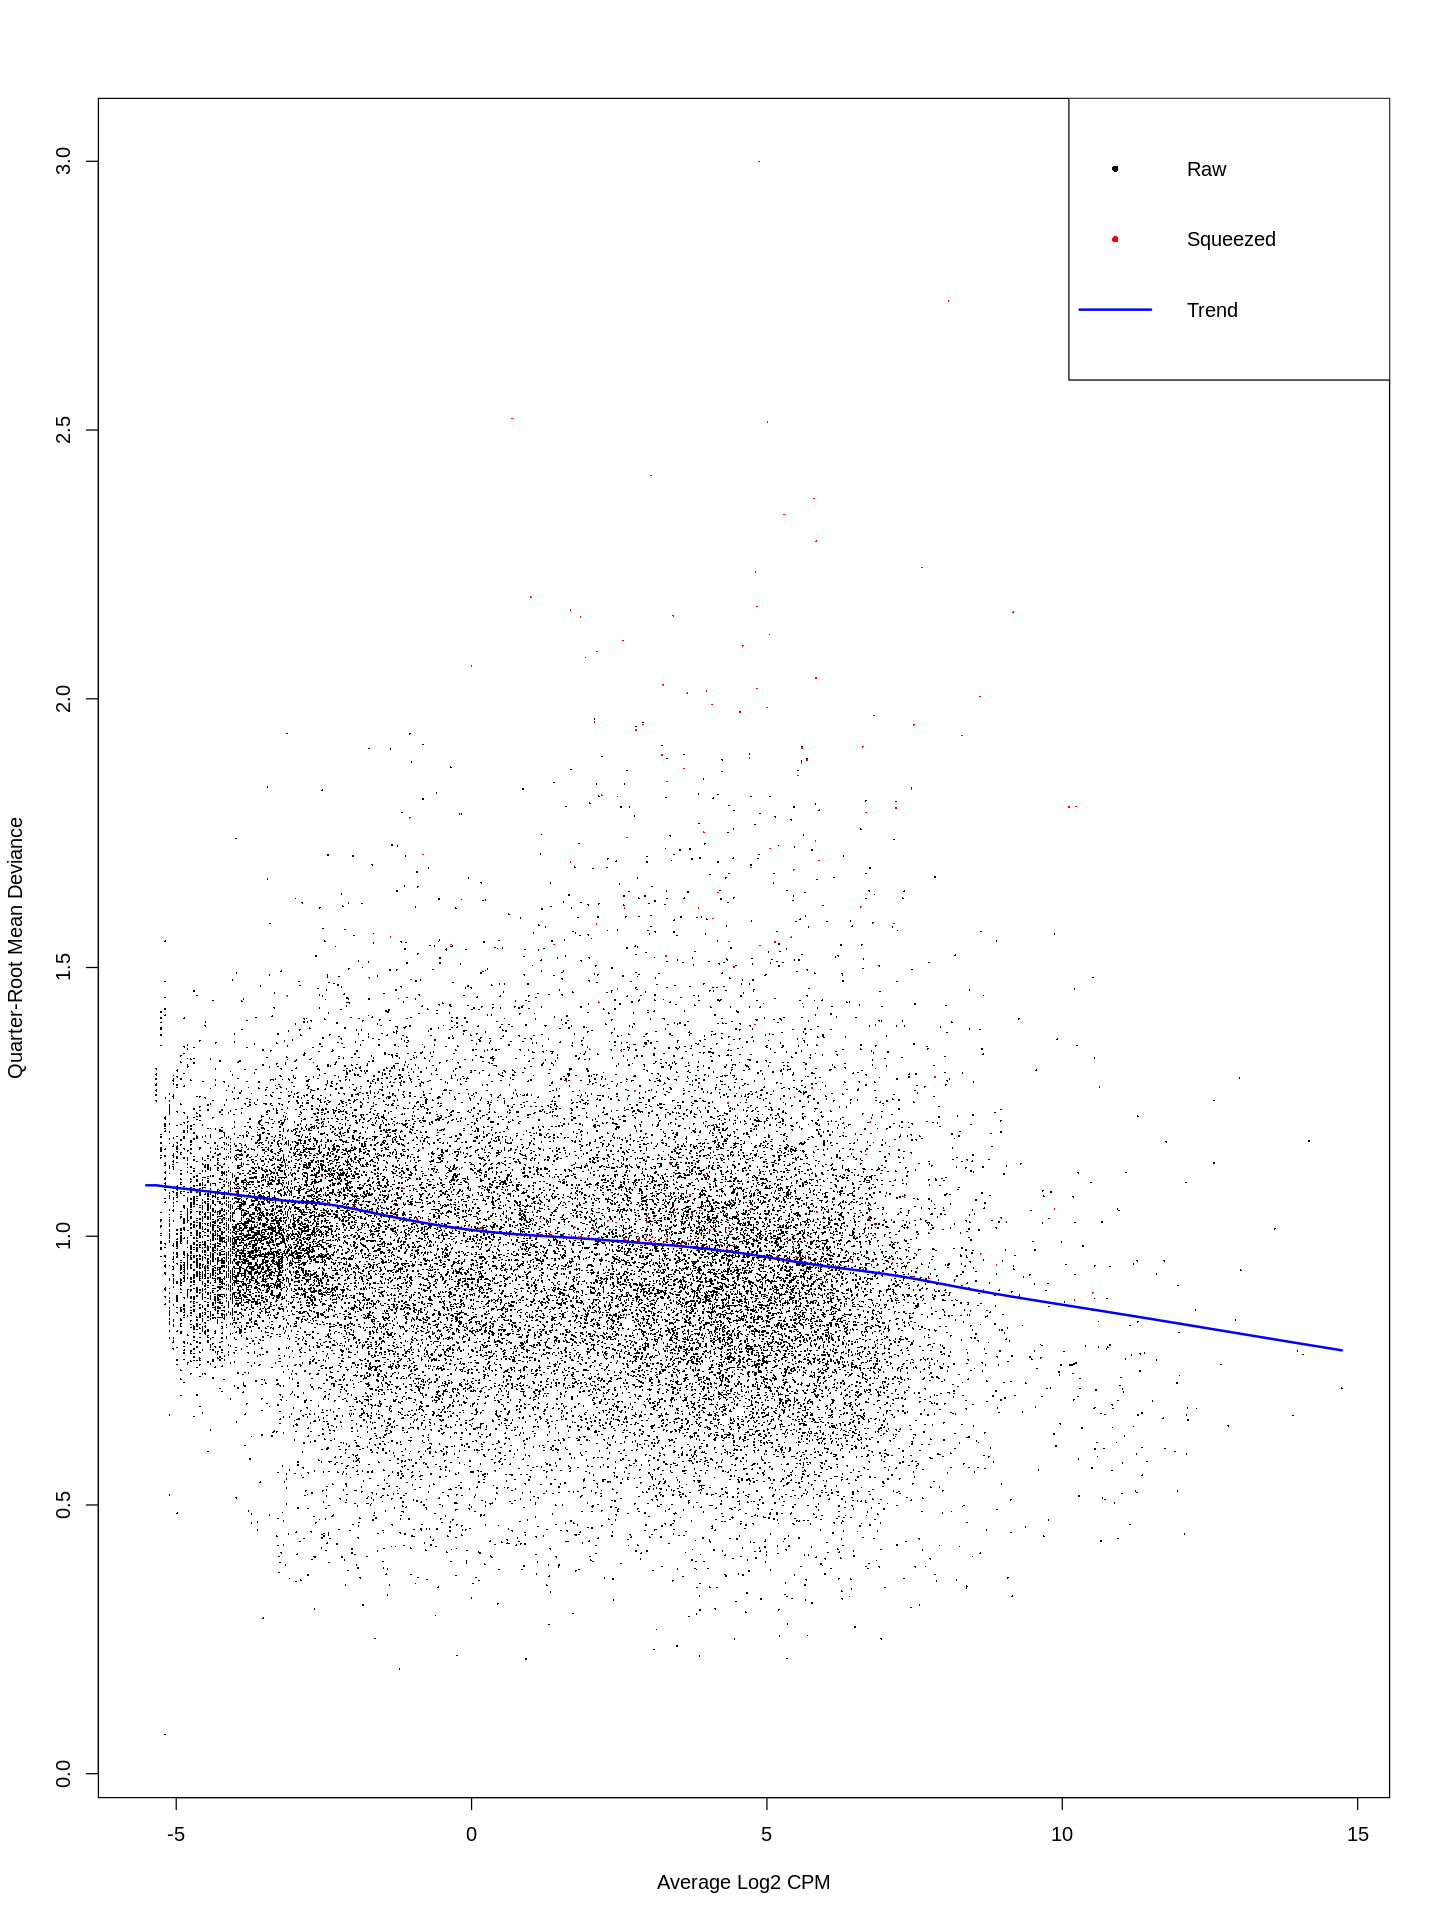

  logFC logCPM   F  PValue   de_gene target   subclass      label plasmid
1 -0.98    6.3 427 1.3e-94     PLIN3  PLIN3 de_control Control DE PLIN3-2
2 -1.43    2.0  52 5.4e-13 TNFAIP8L1  PLIN3 de_control Control DE PLIN3-2
3  0.15   11.2  29 6.2e-08     RPL36  PLIN3 de_control Control DE PLIN3-2
4 -0.82    2.3  26 3.1e-07     UHRF1  PLIN3 de_control Control DE PLIN3-2
5 -0.23    4.8  12 4.4e-04    HDGFL2  PLIN3 de_control Control DE PLIN3-2
6  0.39    2.7  11 8.1e-04     FEM1A  PLIN3 de_control Control DE PLIN3-2
-------------------------------------------------------

TKT : TKT-1a,TKT-1b 
TKT-1a   674 
TKT-1b   683 
[1] "TKT-1a" "TKT-1b"
[1] "TKT-1a" "TKT-2a" "TKT-1b" "TKT-2b"
Vector+ = 901 ; Target- = 25166 ; All = 27142 

donor0 donor1 donor2 donor3 
   224    193    277    207 
[1] 0.0015


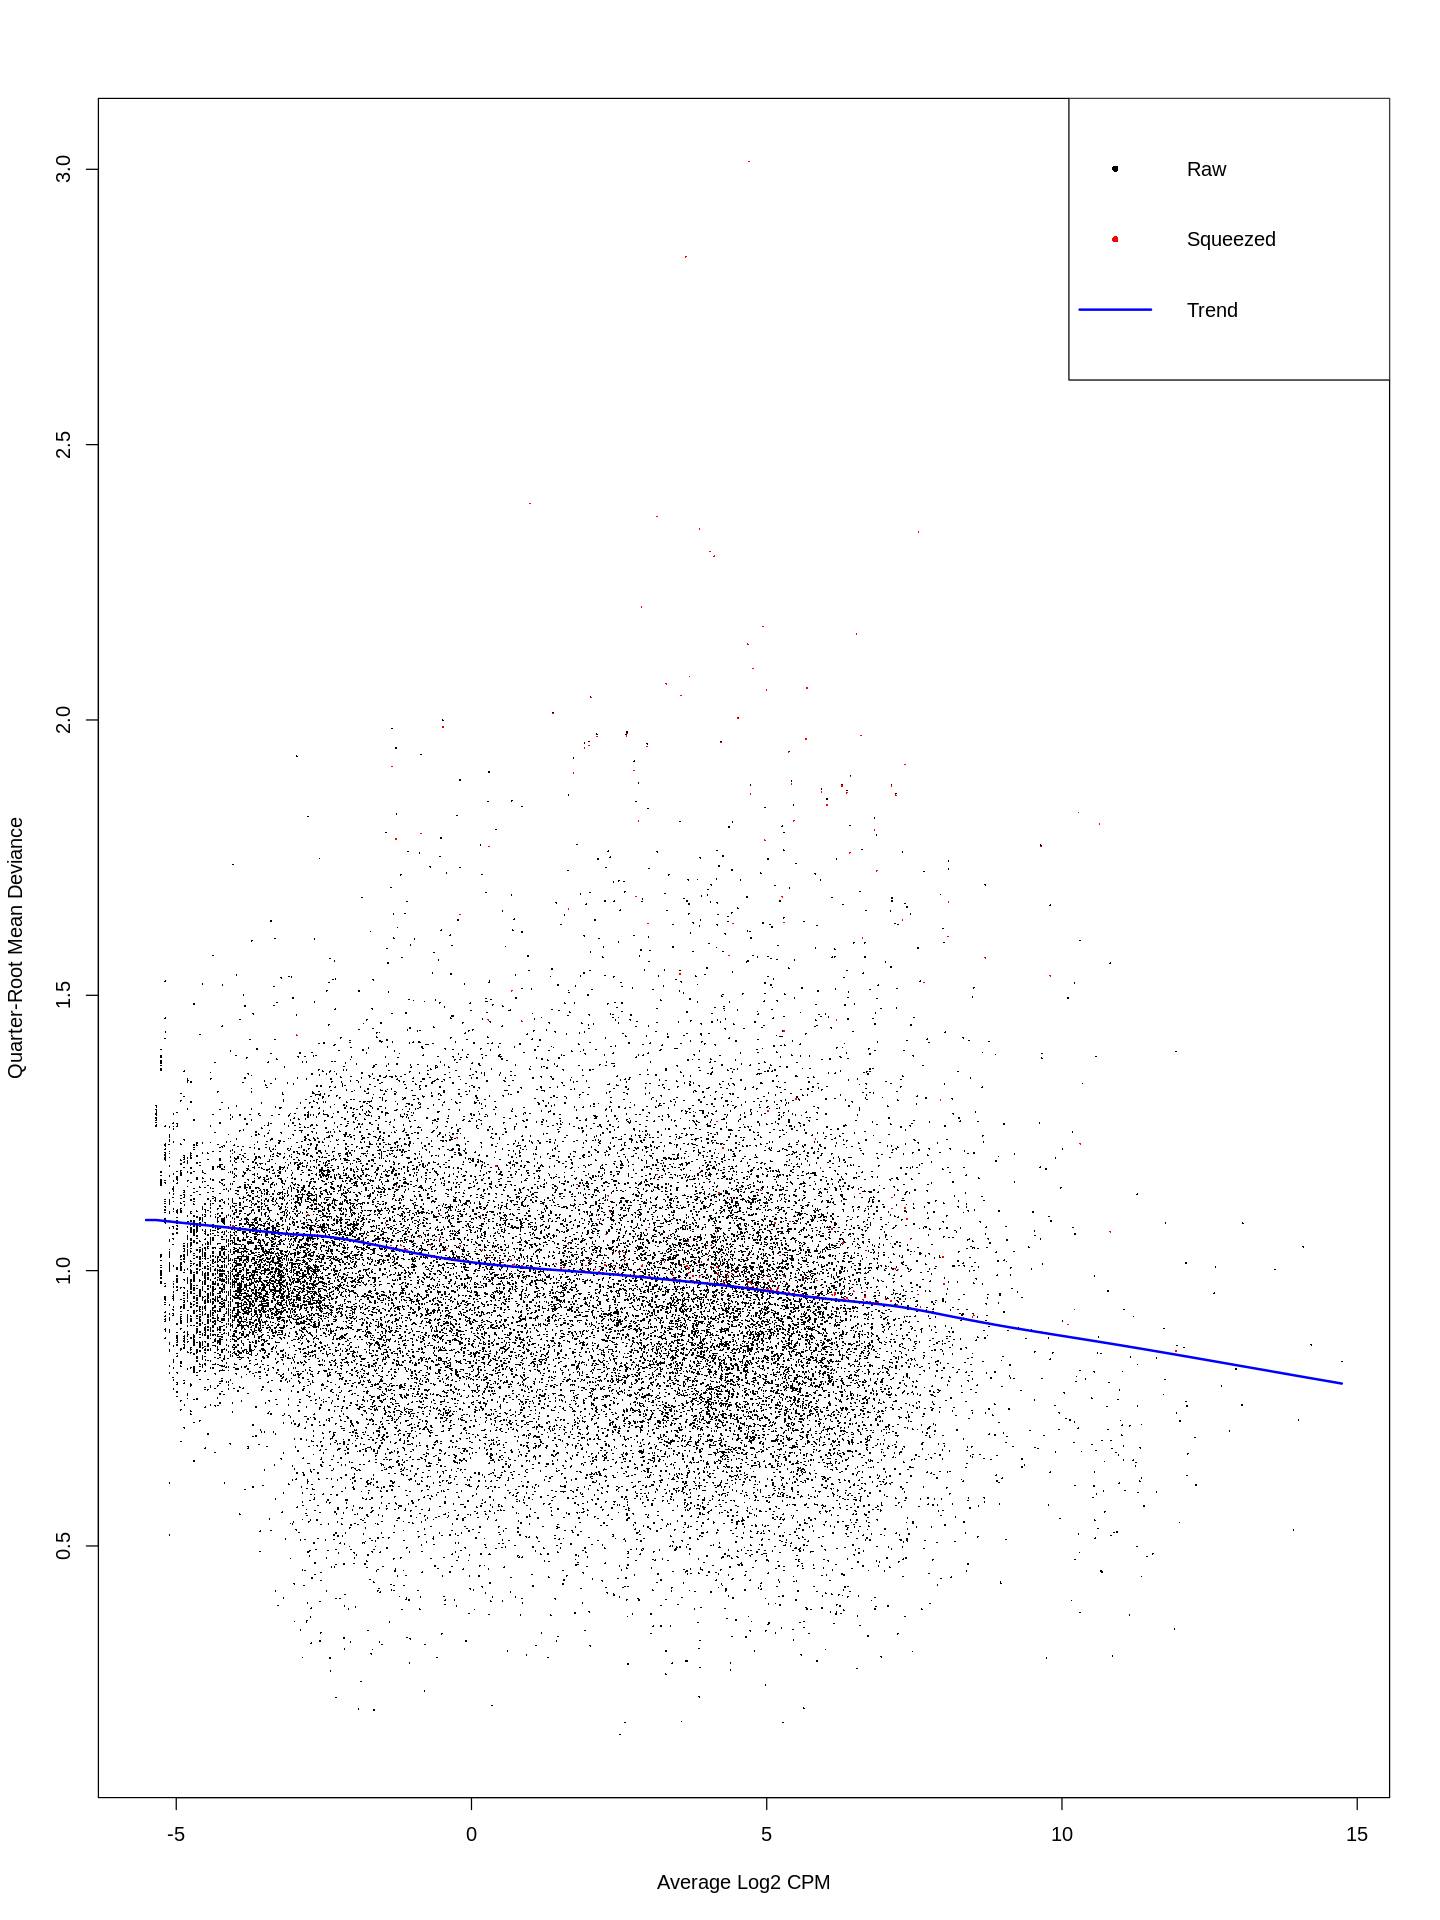

  logFC logCPM     F  PValue de_gene target   subclass      label plasmid
1 -0.69   8.19 358.6 7.5e-80     TKT    TKT de_control Control DE   TKT-1
2 -0.21   4.32   7.9 4.9e-03  NT5DC2    TKT de_control Control DE   TKT-1
3 -0.24   3.82   6.8 9.0e-03 CACNA1D    TKT de_control Control DE   TKT-1
4 -0.69   0.38   4.5 3.3e-02  IL17RB    TKT de_control Control DE   TKT-1
5  3.14  -5.25   2.0 1.6e-01  SEMA3G    TKT de_control Control DE   TKT-1
6  0.12   3.43   1.5 2.3e-01    BAP1    TKT de_control Control DE   TKT-1
-------------------------------------------------------

TKT : TKT-2a,TKT-2b 
TKT-2a   872 
TKT-2b   911 
[1] "TKT-2a" "TKT-2b"
[1] "TKT-1a" "TKT-2a" "TKT-1b" "TKT-2b"
Vector+ = 1167 ; Target- = 25166 ; All = 27142 

donor0 donor1 donor2 donor3 
   271    251    363    282 
[1] 0.0015


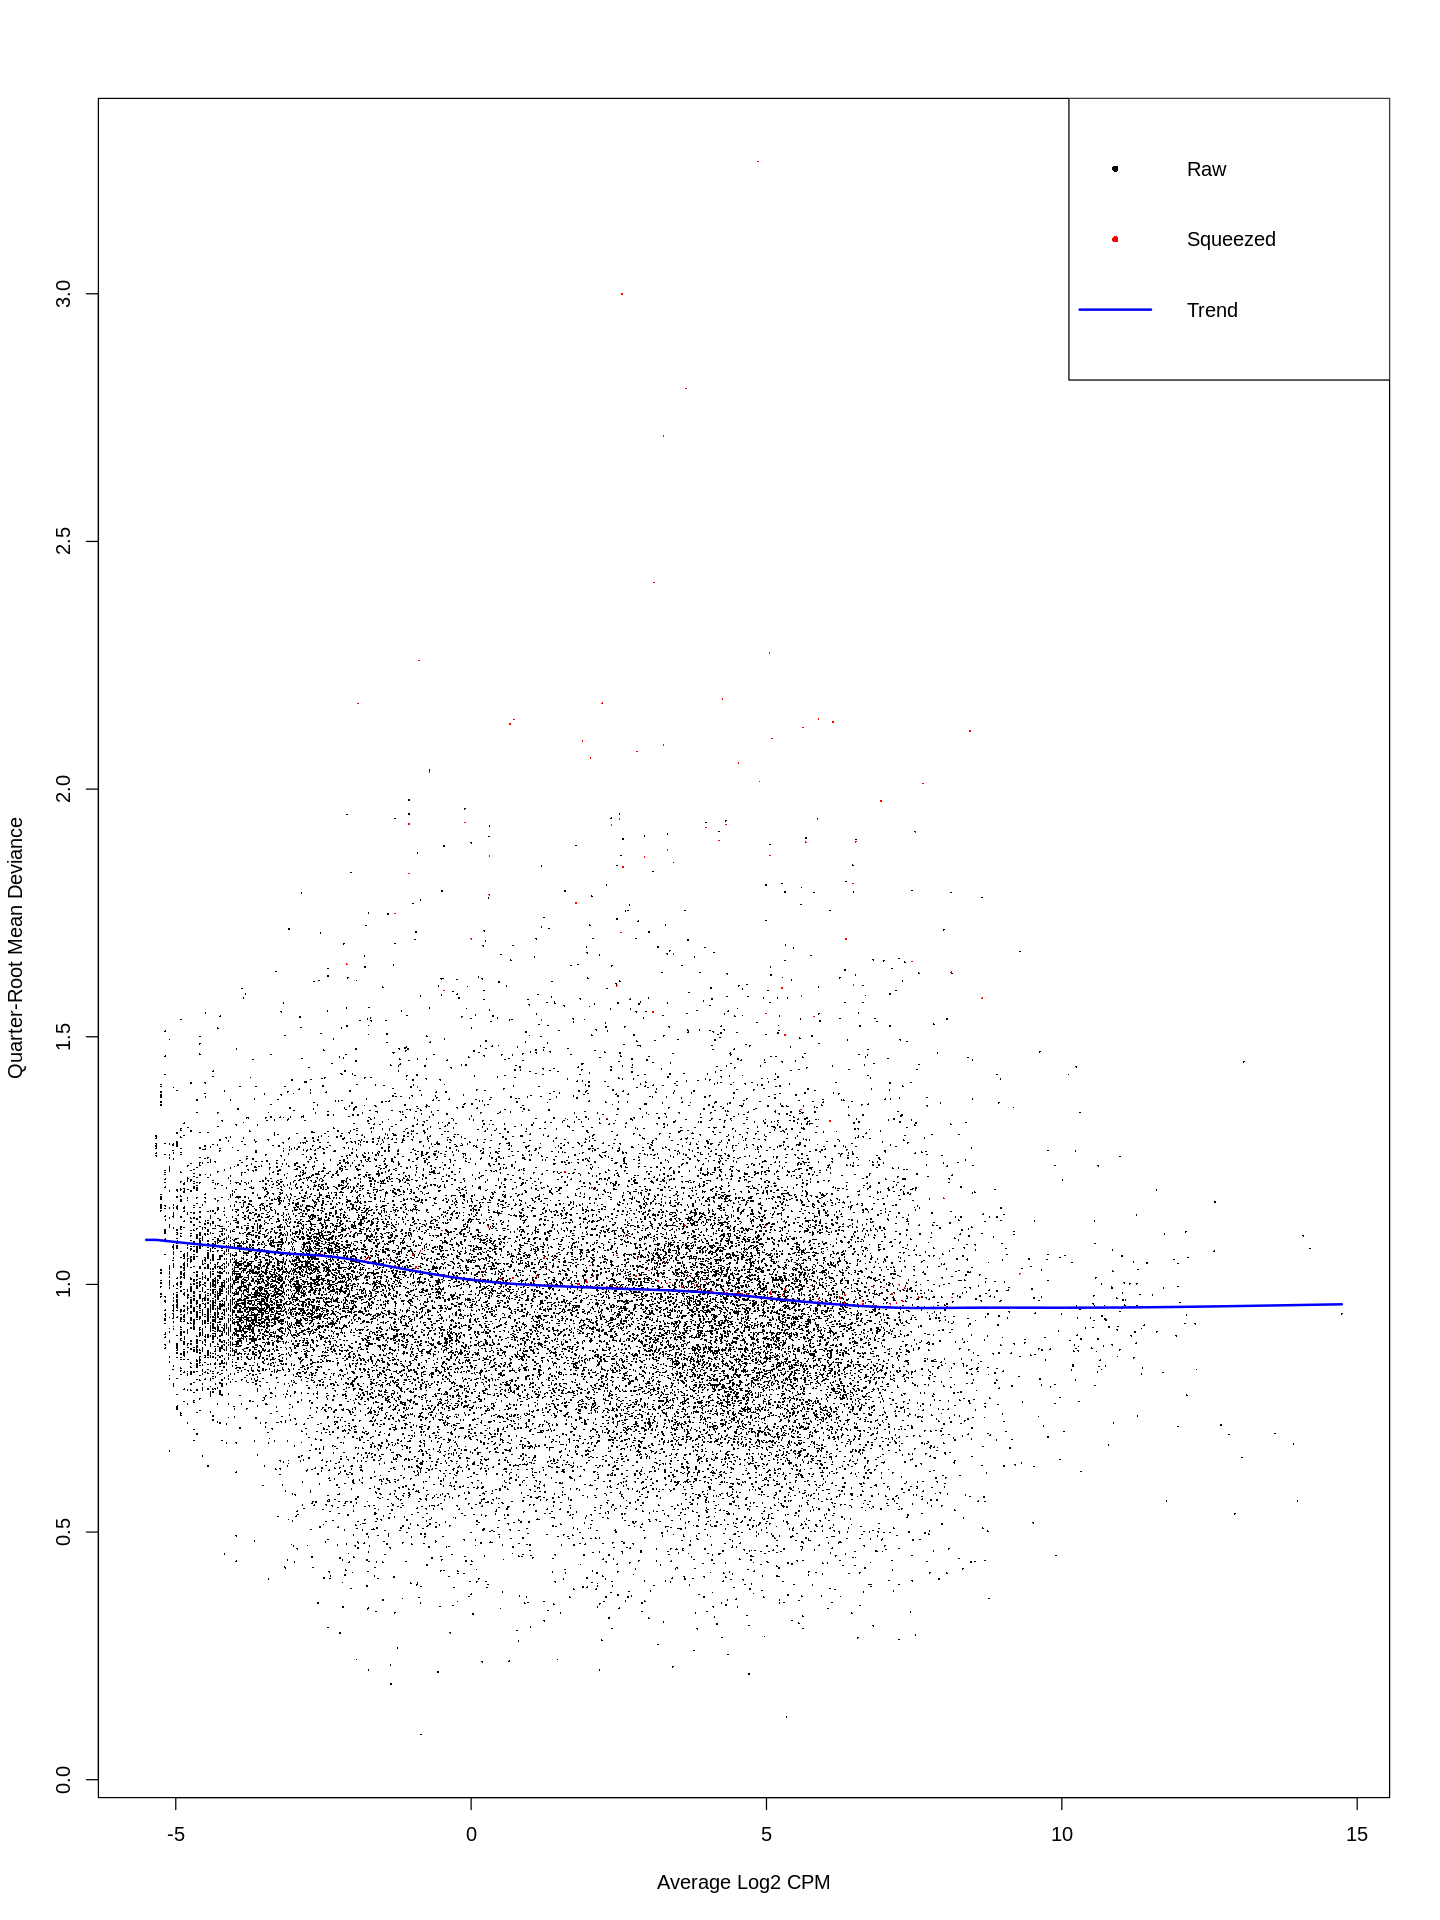

  logFC logCPM     F   PValue de_gene target   subclass      label plasmid
1 -0.75    8.2 469.2 7.8e-104     TKT    TKT de_control Control DE   TKT-2
2 -0.36    3.8  19.0  1.3e-05 CACNA1D    TKT de_control Control DE   TKT-2
3 -0.17    4.8   8.3  4.0e-03  GLT8D1    TKT de_control Control DE   TKT-2
4  0.95   -1.0   7.1  7.7e-03   ITIH4    TKT de_control Control DE   TKT-2
5 -0.17    4.3   6.6  1.0e-02  NT5DC2    TKT de_control Control DE   TKT-2
6 -0.13    5.0   6.0  1.4e-02   DCP1A    TKT de_control Control DE   TKT-2
-------------------------------------------------------

LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   912 
LGALS3-1b   864 
[1] "LGALS3-1a" "LGALS3-1b"
[1] "LGALS3-1a" "LGALS3-2a" "LGALS3-1b" "LGALS3-2b"
Vector+ = 1166 ; Target- = 25026 ; All = 27142 

donor0 donor1 donor2 donor3 
   297    214    356    299 
[1] 0.0013


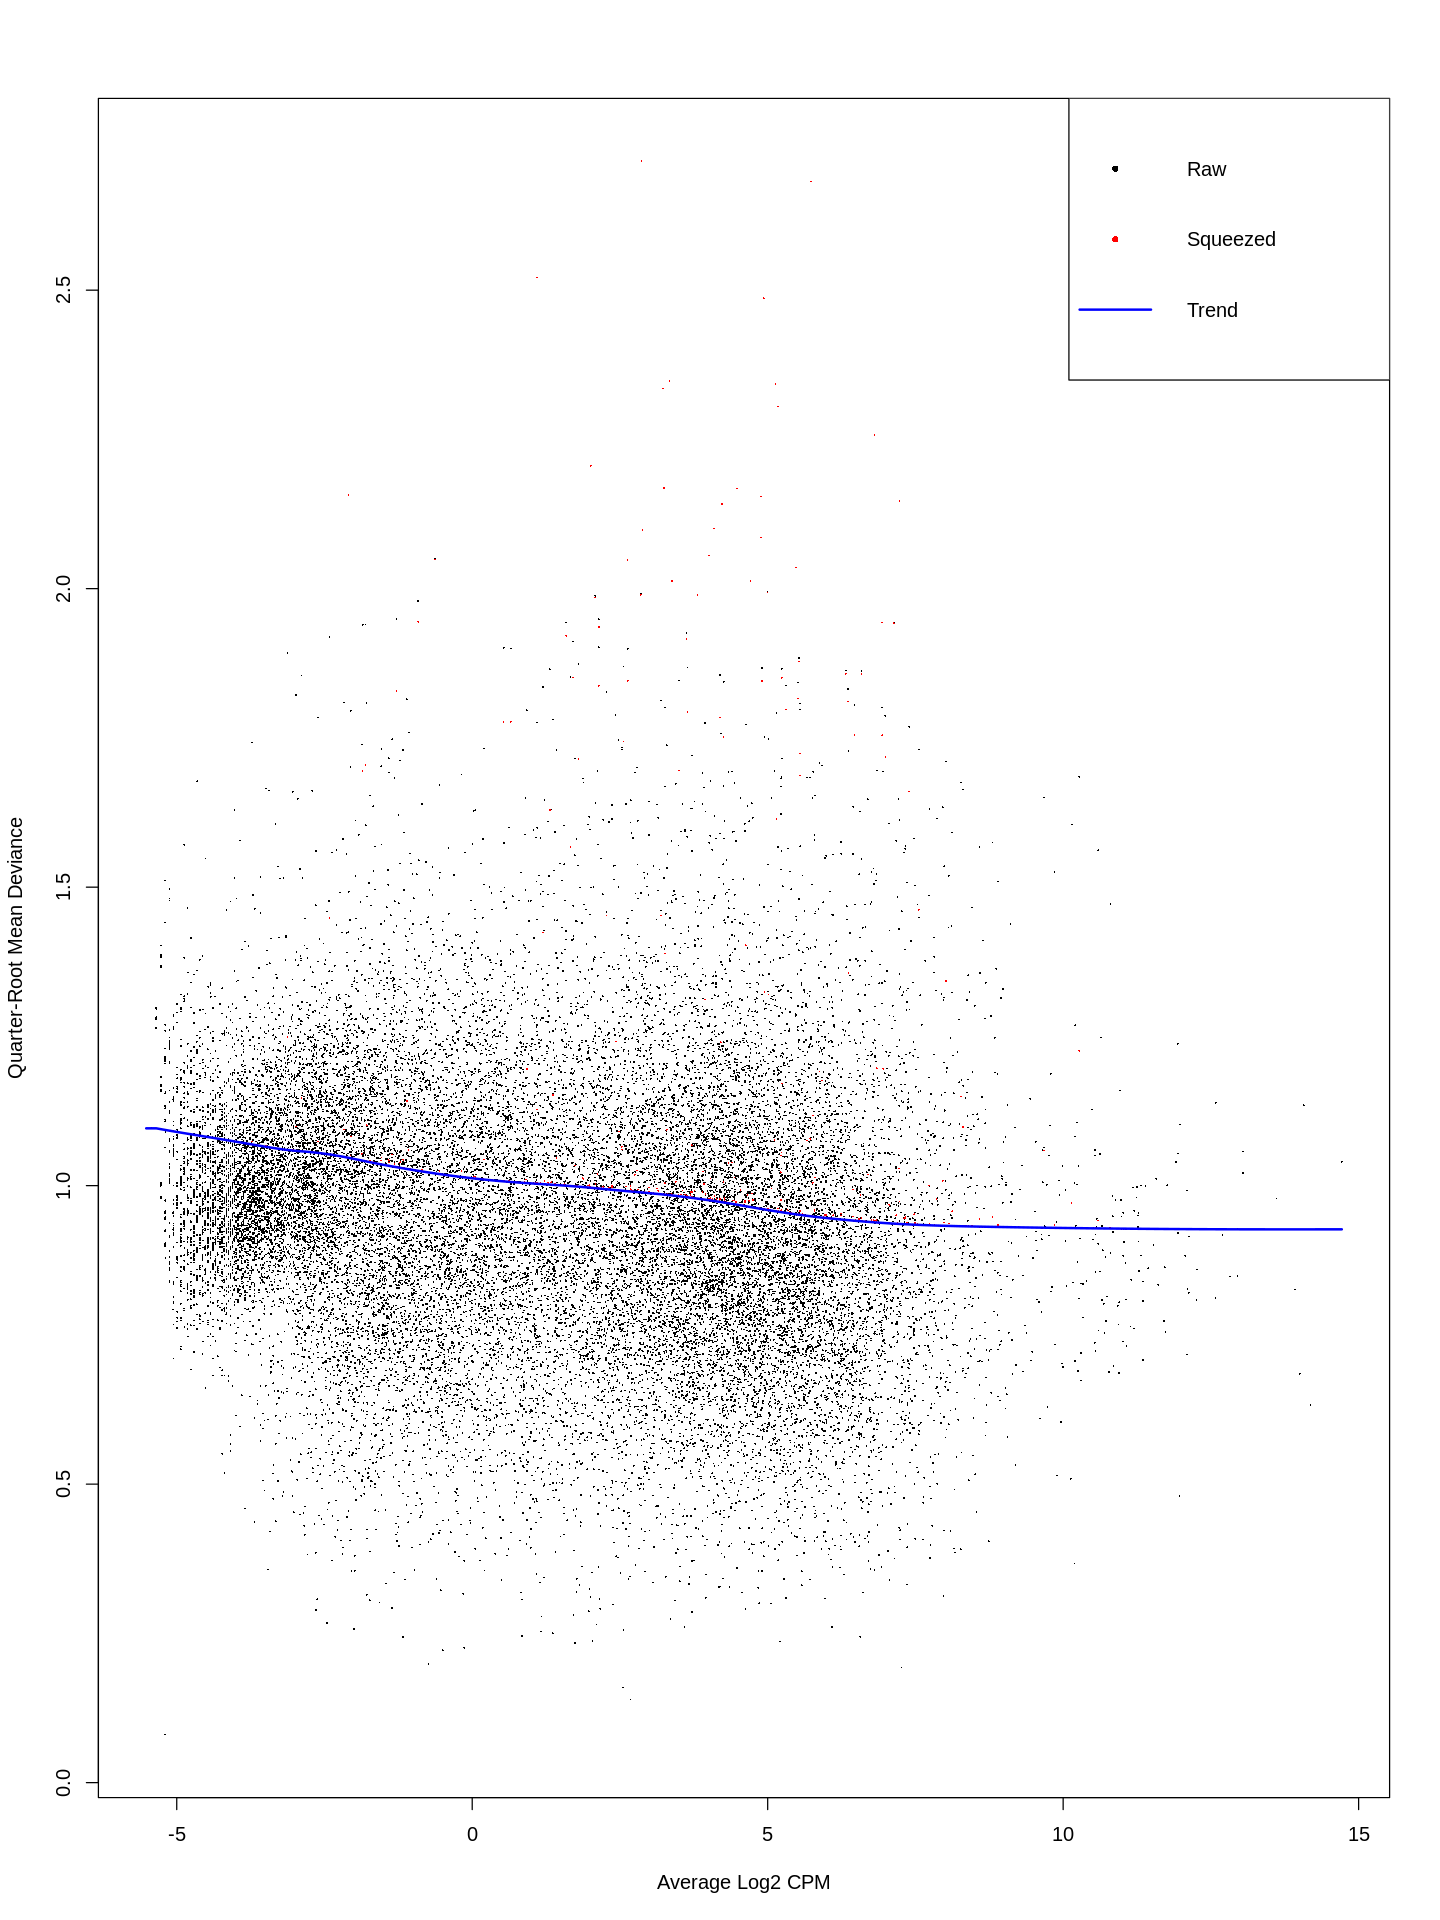

  logFC logCPM      F  PValue   de_gene target   subclass      label  plasmid
1 -1.35    7.9 1709.5 0.0e+00    LGALS3 LGALS3 de_control Control DE LGALS3-1
2 -1.09    3.7  131.8 2.8e-30    DLGAP5 LGALS3 de_control Control DE LGALS3-1
3 -0.94    4.2  134.6 3.4e-25     CDKN3 LGALS3 de_control Control DE LGALS3-1
4 -0.42    3.5   20.4 6.2e-06     WDHD1 LGALS3 de_control Control DE LGALS3-1
5  0.22    3.9    8.9 2.8e-03    CGRRF1 LGALS3 de_control Control DE LGALS3-1
6 -0.11    5.9    7.3 6.9e-03 MAPK1IP1L LGALS3 de_control Control DE LGALS3-1
-------------------------------------------------------

LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   811 
LGALS3-2b   783 
[1] "LGALS3-2a" "LGALS3-2b"
[1] "LGALS3-1a" "LGALS3-2a" "LGALS3-1b" "LGALS3-2b"
Vector+ = 1072 ; Target- = 25026 ; All = 27142 

donor0 donor1 donor2 donor3 
   267    214    327    264 
[1] 0.0018


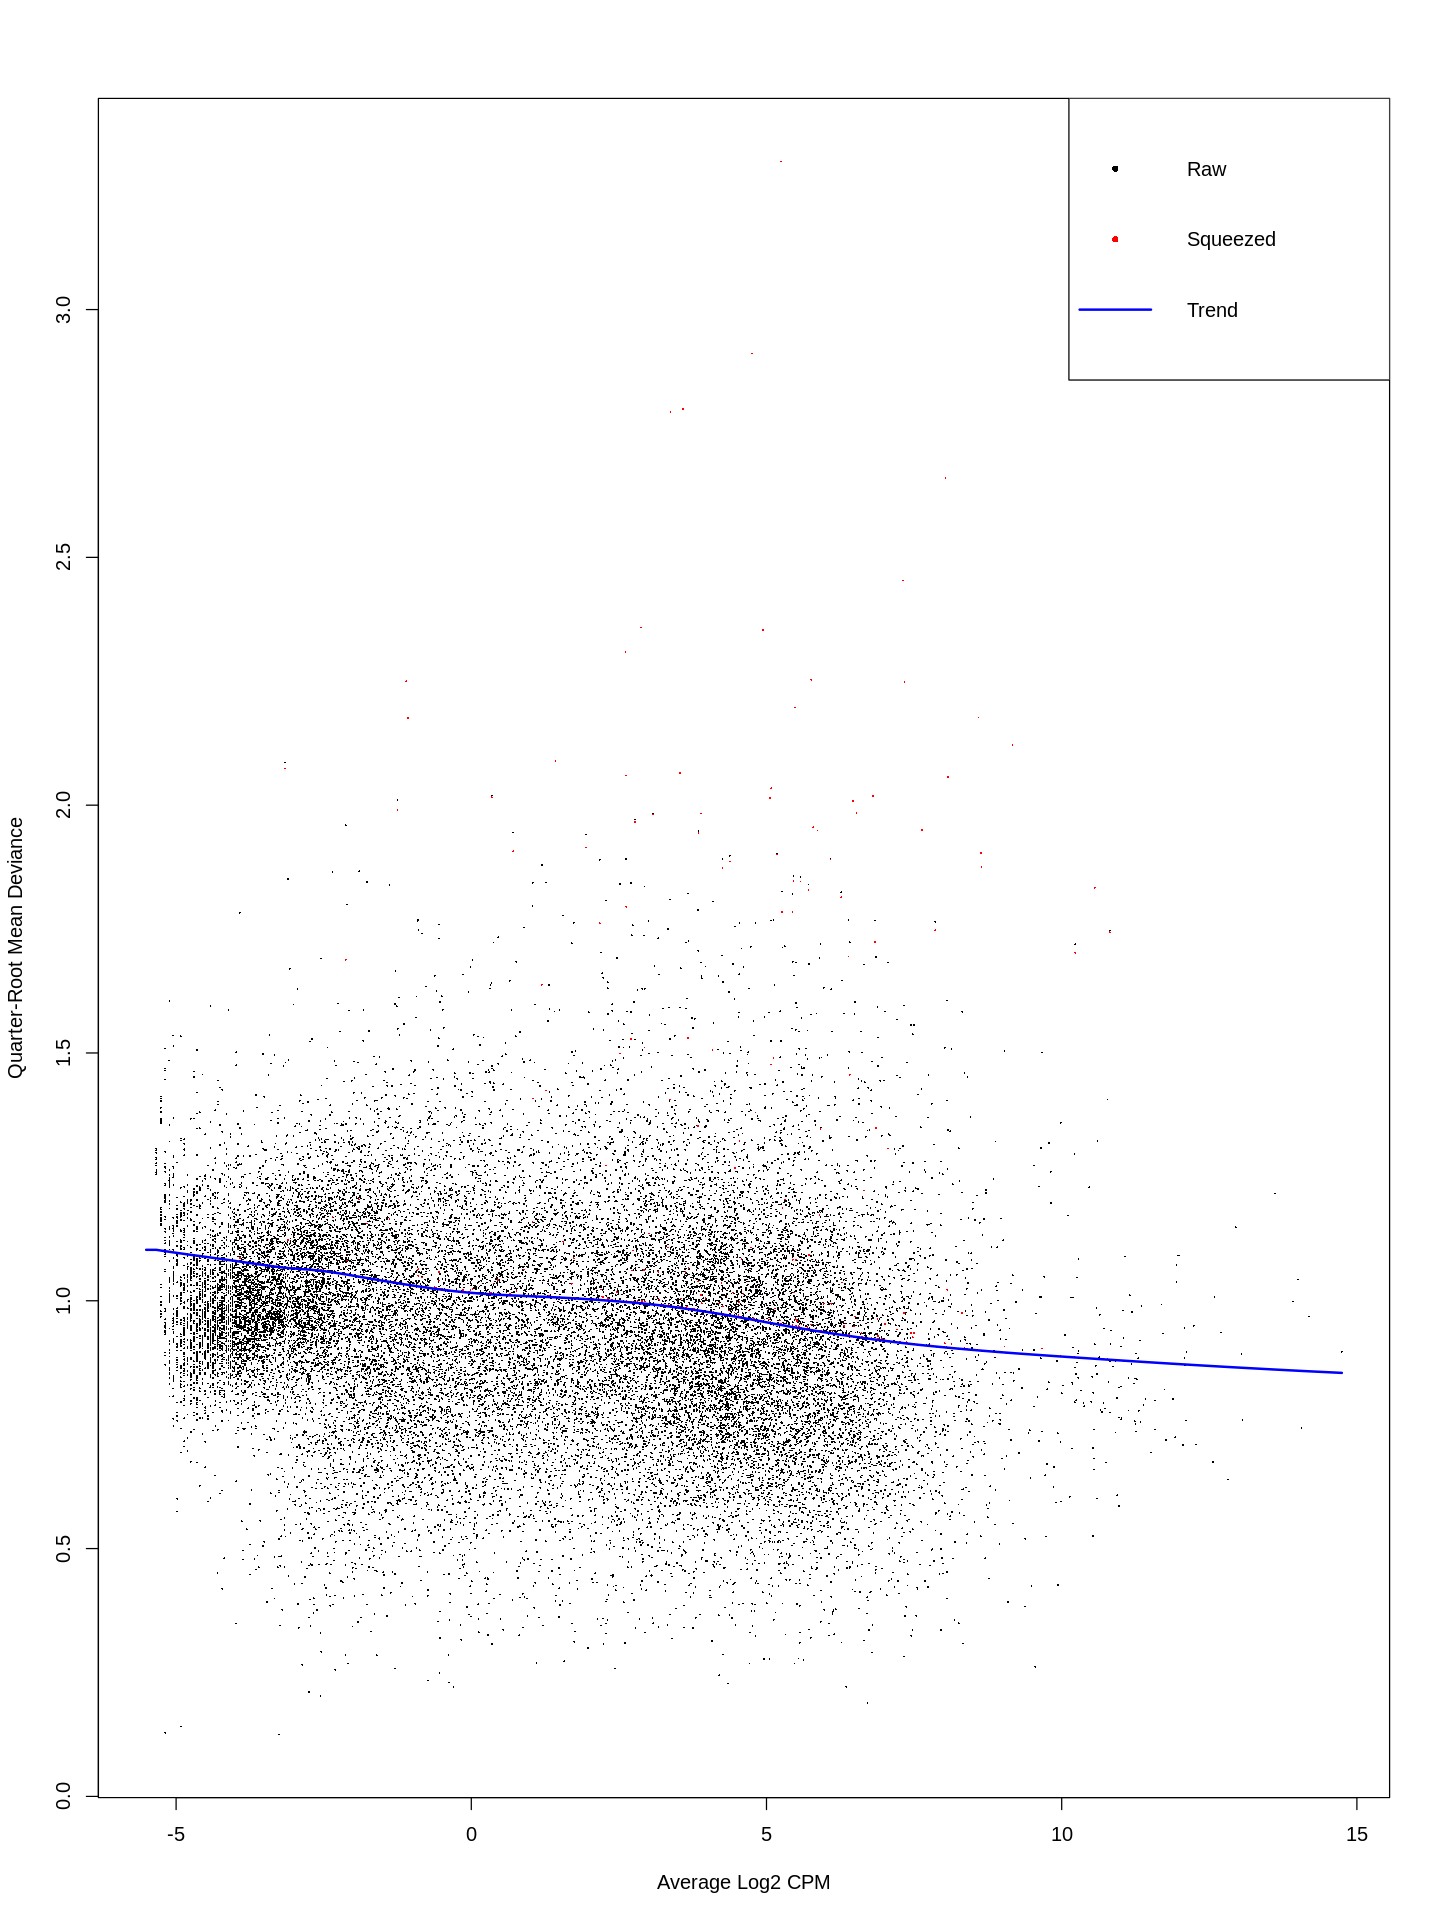

   logFC logCPM      F   PValue   de_gene target   subclass      label  plasmid
1 -1.276    7.9 1319.2 9.0e-285    LGALS3 LGALS3 de_control Control DE LGALS3-2
2 -0.691    4.2   76.2  2.7e-18     CDKN3 LGALS3 de_control Control DE LGALS3-2
3 -0.807    3.7   73.2  1.2e-17    DLGAP5 LGALS3 de_control Control DE LGALS3-2
4  1.135   -1.5    6.5  1.1e-02 LINC00520 LGALS3 de_control Control DE LGALS3-2
5 -0.221    3.5    5.7  1.7e-02     WDHD1 LGALS3 de_control Control DE LGALS3-2
6  0.086    6.6    4.8  2.8e-02    SAMD4A LGALS3 de_control Control DE LGALS3-2
-------------------------------------------------------

CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   968 
CSTB-1b   946 
[1] "CSTB-1a" "CSTB-1b"
[1] "CSTB-1a" "CSTB-2a" "CSTB-1b" "CSTB-2b"
Vector+ = 1254 ; Target- = 24805 ; All = 27142 

donor0 donor1 donor2 donor3 
   288    271    385    310 
[1] 0.0015


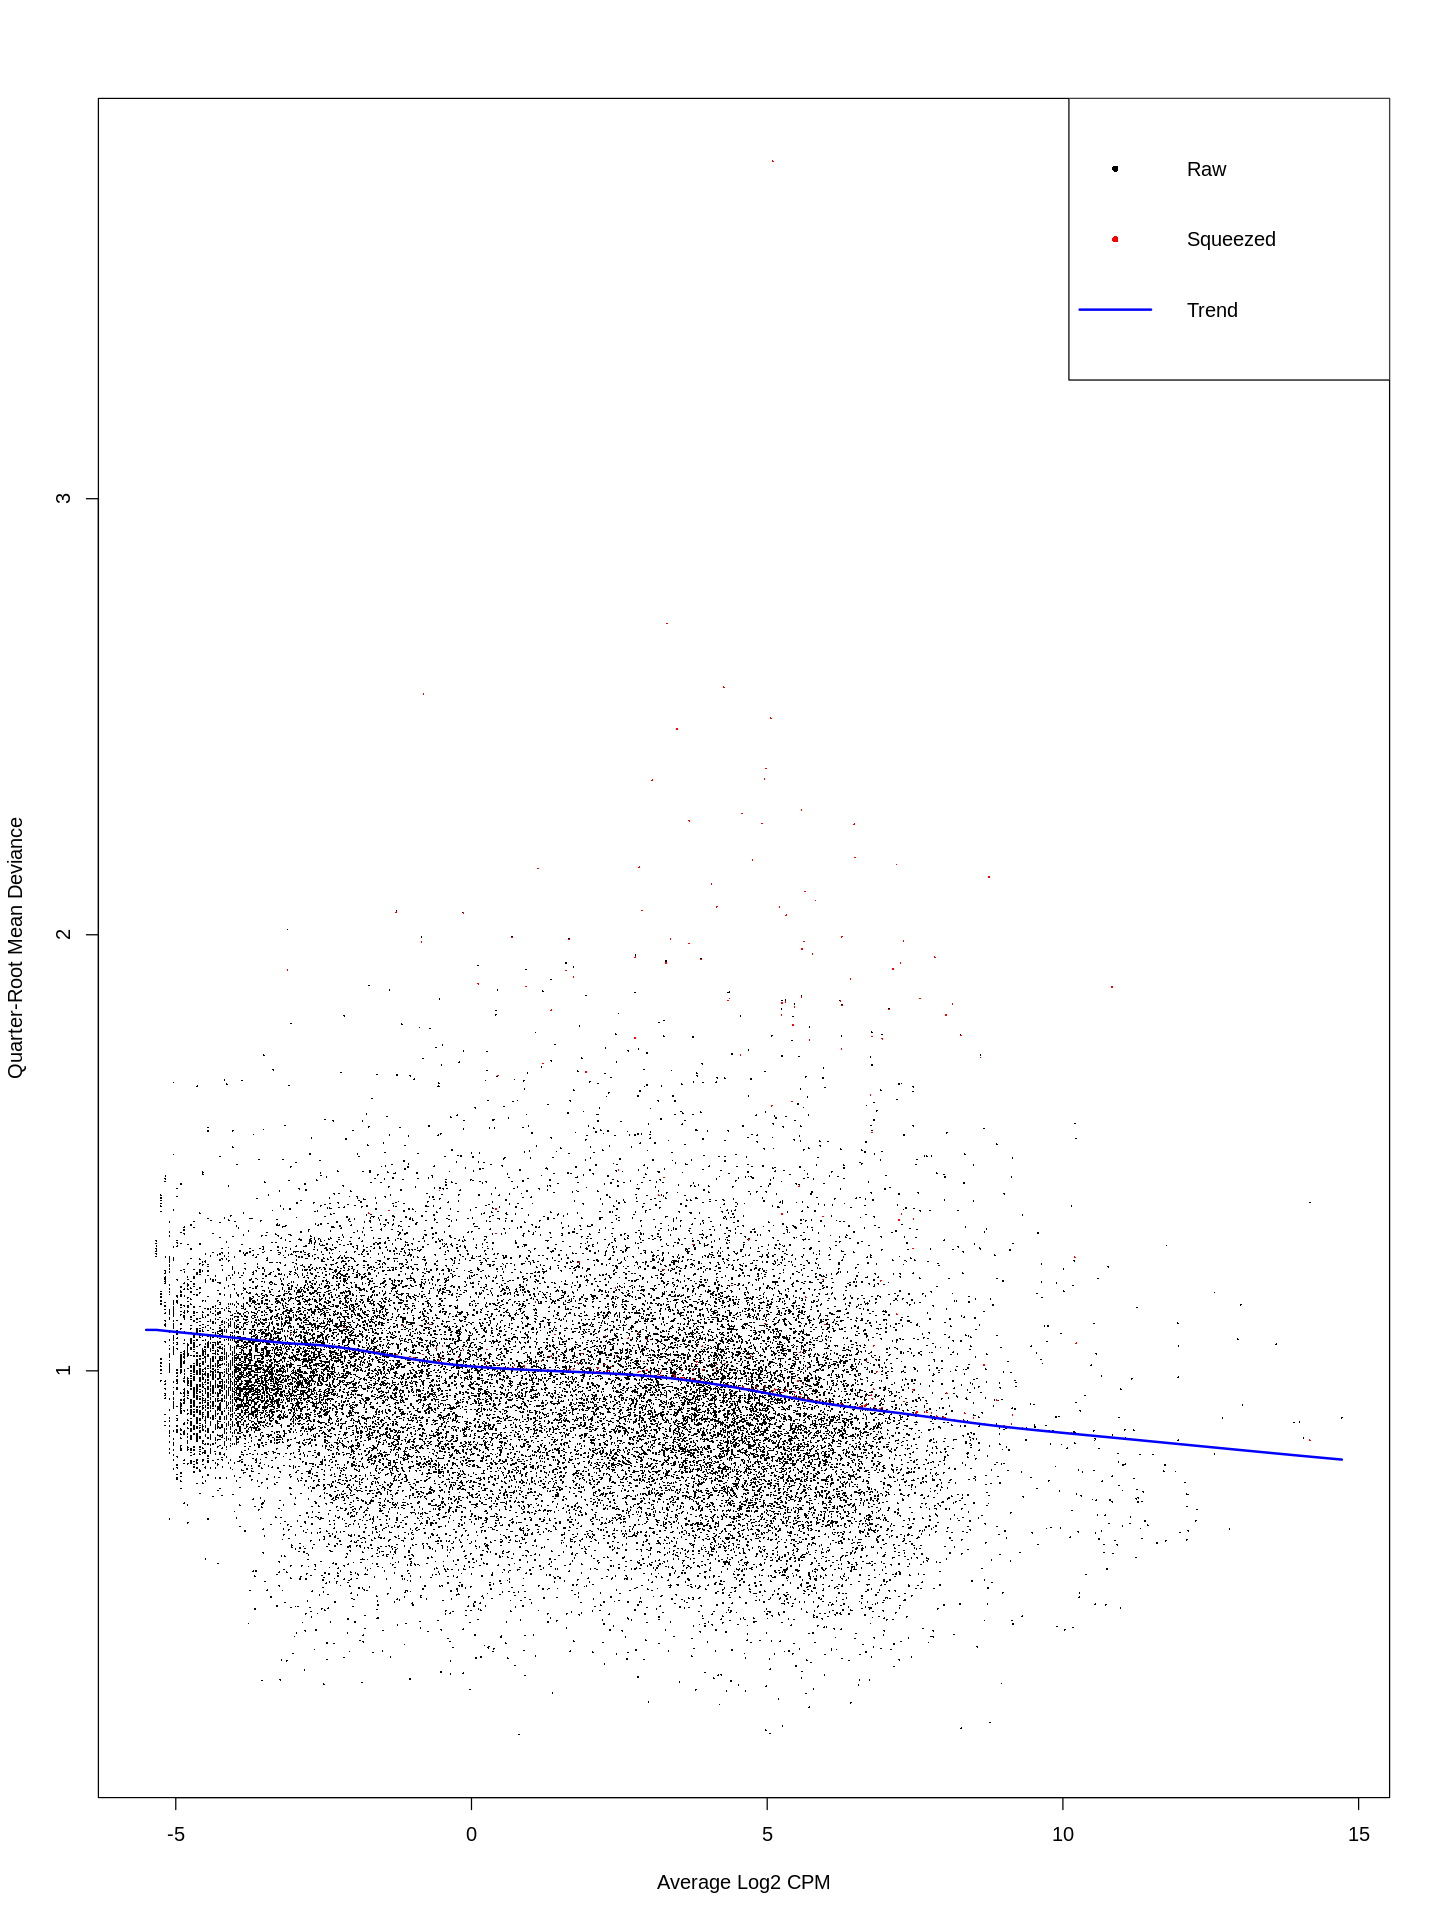

  logFC logCPM     F  PValue   de_gene target   subclass      label plasmid
1 -0.44    8.3 209.7 1.8e-47      CSTB   CSTB de_control Control DE  CSTB-1
2 -0.24    6.6  42.2 8.3e-11      PDXK   CSTB de_control Control DE  CSTB-1
3 -5.89   -3.4   4.4 3.5e-02  ERVH48-1   CSTB de_control Control DE  CSTB-1
4  3.61   -5.2   4.2 4.0e-02 LINC01679   CSTB de_control Control DE  CSTB-1
5  4.21   -5.4   3.8 5.3e-02 LINC00322   CSTB de_control Control DE  CSTB-1
6 -5.06   -3.9   2.4 1.2e-01     AATBC   CSTB de_control Control DE  CSTB-1
-------------------------------------------------------

CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   931 
CSTB-2b   904 
[1] "CSTB-2a" "CSTB-2b"
[1] "CSTB-1a" "CSTB-2a" "CSTB-1b" "CSTB-2b"
Vector+ = 1216 ; Target- = 24805 ; All = 27142 

donor0 donor1 donor2 donor3 
   273    250    380    313 
[1] 0.0017


In [182]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_targets = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_TARGETS.txt", sep = "\t", header = T, strip.white = T)
#df_targets = unique(filter(df_guide, subclass=='ckd_de'))
#df_targets = unique(filter(df_guide, class=='targeting'))
#df_targets = unique(filter(df_guide, alias=='PLIN3'))
pos_label = "vector_positive"
neg_label = "target_negative"

df_neighbor_de = NULL
df_cell_counts = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01
n_tests = 0

# Main loop
for (i in 1:nrow(df_targets)) {
    is_de = FALSE
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    vector_id       = gsub("a", "", df_targets[i, 'guide1'])
    diffexed_gene   = df_targets[i, 'diffexed_gene']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    # Check if "target" is not a DE gene
    if (!str_detect(target, regex("^DE\\d+$"))) {
        is_de = FALSE
        neighbors = neighbors_list[[target]]
    } else {
        is_de = TRUE
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if ((target %in% guides_to_skip) | length(neighbors) == 0) {
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    guides_on_plasmid = unlist(as.list(t(df_targets[i, c('guide1', 'guide2')])))
    cat(blue(target, ":"), paste(guides_on_plasmid, collapse = ","), "\n")

    seurat_dummy <- mark_vector_pos_target_neg(
        seurat_rna,
        perturbed_cells_by_guide,
        guides_on_plasmid,
        guides_4_target,
        print_counts = T,
        pos_label = "vector_positive",
        neg_label = "target_negative"
    )
    
    # Process cells with the given target and perturbation status
    if("vector_positive" %in% levels((Idents(seurat_dummy)))) {
        dummy <- process_target_cells(
            seurat_dummy, target, vector_id, is_de, neighbors, diffexed_gene, 
            perturbed_cells_by_guide, guides_on_plasmid, guides_4_target, 
            df_cell_counts, df_neighbor_de, pos_label, neg_label, target_subclass
        )
        df_cell_counts = dummy$df_cell_counts
        df_neighbor_de = dummy$df_neighbor_de
        n_tests = n_tests + dummy$n_tests_performed
    } else {
        cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
    }
}

In [ ]:
df_guide %>% filter(subclass == "ckd_de")

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label,diffexed_gene
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs2823139,DE1-1a,DE1-1b,DE1,ckd_de,targeting,rs2823139,CKD DE,
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE,
rs7642977,DE2-1a,DE2-1b,DE2,ckd_de,targeting,rs7642977,CKD DE,
rs7642977,DE2-2a,DE2-2b,DE2,ckd_de,targeting,rs7642977,CKD DE,
rs78581838,DE3-1a,DE3-1b,DE3,ckd_de,targeting,rs78581838,CKD DE,
rs78581838,DE3-2a,DE3-2b,DE3,ckd_de,targeting,rs78581838,CKD DE,
rs7707989,DE4-1a,DE4-1b,DE4,ckd_de,targeting,rs7707989,CKD DE,CCNB1
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE,CCNB1
rs527616,DE5-1a,DE5-1b,DE5,ckd_de,targeting,rs527616,CKD DE,


### Correct p-values by total number of comparisons

In [ ]:
#n_tests = length(flatten(neighbors_list)) * length(df_targets)
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$PValue,
    method = "bonferroni",
    n = n_tests
)

[1] 1503


In [ ]:
head(df_neighbor_de)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,4.0e-204
2,-0.33,6.7,76,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1,3.8e-15
3,-0.20,6.7,27,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1,2.7e-04
4,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,2.3e-03
5,0.21,5.4,19,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1,2.2e-02
6,-0.36,3.5,15,1.2e-04,FANCI,ANPEP,tss,Control TSS,CD13-1,1.9e-01


In [ ]:
df_cell_counts_backup = df_cell_counts

In [ ]:
head(df_cell_counts)

,Row.names,cpm,target,vector,label,subclass,group,lib.size,norm.factors,sample,cluster
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>
1,donor0_cluster0,56,ANPEP,CD13-1,donor0_cluster0,tss,1,6.9e+06,1,donor0,0
2,donor0_cluster1,152,ANPEP,CD13-1,donor0_cluster1,tss,1,1.6e+08,1,donor0,1
3,donor1_cluster0,68,ANPEP,CD13-1,donor1_cluster0,tss,1,7.9e+06,1,donor1,0
4,donor1_cluster1,143,ANPEP,CD13-1,donor1_cluster1,tss,1,1.7e+08,1,donor1,1
5,donor2_cluster0,68,ANPEP,CD13-1,donor2_cluster0,tss,1,1.2e+07,1,donor2,0
6,donor2_cluster1,155,ANPEP,CD13-1,donor2_cluster1,tss,1,2.2e+08,1,donor2,1


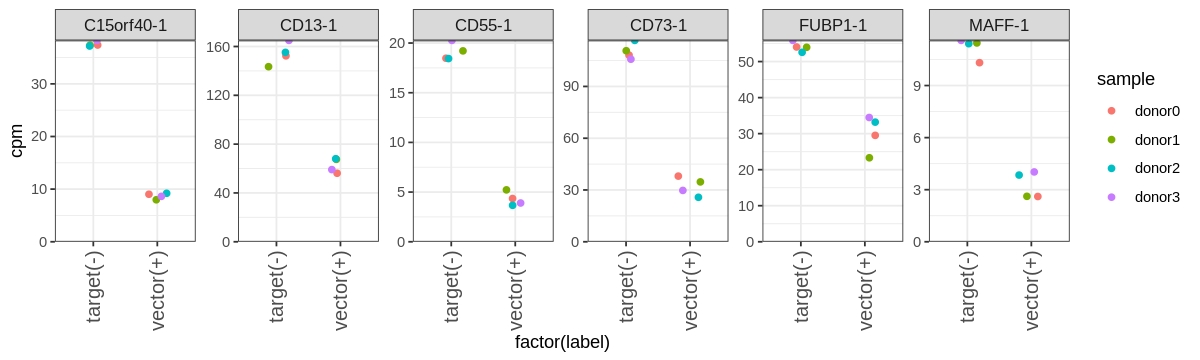

Warning message:
"Removed 5 rows containing missing values (`geom_point()`)."


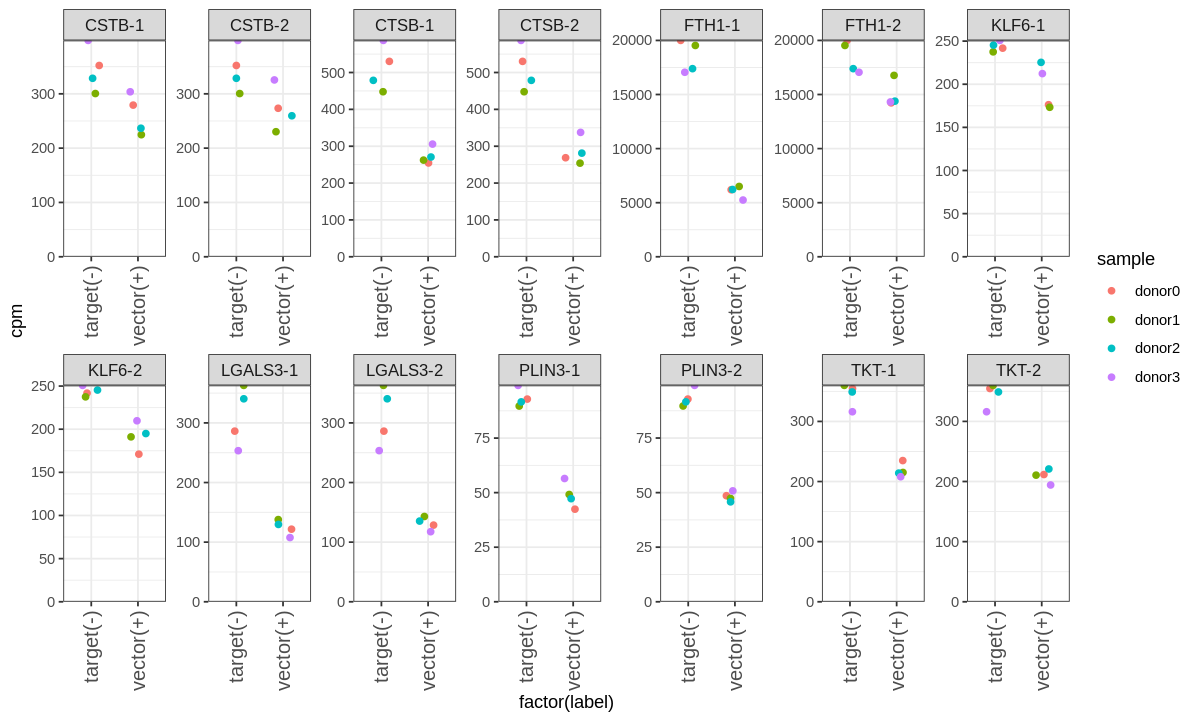

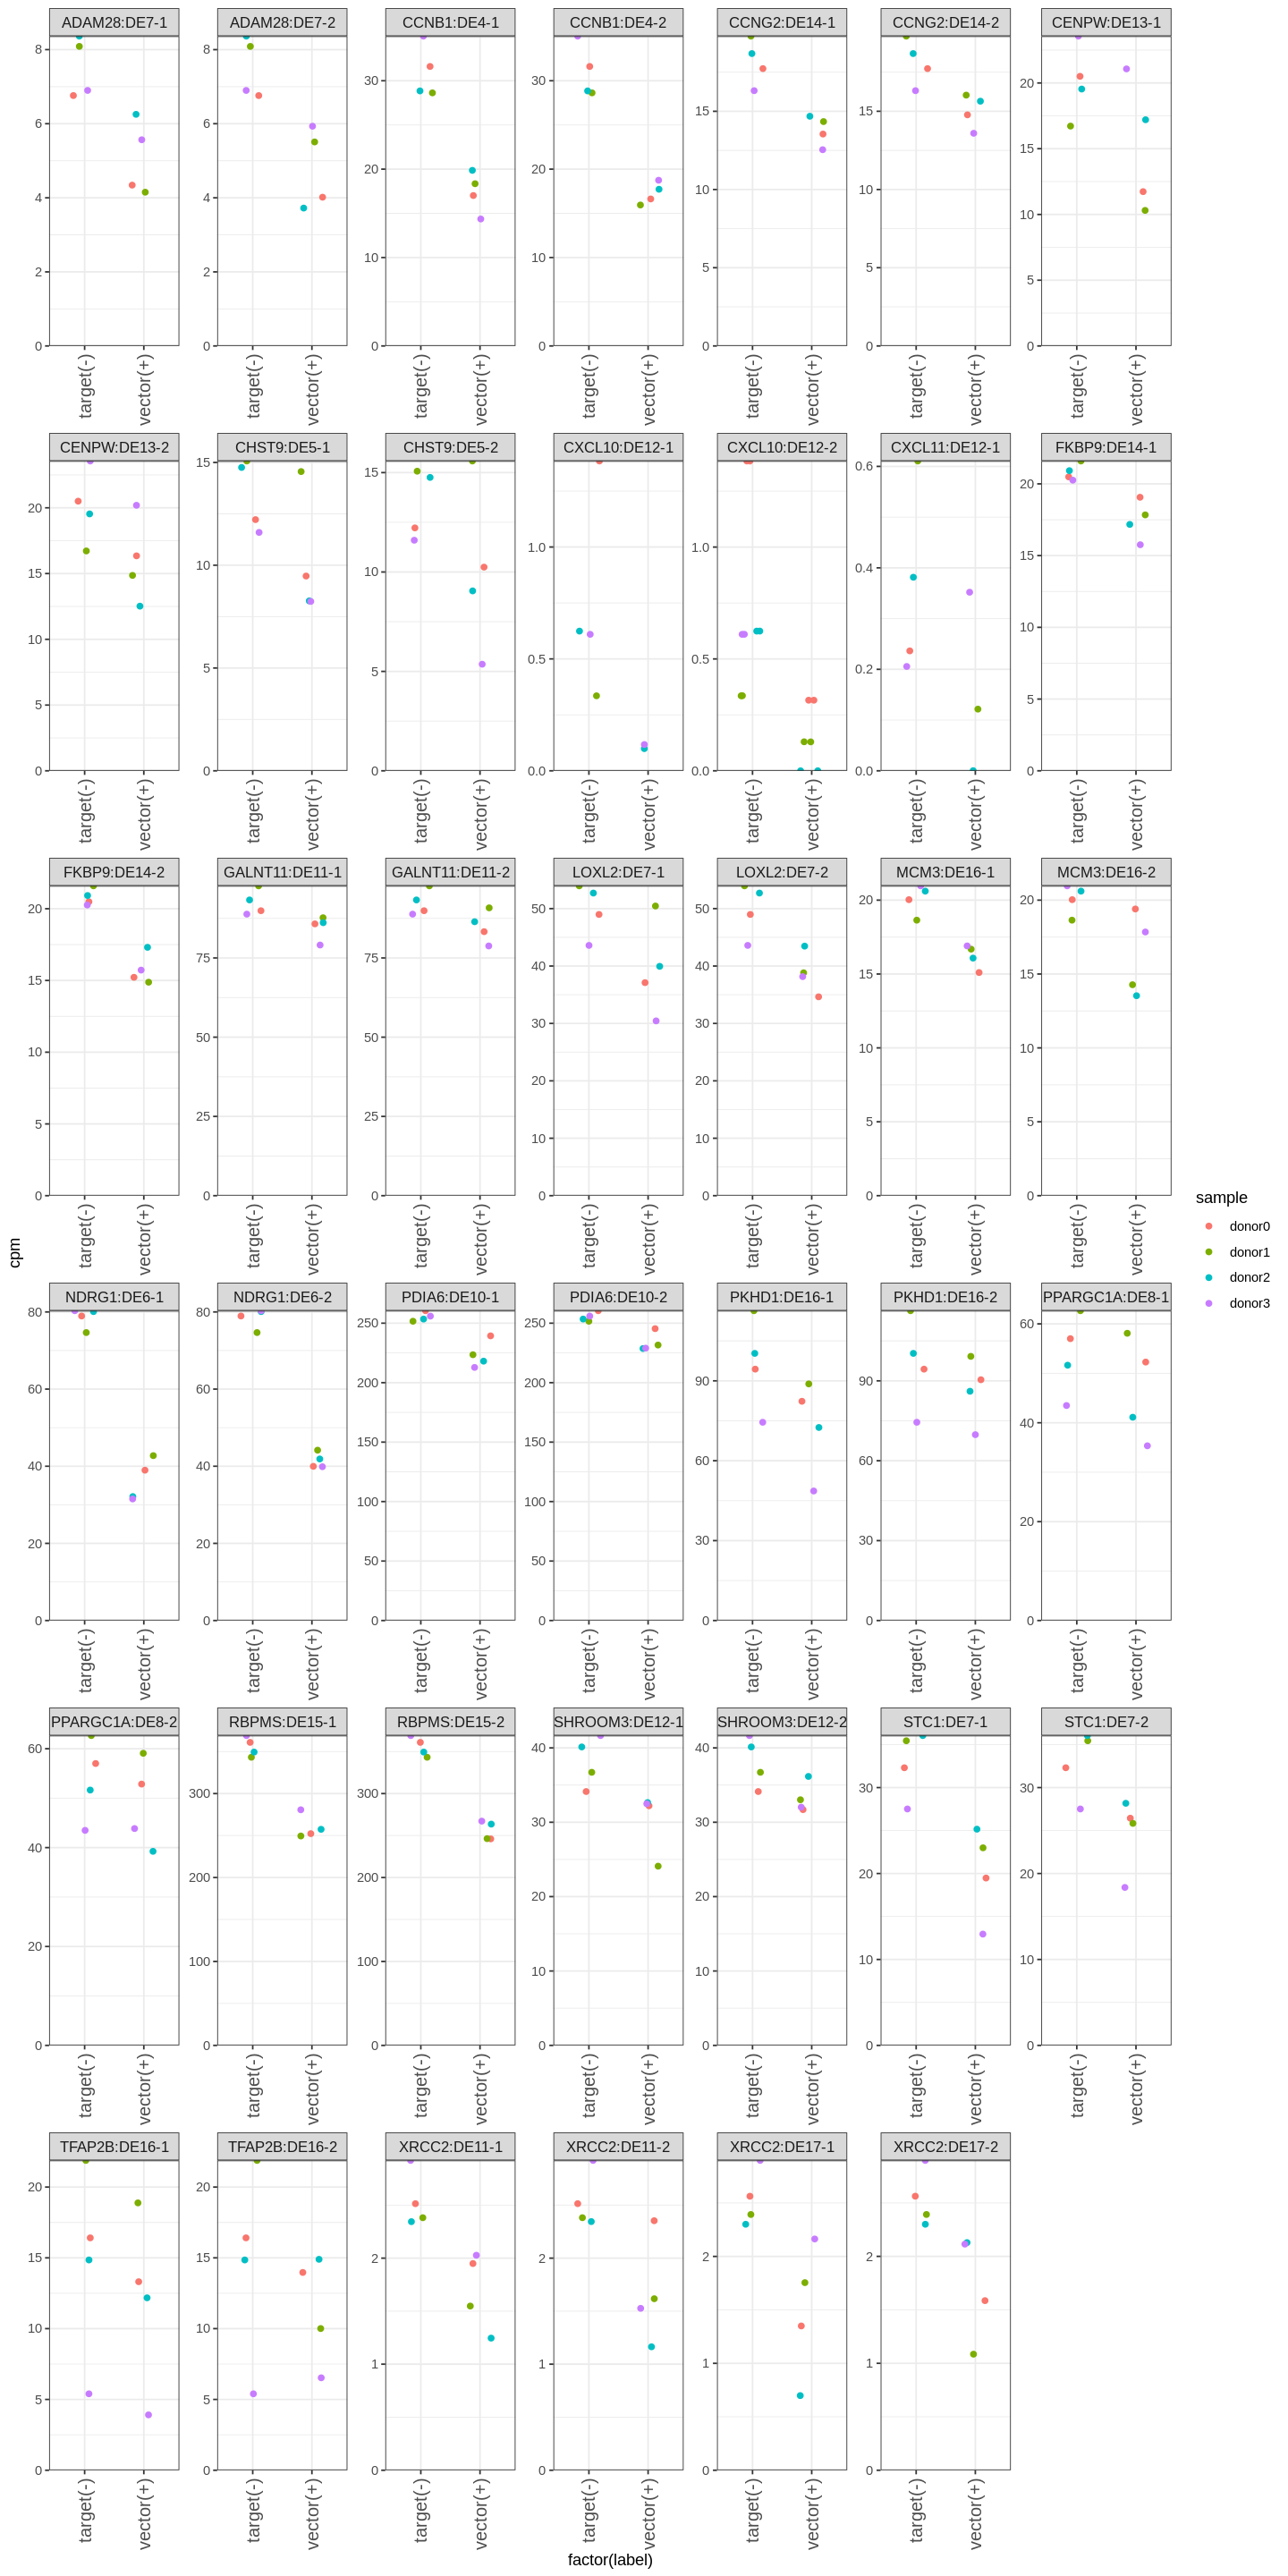

In [ ]:
df_cell_counts = df_cell_counts_backup
df_cell_counts$label = str_replace(df_cell_counts$label, "donor._", "")
df_cell_counts$label = str_replace(df_cell_counts$label, "cluster0", "vector(+)")
df_cell_counts$label = str_replace(df_cell_counts$label, "cluster1", "target(-)")
df_cell_counts$label = str_replace(df_cell_counts$label, "clustervector_B", "(O)")
df_cell_counts$t_and_v = paste0(df_cell_counts$target, ":", df_cell_counts$vector)
#df_cell_counts$norm_count = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

df_cell_counts_tss    = df_cell_counts %>% filter(subclass == 'tss')
df_cell_counts_de     = df_cell_counts %>% filter(subclass == 'de_control')
df_cell_counts_ckd_de = df_cell_counts %>% filter(subclass == 'ckd_de')

# ggplot(df_cell_counts_tss, aes(x = label, y = norm_count, fill = sample))+
#     geom_bar(position = position_dodge2(padding = 0.3), width = 0.75, stat="identity")  +
#     facet_wrap(~ vector, scales="free", ncol = 6) +
#     theme(
#         axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
#         strip.text = element_text(size=10)
#     ) 

options(repr.plot.width=10, repr.plot.height=3)
#options(repr.plot.width=10, repr.plot.height=6)
ggplot(df_cell_counts_tss, aes(x = factor(label), y = cpm))+
    geom_jitter(aes(color=sample), width=0.2)  +
    facet_wrap(~ vector, scales="free", ncol = 6) +
    scale_y_continuous(expand = c(0, 0), limits = c(0,NA)) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
        strip.text = element_text(size=10)
    ) 

options(repr.plot.width=10, repr.plot.height=6)
#options(repr.plot.width=11, repr.plot.height=9)
ggplot(df_cell_counts_de, aes(x = factor(label), y = cpm))+
    geom_jitter(aes(color=sample),width=0.2)  +
    facet_wrap(~ vector, scales="free", ncol = 7) +
    scale_y_continuous(expand = c(0, 0), limits = c(0,NA)) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
        strip.text = element_text(size=10)
    ) 
options(repr.plot.width=12, repr.plot.height=18)
#options(repr.plot.width=10, repr.plot.height=6)
ggplot(df_cell_counts_ckd_de, aes(x = factor(label), y = cpm))+
    geom_jitter(aes(color=sample), width=0.2)  +
    facet_wrap(~ t_and_v, scales="free", ncol = 7) +
    scale_y_continuous(expand = c(0, 0), limits = c(0,NA)) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
        strip.text = element_text(size=10)
    ) 
    

#geom_bar(position = position_dodge2(padding = 0.3), stat="identity")  +

In [ ]:
head(df_cell_counts)


,Row.names,cpm,target,vector,label,subclass,group,lib.size,norm.factors,sample,cluster,t_and_v
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,donor0_cluster0,56,ANPEP,CD13-1,vector(+),tss,1,6.9e+06,1,donor0,0,ANPEP:CD13-1
2,donor0_cluster1,152,ANPEP,CD13-1,target(-),tss,1,1.6e+08,1,donor0,1,ANPEP:CD13-1
3,donor1_cluster0,68,ANPEP,CD13-1,vector(+),tss,1,7.9e+06,1,donor1,0,ANPEP:CD13-1
4,donor1_cluster1,143,ANPEP,CD13-1,target(-),tss,1,1.7e+08,1,donor1,1,ANPEP:CD13-1
5,donor2_cluster0,68,ANPEP,CD13-1,vector(+),tss,1,1.2e+07,1,donor2,0,ANPEP:CD13-1
6,donor2_cluster1,155,ANPEP,CD13-1,target(-),tss,1,2.2e+08,1,donor2,1,ANPEP:CD13-1


## Inpect DE results

Print top high-confidence hits

In [ ]:
df_neighbor_de %>% filter(logFC < 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.67,13.6,4162,0.0e+00,FTH1,FTH1,de_control,Control DE,FTH1-1,0.0e+00
2,-1.35,7.9,1709,0.0e+00,LGALS3,LGALS3,de_control,Control DE,LGALS3-1,0.0e+00
3,-1.28,7.9,1319,9.0e-285,LGALS3,LGALS3,de_control,Control DE,LGALS3-2,1.4e-281
4,-0.87,8.7,969,5.2e-210,CTSB,CTSB,de_control,Control DE,CTSB-2,7.8e-207
5,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,4.0e-204
6,-0.94,8.7,949,1.9e-200,CTSB,CTSB,de_control,Control DE,CTSB-1,2.8e-197
7,-2.14,4.9,790,3.1e-173,C15orf40,C15orf40,tss,Control TSS,C15orf40-1,4.7e-170
8,-1.85,6.4,1291,6.0e-165,NT5E,NT5E,tss,Control TSS,CD73-1,9.1e-162
9,-0.95,6.0,609,6.4e-134,NDRG1,DE6,ckd_de,CKD DE,DE6-2,9.6e-131


In [ ]:
df_neighbor_de %>% filter(logFC > 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.24,6.5,76,3.3e-18,SLC3A2,FTH1,de_control,Control DE,FTH1-2,5.0e-15
2,0.22,6.6,32,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.7e-05
3,0.22,6.6,32,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.7e-05
4,0.22,6.6,32,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.7e-05
5,0.46,2.3,31,2.6e-08,VWCE,FTH1,de_control,Control DE,FTH1-2,3.8e-05
6,0.13,11.2,31,2.9e-08,RPL36,PLIN3,de_control,Control DE,PLIN3-1,4.3e-05
7,0.15,11.2,29,6.2e-08,RPL36,PLIN3,de_control,Control DE,PLIN3-2,9.3e-05
8,0.29,3.4,24,8.3e-07,SNHG1,FTH1,de_control,Control DE,FTH1-2,1.3e-03
9,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,2.3e-03


### Check the TSS

In [ ]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC < 0) %>% arrange(PValue) %>% head(40)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.91,1122.3,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,4.0e-204
2,-2.14,4.94,790.1,3.1e-173,C15orf40,C15orf40,tss,Control TSS,C15orf40-1,4.7e-170
3,-1.85,6.37,1290.8,6.0e-165,NT5E,NT5E,tss,Control TSS,CD73-1,9.1e-162
4,-2.20,4.06,432.1,8.8e-96,CD55,CD55,tss,Control TSS,CD55-1,1.3e-92
5,-0.86,5.59,246.5,5.1e-55,FUBP1,FUBP1,tss,Control TSS,FUBP1-1,7.7e-52
6,-1.82,3.37,167.0,3.5e-38,MAFF,MAFF,tss,Control TSS,MAFF-1,5.3e-35
7,-0.33,6.66,76.3,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1,3.8e-15
8,-0.19,10.47,57.9,2.7e-14,LGALS1,MAFF,tss,Control TSS,MAFF-1,4.1e-11
9,-0.20,6.72,27.3,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1,2.7e-04


In [ ]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC > 0) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.233,5.4,23.1,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,0.0023
2,0.208,5.4,18.8,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1,0.0223
3,0.149,6.3,14.4,1.5e-04,NGRN,ANPEP,tss,Control TSS,CD13-1,0.2202
4,1.078,-1.1,8.8,2.9e-03,IDH2-DT,ANPEP,tss,Control TSS,CD13-1,1.0000
5,0.308,3.0,8.5,3.6e-03,DNAJB4,FUBP1,tss,Control TSS,FUBP1-1,1.0000
6,0.262,3.7,8.5,3.6e-03,MICALL1,MAFF,tss,Control TSS,MAFF-1,1.0000
7,0.427,1.6,6.8,9.2e-03,CPEB1,C15orf40,tss,Control TSS,C15orf40-1,1.0000
8,0.159,4.8,5.7,1.7e-02,JOSD1,MAFF,tss,Control TSS,MAFF-1,1.0000
9,0.180,3.4,4.2,4.1e-02,MESP1,ANPEP,tss,Control TSS,CD13-1,1.0000


In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-0.95,6.0,609,6.4e-134,NDRG1,DE6,ckd_de,CKD DE,DE6-2,9.6e-131
2,-1.15,6.0,603,3.0e-89,NDRG1,DE6,ckd_de,CKD DE,DE6-1,4.6e-86
3,-0.51,8.3,373,5.3e-83,RBPMS,DE15,ckd_de,CKD DE,DE15-2,8.0e-80
4,-0.48,8.3,285,8.1e-64,RBPMS,DE15,ckd_de,CKD DE,DE15-1,1.2e-60
5,-0.72,4.9,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,1.1e-32
6,-0.72,4.9,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,1.1e-32
7,-0.72,4.9,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,1.1e-32
8,-0.87,4.8,155,1.7e-35,CCNB1,DE4,ckd_de,CKD DE,DE4-2,2.6e-32
9,-0.85,4.8,211,1.2e-29,CCNB1,DE4,ckd_de,CKD DE,DE4-1,1.8e-26


In [ ]:
df_neighbor_de %>% filter((subclass == 'de_control') & (PValue < 1e-10)) 

logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
-1.67,13.6,4162,0.0e+00,FTH1,FTH1,de_control,Control DE,FTH1-1,0.0e+00
-1.31,3.5,109,2.1e-25,BEST1,FTH1,de_control,Control DE,FTH1-1,3.1e-22
-0.44,5.2,47,5.8e-12,FADS3,FTH1,de_control,Control DE,FTH1-1,8.7e-09
-0.42,4.7,98,3.8e-23,FADS2,FTH1,de_control,Control DE,FTH1-2,5.7e-20
-0.22,8.3,93,4.3e-22,AHNAK,FTH1,de_control,Control DE,FTH1-2,6.4e-19
0.24,6.5,76,3.3e-18,SLC3A2,FTH1,de_control,Control DE,FTH1-2,5.0e-15
-0.26,6.0,73,1.5e-17,ASRGL1,FTH1,de_control,Control DE,FTH1-2,2.2e-14
-0.20,5.9,42,7.7e-11,FADS1,FTH1,de_control,Control DE,FTH1-2,1.2e-07
-0.96,6.3,528,1.2e-116,PLIN3,PLIN3,de_control,Control DE,PLIN3-1,1.8e-113


In [ ]:
#select_significant_p  = df_neighbor_de$PValue < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
801,-1.1530,6.019,603.039,3.0e-89,NDRG1,DE6,ckd_de,CKD DE,DE6-1,4.6e-86
802,0.0632,6.145,2.455,1.2e-01,PHF20L1,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
803,0.8581,-2.144,2.443,1.2e-01,HPYR1,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
804,0.1088,2.520,0.843,3.6e-01,TG,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
805,0.0553,4.453,0.766,3.8e-01,KCNQ3,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
806,-0.2176,-0.055,0.494,4.8e-01,CCN4,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
807,0.1899,-0.658,0.282,6.0e-01,TMEM71,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
808,0.1320,-0.112,0.196,6.6e-01,SLA,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
809,0.0049,6.765,0.018,8.9e-01,ST3GAL1,DE6,ckd_de,CKD DE,DE6-1,1.0e+00


,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1338,-0.481,8.30,2.8e+02,8.1e-64,RBPMS,DE15,ckd_de,CKD DE,DE15-1,1.2e-60
1339,-0.488,1.03,4.2e+00,4.1e-02,TEX15,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1340,0.846,-1.51,3.3e+00,6.9e-02,LINC00589,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1341,0.208,2.73,3.3e+00,7.1e-02,RBPMS-AS1,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1342,0.083,5.54,3.0e+00,8.4e-02,LEPROTL1,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1343,1.183,-3.01,2.4e+00,1.2e-01,LINC02099,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1344,1.050,-2.82,2.1e+00,1.5e-01,PURG,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1345,0.677,-1.91,1.5e+00,2.2e-01,MBOAT4,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1346,-0.066,4.94,1.3e+00,2.6e-01,WRN,DE15,ckd_de,CKD DE,DE15-1,1.0e+00


## Volcano Plot

In [ ]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 66 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


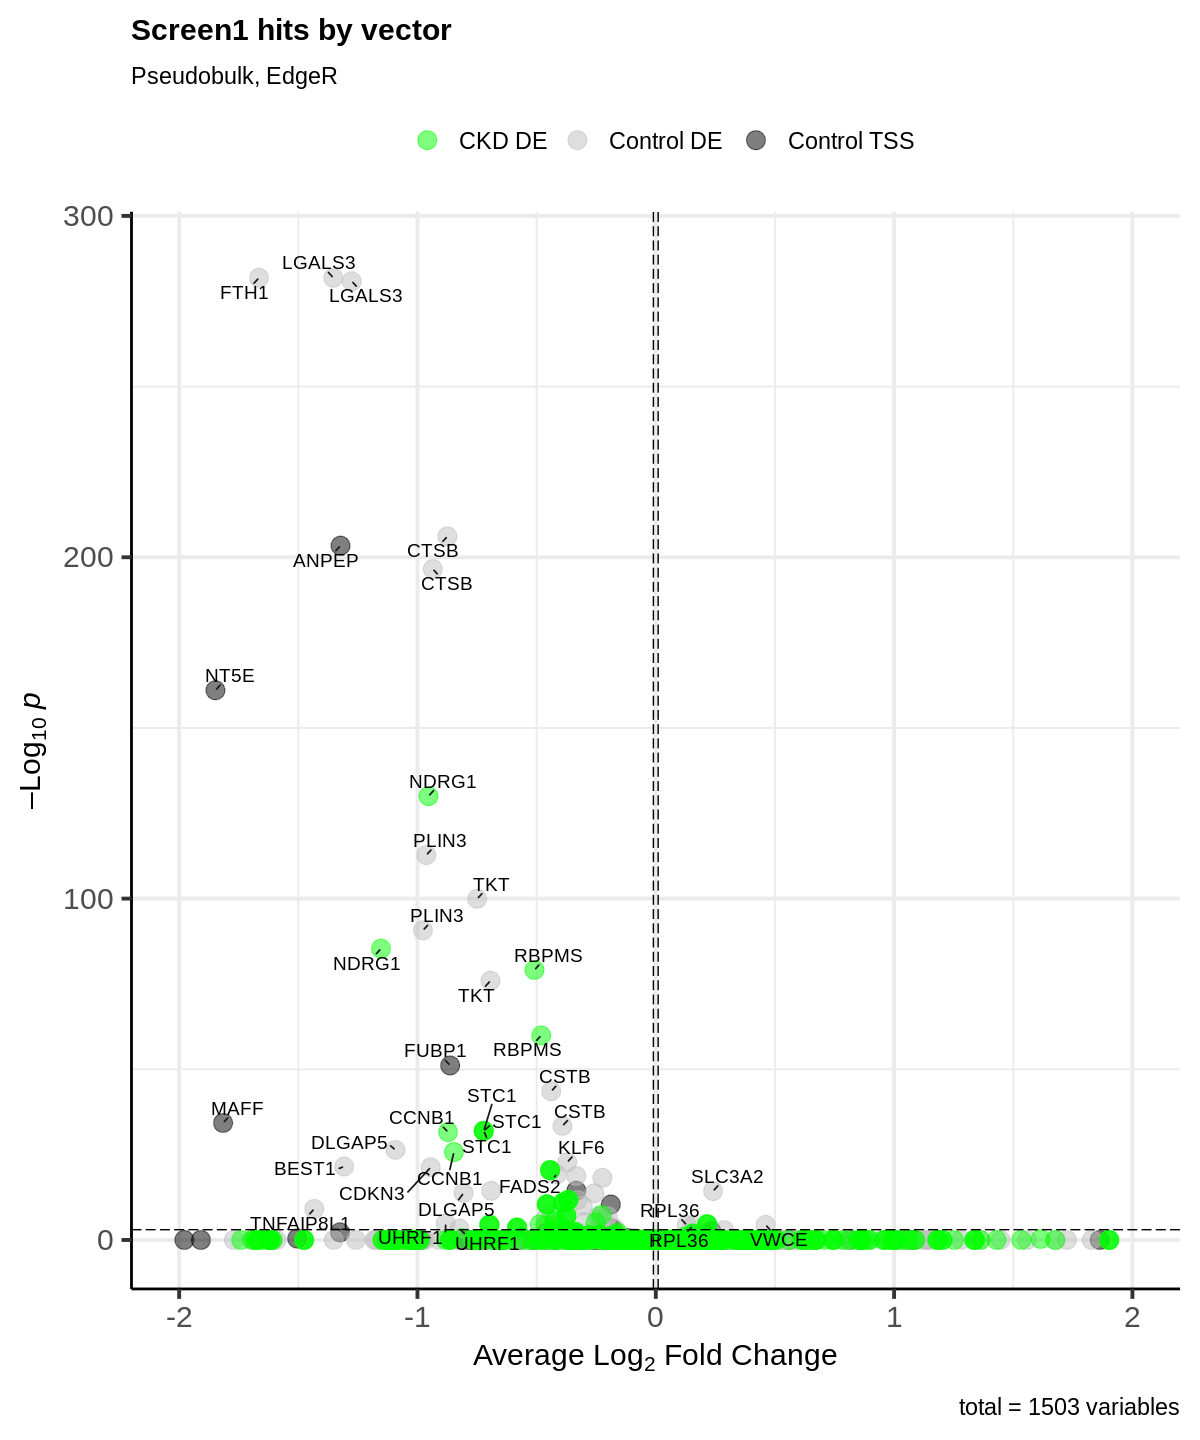

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, "hits by vector"),
                subtitle = 'Pseudobulk, EdgeR', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-04,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"Removed 1 rows containing missing values (`geom_hline()`)."


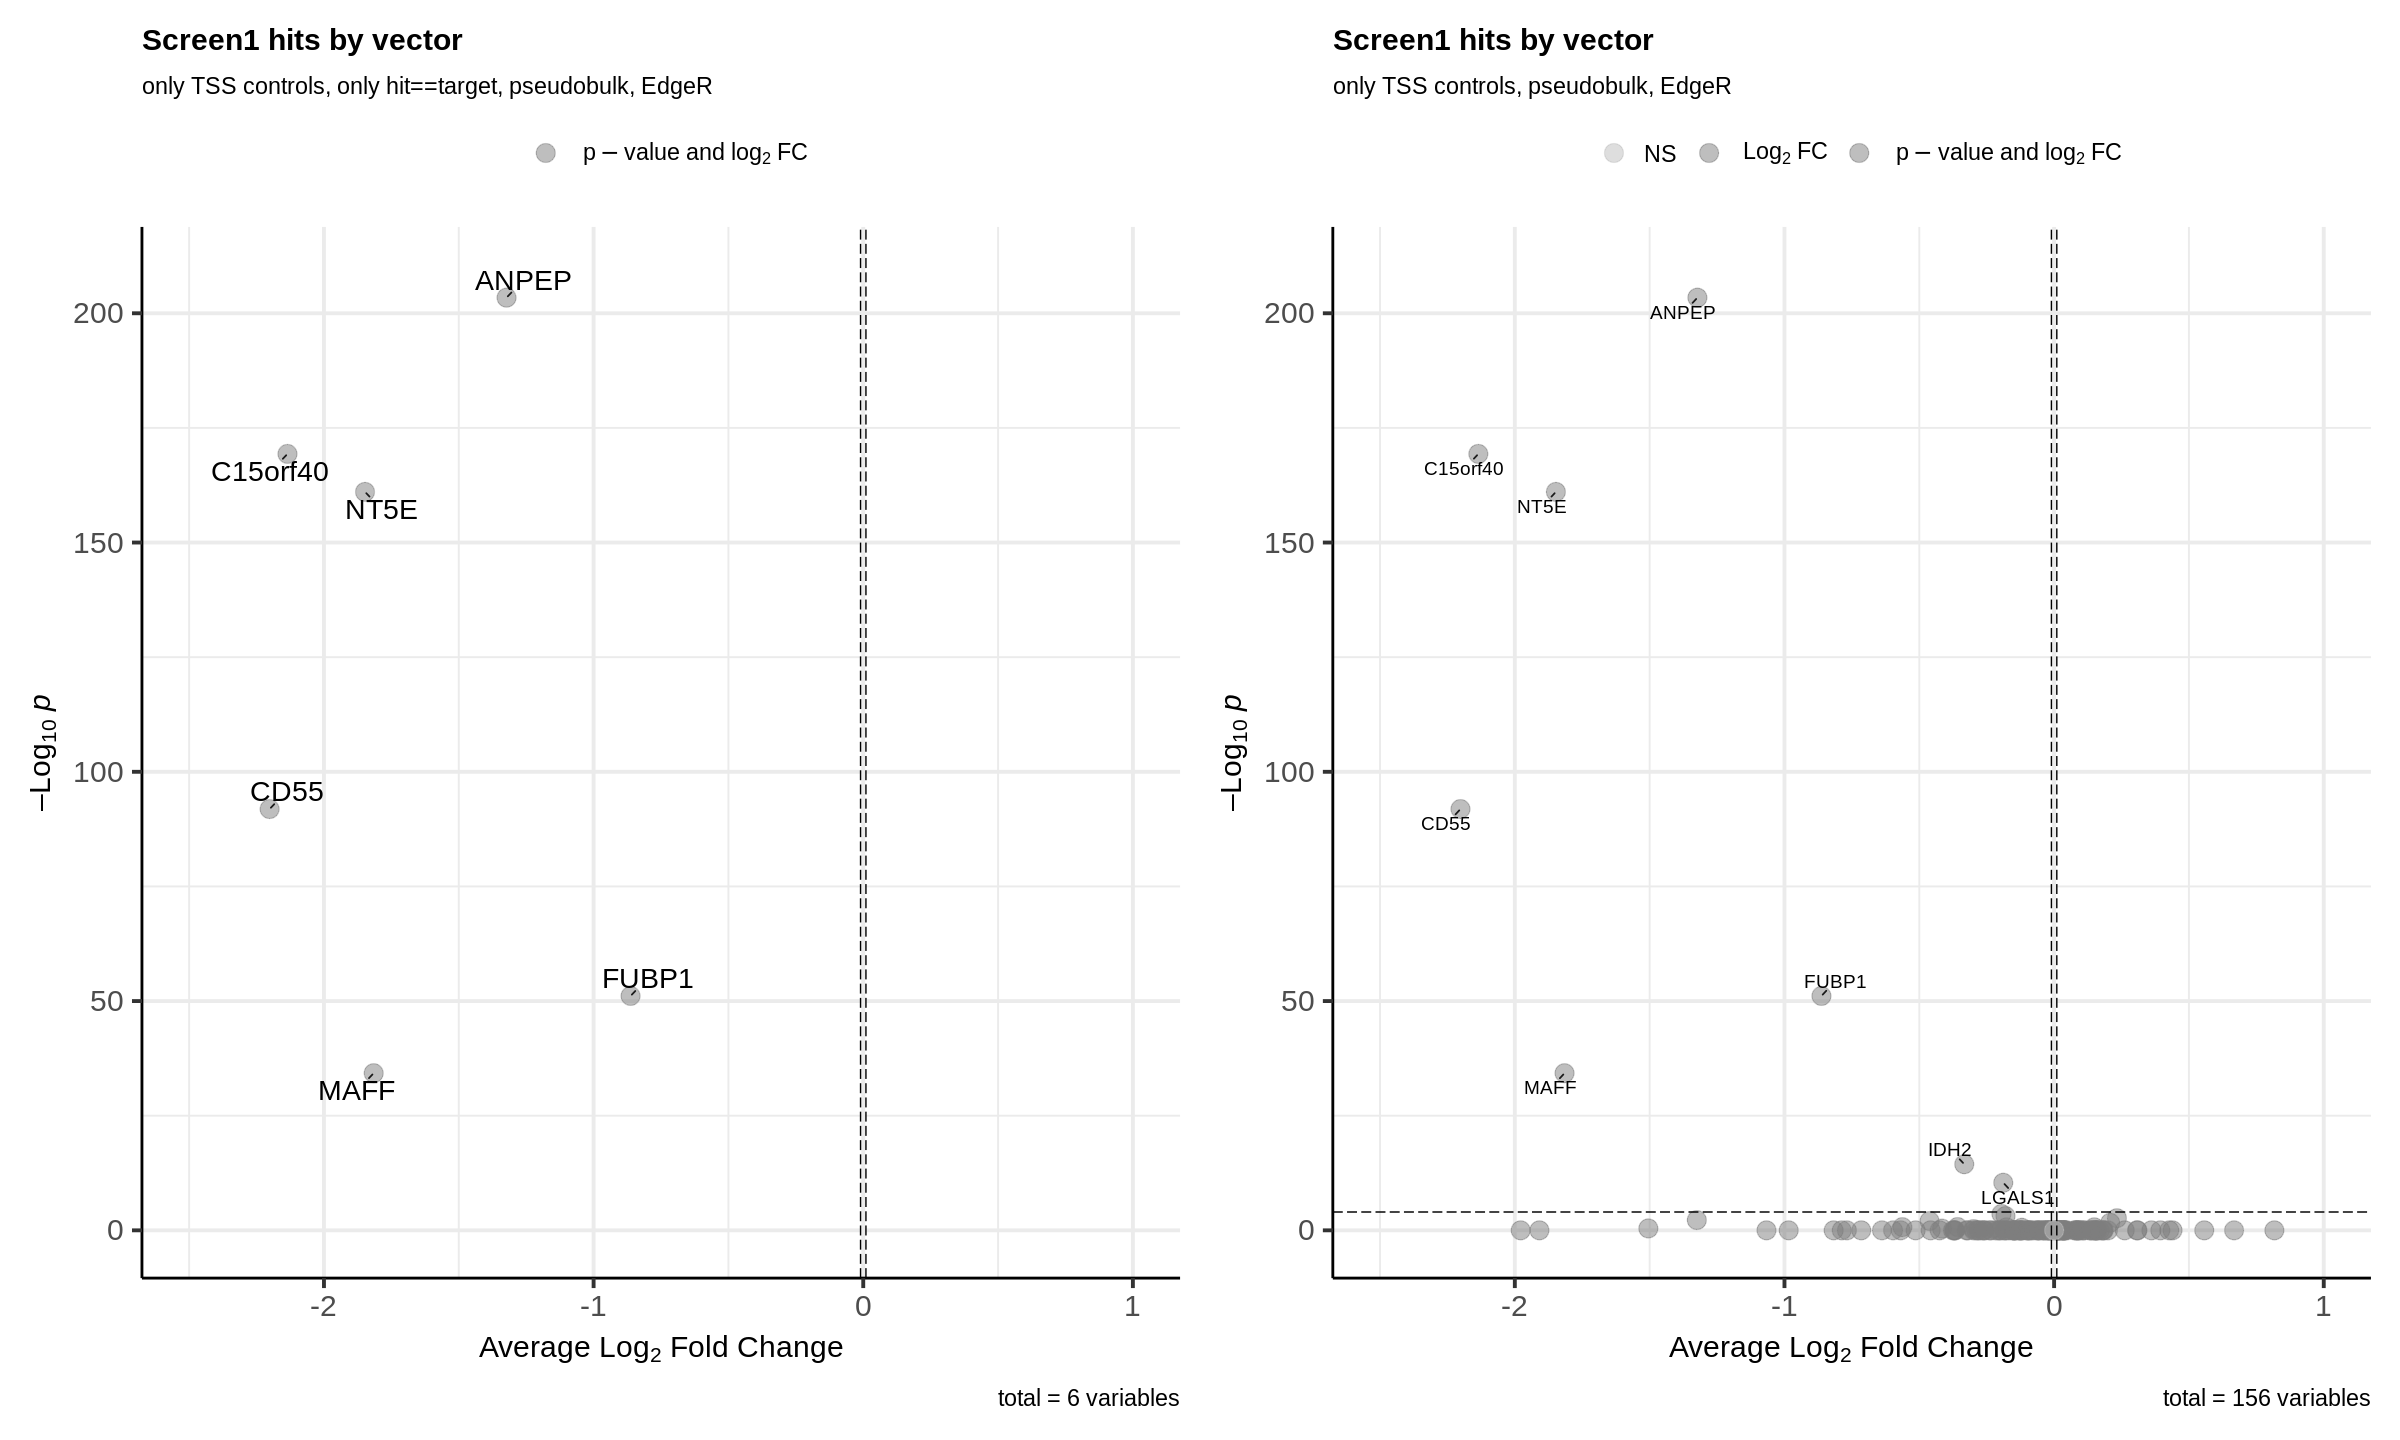

In [ ]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only TSS controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-0,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only TSS controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [ ]:
head(df_neighbor_de_subset)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,4.0e-204
2,-0.33,6.7,76,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1,3.8e-15
3,-0.20,6.7,27,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1,2.7e-04
4,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,2.3e-03
5,0.21,5.4,19,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1,2.2e-02
6,-0.36,3.5,15,1.2e-04,FANCI,ANPEP,tss,Control TSS,CD13-1,1.9e-01


### Plot just the control DE

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


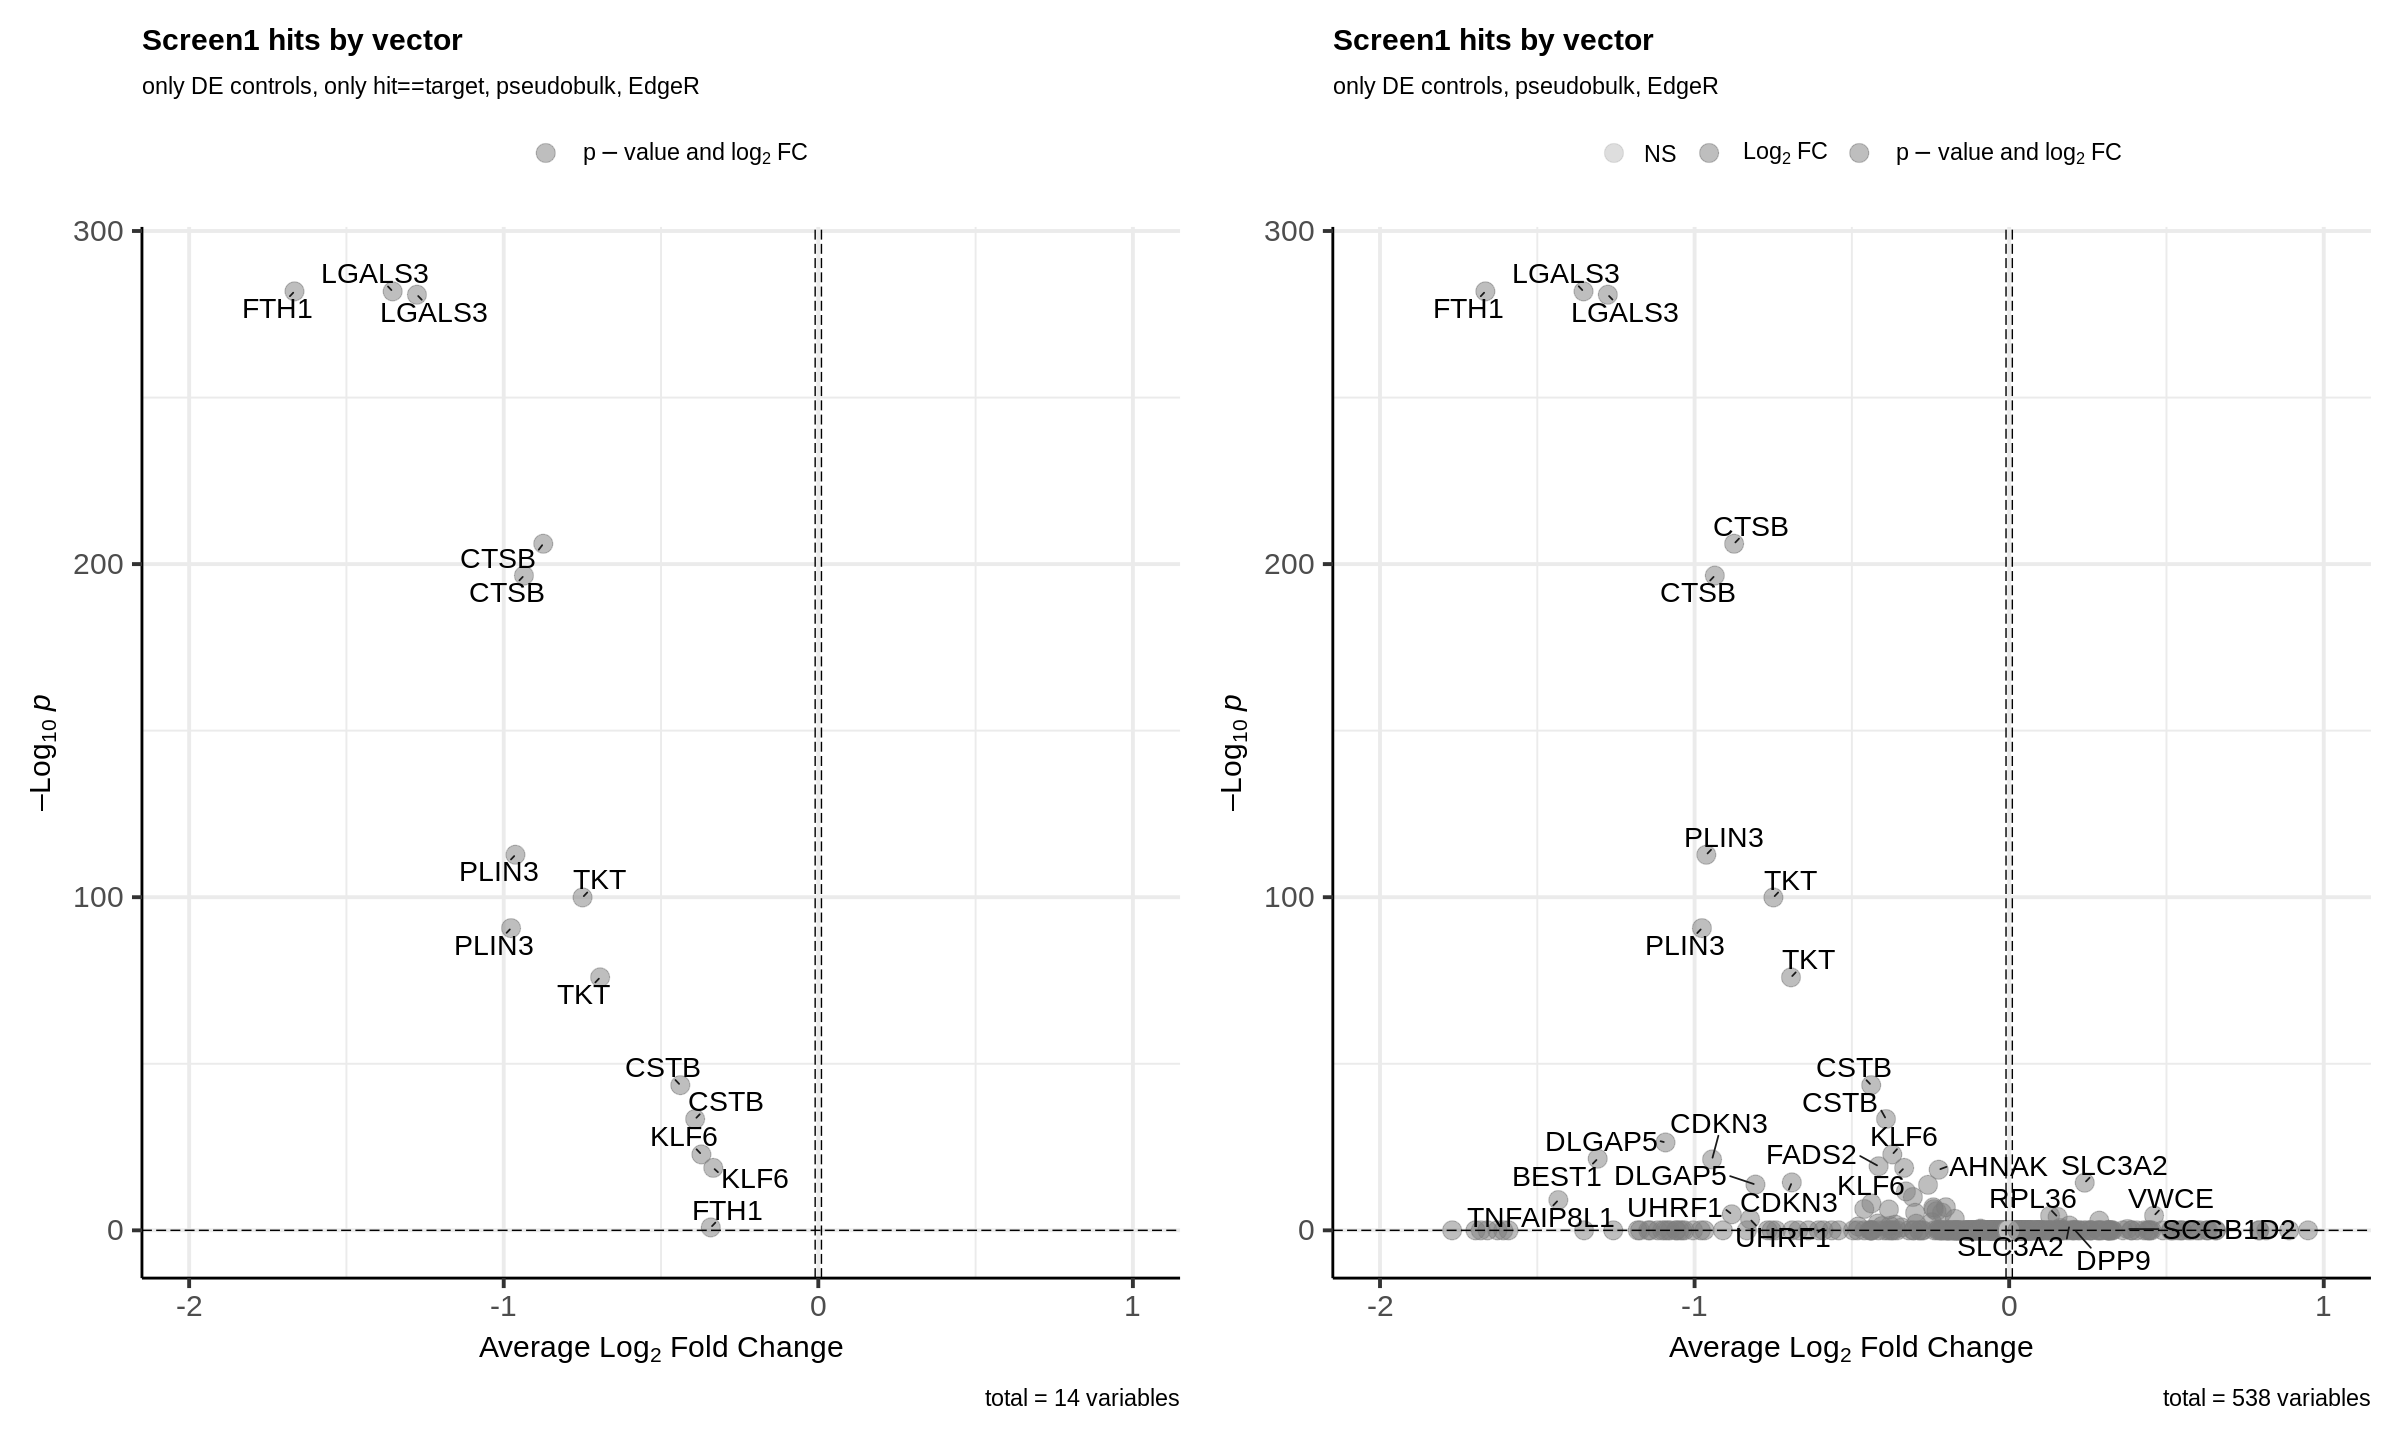

In [ ]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only DE controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-1,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only DE controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-1,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 29 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


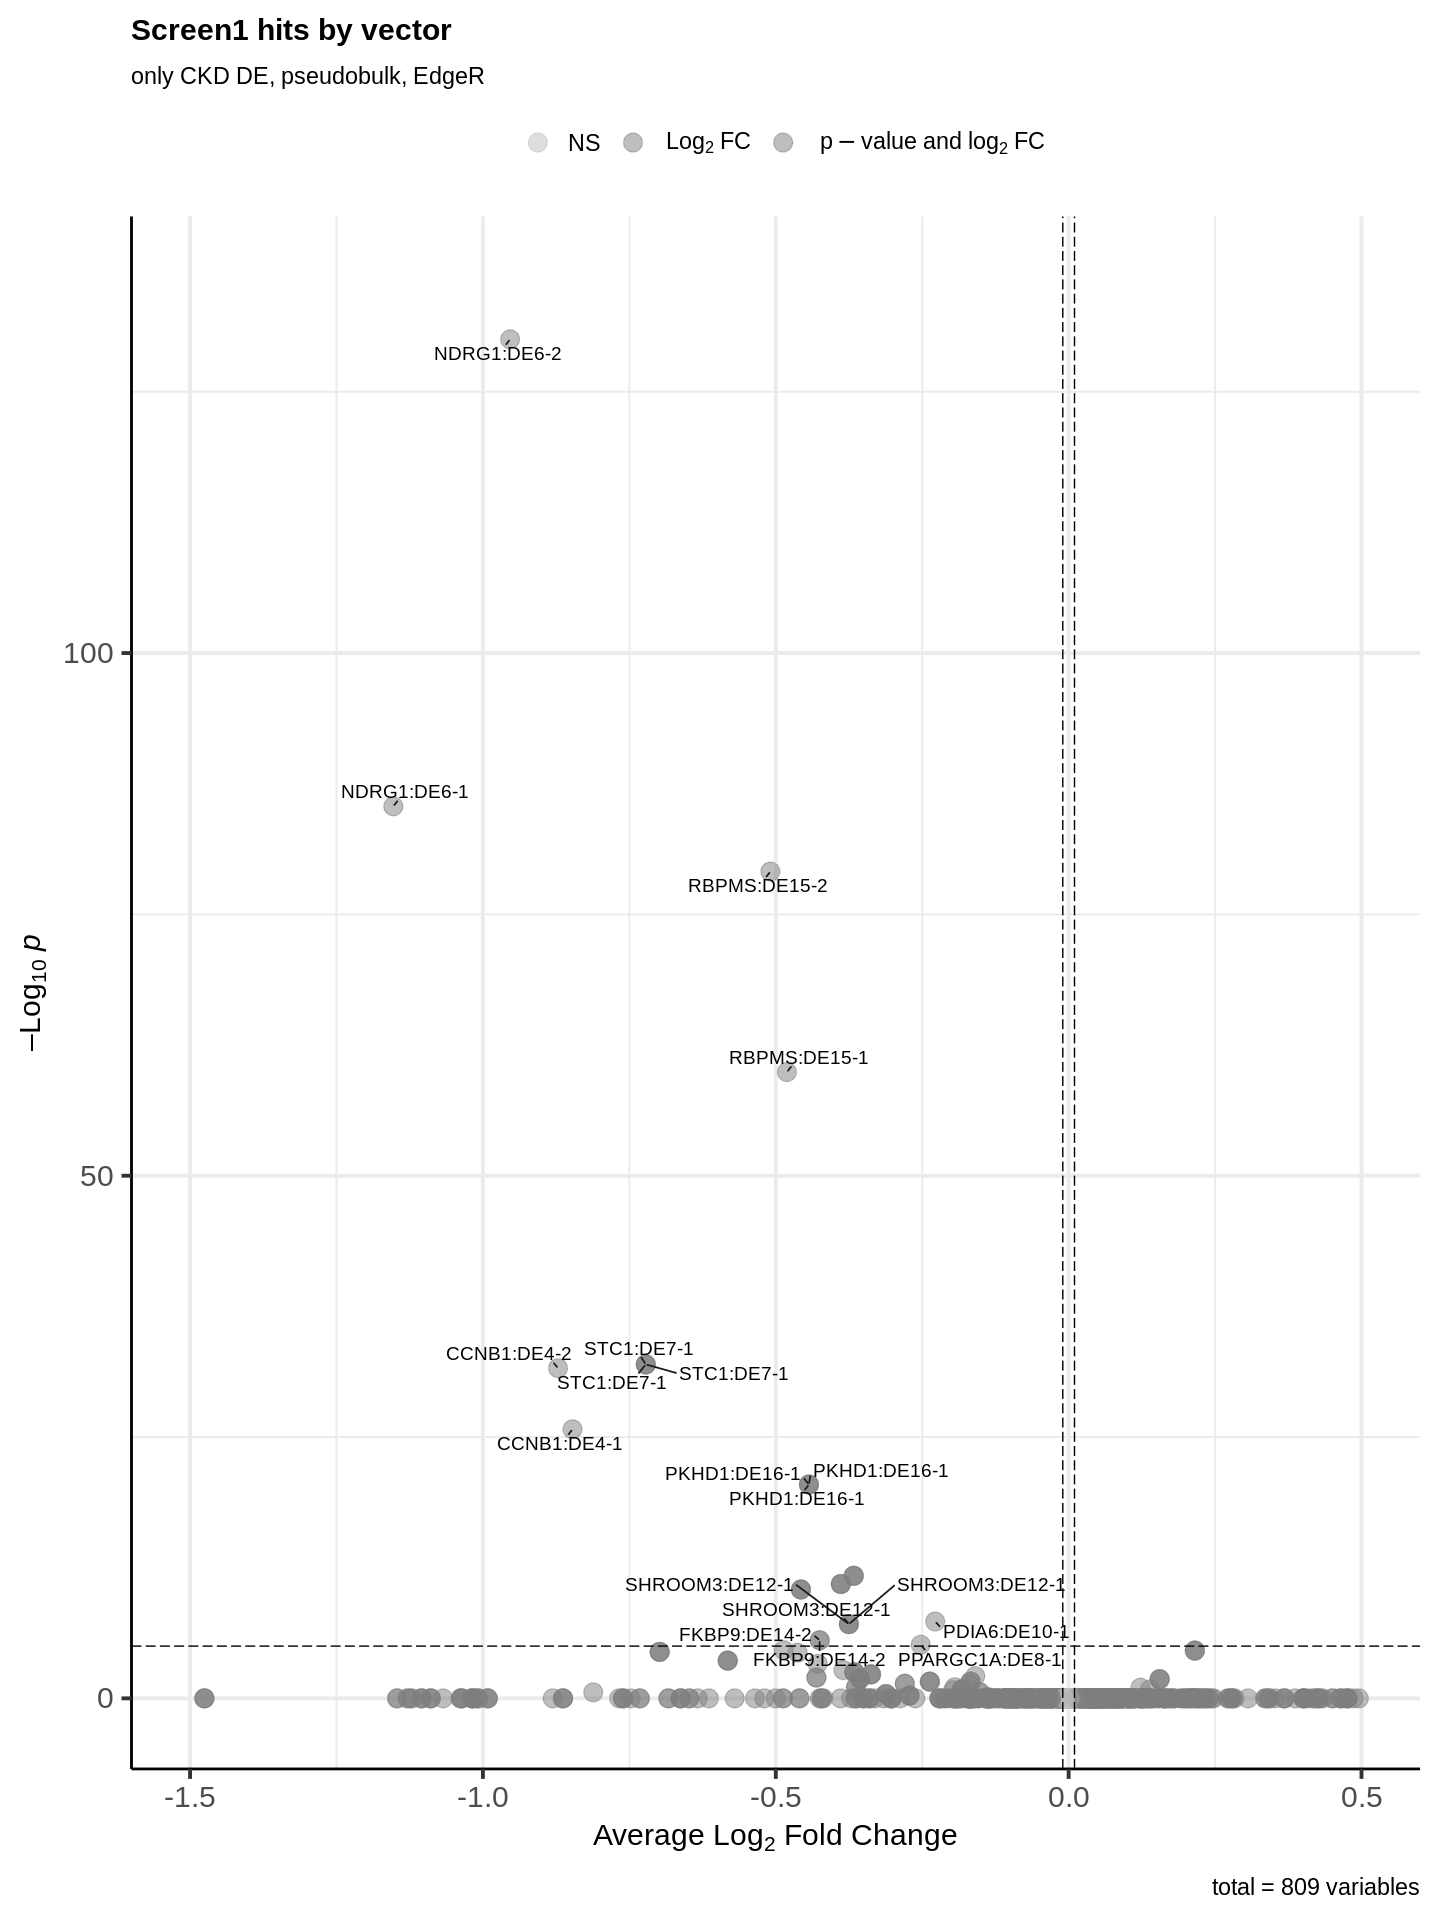

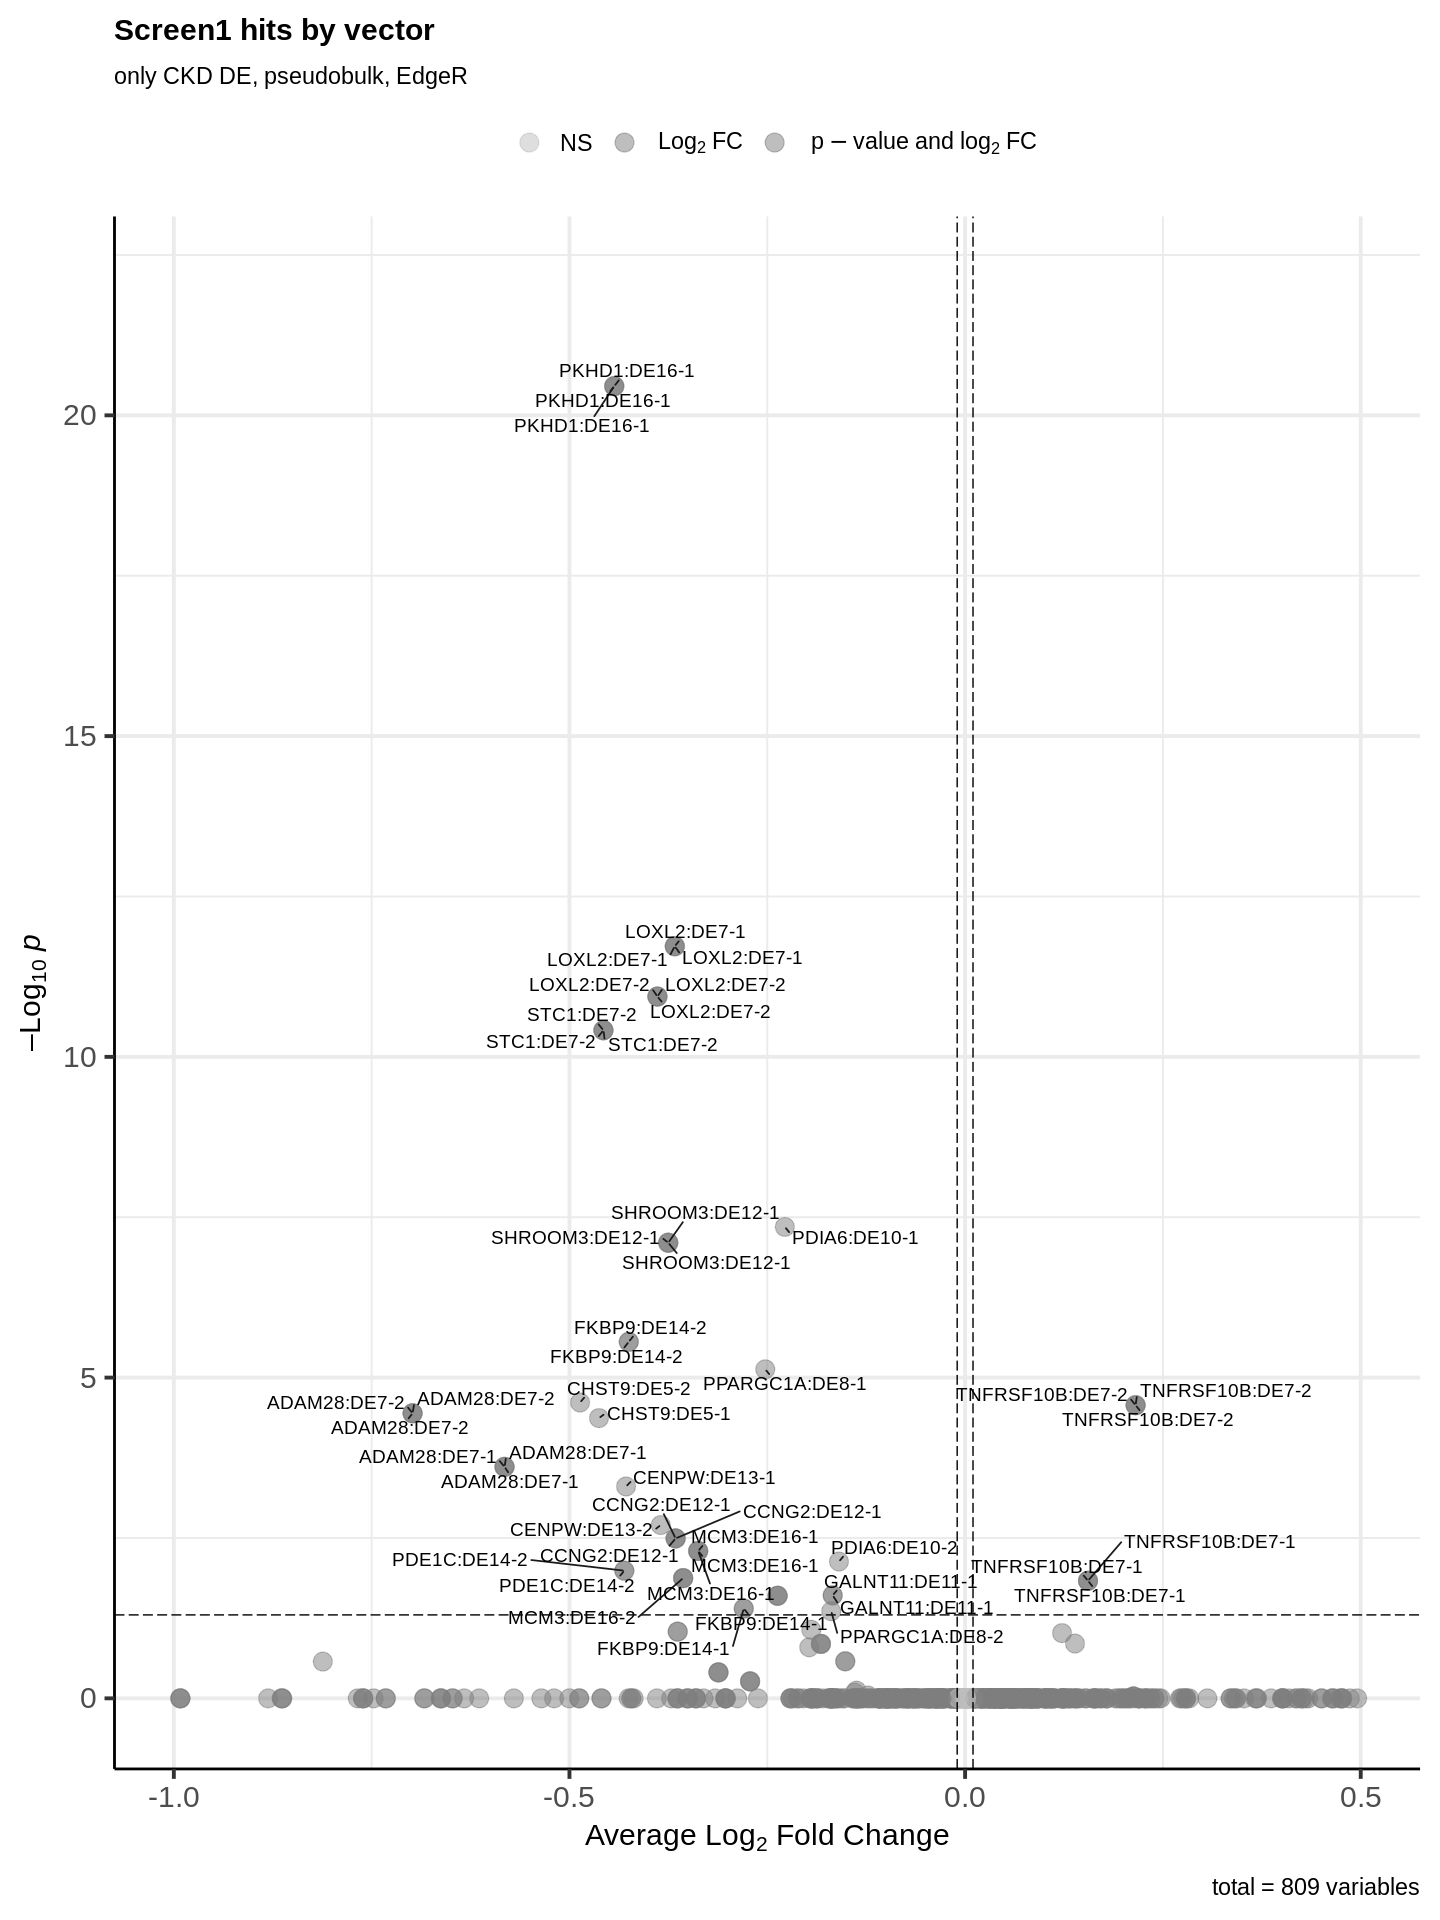

In [ ]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
df_neighbor_de_subset$plot_label = paste0(df_neighbor_de_subset$de_gene, ":", df_neighbor_de_subset$plasmid)

options(repr.plot.width = 12, repr.plot.height = 16)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$plot_label,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 1e-5,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1.5, 0.5) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$plot_label,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 0.05,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1., 0.5) +
                ylim(0, 22) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 
p2


# Inspect further

In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC < 0) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(40)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-0.95,6.03,609,6.4e-134,NDRG1,DE6,ckd_de,CKD DE,DE6-2,9.6e-131
2,-1.15,6.02,603,3.0e-89,NDRG1,DE6,ckd_de,CKD DE,DE6-1,4.6e-86
3,-0.51,8.29,373,5.3e-83,RBPMS,DE15,ckd_de,CKD DE,DE15-2,8.0e-80
4,-0.48,8.30,285,8.1e-64,RBPMS,DE15,ckd_de,CKD DE,DE15-1,1.2e-60
5,-0.72,4.91,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,1.1e-32
6,-0.72,4.91,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,1.1e-32
7,-0.72,4.91,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,1.1e-32
8,-0.87,4.80,155,1.7e-35,CCNB1,DE4,ckd_de,CKD DE,DE4-2,2.6e-32
9,-0.85,4.80,211,1.2e-29,CCNB1,DE4,ckd_de,CKD DE,DE4-1,1.8e-26


In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC > 0) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.215,6.6,31.7,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.7e-05
2,0.215,6.6,31.7,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.7e-05
3,0.215,6.6,31.7,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.7e-05
4,0.155,6.6,19.6,9.8e-06,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-1,1.5e-02
5,0.155,6.6,19.6,9.8e-06,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-1,1.5e-02
6,0.155,6.6,19.6,9.8e-06,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-1,1.5e-02
7,0.123,7.7,16.0,6.4e-05,NRIP1,DE1,ckd_de,CKD DE,DE1-2,9.6e-02
8,0.139,7.7,15.3,9.3e-05,NRIP1,DE1,ckd_de,CKD DE,DE1-1,1.4e-01
9,1.615,-2.0,12.8,3.5e-04,LINC02028,DE2,ckd_de,CKD DE,DE2-2,5.3e-01


# Visualize

In [ ]:
head(seurat_rna$dCas9)

AAACCCAAGAGCAGCT-1_1 AAACCCAAGCTTAAGA-1_1 AAACCCAAGGCTGTAG-1_1 
                  20                   55                  181 
AAACCCAAGGTTTACC-1_1 AAACCCAAGTGATCGG-1_1 AAACGAACAATTGCTG-1_1 
                  58                    1                  100

In [ ]:
seurat_rna$sct_dCas9 = seurat_combined[['SCT']]@data['dCas9',]

In [ ]:
head(seurat_combined[['SCT']]@data['dCas9',],5)
head(seurat_rna$sct_dCas9,5)

AAACCCAAGAGCAGCT-1_1 AAACCCAAGCTTAAGA-1_1 AAACCCAAGGCTGTAG-1_1 
                 3.0                  3.5                  4.2 
AAACCCAAGGTTTACC-1_1 AAACCCAAGTGATCGG-1_1 
                 3.2                  0.0

AAACCCAAGAGCAGCT-1_1 AAACCCAAGCTTAAGA-1_1 AAACCCAAGGCTGTAG-1_1 
                 3.0                  3.5                  4.2 
AAACCCAAGGTTTACC-1_1 AAACCCAAGTGATCGG-1_1 
                 3.2                  0.0

# Redundant

In [ ]:
target
table(Idents(seurat_dummy))

[1] "DE17"


vector_positive target_negative        vector_B 
           1080           25106             956 

In [ ]:
seurat_dummy$mark = Idents(seurat_dummy)
seurat_dummy2 = NormalizeData(seurat_dummy)

In [ ]:
seurat_pseudo <- AverageExpression(seurat_dummy2, assay = 'RNA', slot = 'data', return.seurat = TRUE, group.by = c('mark'))
#seurat_pseudo = NormalizeData(seurat_pseudo)
#seurat_dummy2_bulk <- NormalizeData(seurat_dummy2_bulk)

Centering and scaling data matrix



In [ ]:
#seurat_dummy2_bulk = FindVariableFeatures(seurat_dummy2_bulk) 
#seurat_dummy2_bulk = ScaleData(seurat_dummy2_bulk) 
#seurat_dummy2_bulk = RunPCA(seurat_dummy2_bulk, npcs = 20, features = VariableFeatures(seurat_dummy2_bulk))

In [ ]:
seurat_pseudo[['RNA']]@data['ANPEP',]

vector_positive target_negative        vector_B 
           0.79            0.88            0.78

In [ ]:
s = sum(seurat_rna[['RNA']]@counts[,1])
c = seurat_rna[['RNA']]@counts['ANPEP',1]
d = seurat_rna[['RNA']]@data['ANPEP',1]

In [ ]:
log(1+ (c/s)*10000)
d

[1] 1.9

[1] 1.9